In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy.stats import linregress


pd.set_option('display.max_columns', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 10000)

pd.set_option("display.float_format", lambda x: f"{x:.5f}")


# Formulas and Indicators

## Relative Strength Index (RSI)

In [ ]:
def calculate_rsi(price_data, window=14, price_col='close'):
    """
    Correct RSI calculation.
    """
    delta = price_data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


## Categorical RSI  

In [ ]:
def categorize_rsi(rsi_series):
    """
    Categorize RSI values into bins:
    0-30, 30-50, 50-70, 70-100

    Args:
        rsi_series (pd.Series): RSI values

    Returns:
        pd.Series: Categorical RSI bins
    """
    bins = [0, 30, 50, 70, 100]
    labels = ['oversold', 'below_avg', 'above_avg', 'overbought']
    return pd.cut(rsi_series, bins=bins, labels=labels, include_lowest=True)


## Average True Range (ATR)

In [ ]:
def calculate_atr(price_data, window=14):
    """
    Calculate ATR (Average True Range) using Wilder's RMA.

    Args:
        price_data (pd.DataFrame): DataFrame containing columns 'high', 'low', 'close'
        window (int): Lookback period (default: 14)

    Returns:
        pd.Series: ATR values
    """
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    # Calculate True Range (TR)
    previous_close = close.shift(1)
    tr1 = high - low
    tr2 = abs(high - previous_close)
    tr3 = abs(low - previous_close)
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR = RMA of True Range
    atr = true_range.ewm(alpha=1/window, adjust=False).mean()

    return atr

## Bollinger Bands

In [31]:
def calculate_bollinger_bands(price_data, window=20, std_multiplier=2, price_col='close'):
    """
    Calculate Bollinger Bands.

    Args:
        price_data (pd.DataFrame): DataFrame containing OHLC prices
        window (int): Lookback period for SMA (default: 20)
        std_multiplier (float): Standard deviation multiplier (default: 2)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.DataFrame: DataFrame with 'bb_middle', 'bb_upper', 'bb_lower' columns
    """
    price = price_data[price_col]

    # Middle Band: SMA
    sma = price.rolling(window=window).mean()

    # Standard Deviation
    std = price.rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std

    # Return as DataFrame
    bb = pd.DataFrame({
        'bb_middle': sma,
        'bb_upper': upper_band,
        'bb_lower': lower_band
    })

    return bb


## Donchain Channels

In [ ]:
#USE 20, 50 OR 55

def calculate_donchian_channel(price_data, window=20):
    """
    Calculate Donchian Channel.

    Args:
        price_data (pd.DataFrame): DataFrame with 'high' and 'low' columns
        window (int): Lookback period (default: 20)

    Returns:
        pd.DataFrame: DataFrame with 'dc_upper', 'dc_lower', 'dc_middle'
    """
    upper_band = price_data['high'].rolling(window=window).max()
    lower_band = price_data['low'].rolling(window=window).min()
    middle_band = (upper_band + lower_band) / 2

    dc = pd.DataFrame({
        'dc_upper': upper_band,
        'dc_lower': lower_band,
        'dc_middle': middle_band
    })

    return dc


## Simple Moving Average - SMA

In [ ]:
# USE 13, 50, 100 OR 200

def calculate_sma(price_data, window=50, price_col='close'):
    """
    Calculate Simple Moving Average (SMA).

    Args:
        price_data (pd.DataFrame): DataFrame containing price data
        window (int): Lookback period for SMA (default: 50)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.Series: SMA values
    """
    sma = price_data[price_col].rolling(window=window).mean()
    return sma


## Trend

In [ ]:
def determine_sma_trend(price_data, short_window=50, long_window=200, price_col='close'):
    """
    Determine trend based on SMA crossover.

    Args:
        price_data (pd.DataFrame): DataFrame containing price data
        short_window (int): Short SMA period (default: 13)
        long_window (int): Long SMA period (default: 50)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.Series: Trend labels ('uptrend' or 'downtrend')
    """
    short_sma = price_data[price_col].rolling(window=short_window).mean()
    long_sma = price_data[price_col].rolling(window=long_window).mean()

    trend = np.where(short_sma > long_sma, 'uptrend', 'downtrend')

    return pd.Series(trend, index=price_data.index)


## EMA

In [ ]:
def calculate_ema(df, window=50, column='close'):
    """
    DataFrame için EMA (Exponential Moving Average) hesaplar

    Parameters:
    df (pd.DataFrame): Fiyat verilerini içeren DataFrame
    window (int): EMA periyodu (varsayılan: 50)
    column (str): Kullanılacak sütun adı (varsayılan: 'close')

    Returns:
    pd.Series: Hesaplanan EMA değerleri
    """

    # Düzgünleştirme faktörü (alpha)
    alpha = 2 / (window + 1)

    # EMA hesaplama - pandas ewm fonksiyonu kullanarak
    ema = df[column].ewm(alpha=alpha, adjust=False).mean()

    return ema

## Nadaraya Watson Envelope

In [ ]:
def calculate_nadaraya_watson_envelope_optimized(df, bandwidth=8.0, multiplier=3.0, source_col='close', window_size=50):# window_size=500 kullanımı da var.
    """
    Nadaraya-Watson Envelope'un repaint olmayan modunu hesaplar.
    Sadece hesaplanan 'nw_lower', 'nw', 'nw_upper' sütunlarını içeren bir DataFrame döndürür.

    Parametreler:
    df (pd.DataFrame): 'close', 'open', 'high', 'low', 'time' sütunlarına sahip DataFrame.
    bandwidth (float): Nadaraya-Watson için bant genişliği (h).
    multiplier (float): Zarfların genişliğini ayarlamak için çarpan.
    source_col (str): Hesaplama için kullanılacak kaynak sütun adı (örn: 'close').
    window_size (int): Nadaraya-Watson ve MAE hesaplamalarında kullanılacak maksimum geçmiş bar sayısı.

    Döndürür:
    pd.DataFrame: 'nw_lower', 'nw', 'nw_upper' sütunlarını içeren yeni bir DataFrame.
                  Bu DataFrame'in indeksleri orijinal df ile aynı olacaktır.
    """

    n_bars = len(df)
    source_data = df[source_col].values # NumPy array'ine dönüştürerek erişimi hızlandır

    # Gaussian kernel fonksiyonu
    def gauss(x, h):
        return np.exp(-(x**2) / (h * h * 2))

    # Ağırlıkları bir kere hesapla
    weights = np.array([gauss(i, bandwidth) for i in range(window_size)])
    weights_sum = np.sum(weights)

    # Sonuçları saklamak için NumPy array'leri oluştur (önceden bellek tahsisi)
    nw_out_arr = np.full(n_bars, np.nan)
    nw_lower_arr = np.full(n_bars, np.nan)
    nw_upper_arr = np.full(n_bars, np.nan)

    # Her bar için hesaplama yap
    for i in range(n_bars):
        if i < window_size - 1:
            continue

        # Nadaraya-Watson çizgisi (nw_out) hesaplaması
        # NumPy dilimleme ve dot product kullanarak hızlandırılmış hesaplama
        # source_data[i - window_size + 1 : i + 1] son 'window_size' kadar veriyi alır
        # weights[::-1] ağırlıkları ters çevirir çünkü en yakın veriye en yüksek ağırlık gelir
        weighted_sum = np.dot(source_data[i - window_size + 1 : i + 1], weights[::-1])

        current_nw_out = weighted_sum / weights_sum
        nw_out_arr[i] = current_nw_out

        # MAE hesaplaması (Artık 'nw_out_arr' değerlerini kullanarak daha doğru bir MAE)
        # Sadece yeterli geçmiş veri olduğunda hesapla
        if i >= window_size -1:
            # Geçmiş src ve nw_out farklarını al
            abs_diffs = np.abs(source_data[i - window_size + 1 : i + 1] - nw_out_arr[i - window_size + 1 : i + 1])
            current_mae = np.mean(abs_diffs) * multiplier # ta.sma'ya benzer

            nw_lower_arr[i] = current_nw_out - current_mae
            nw_upper_arr[i] = current_nw_out + current_mae

    # Sonuçları yeni bir DataFrame olarak döndür
    results_df = pd.DataFrame({
        'nw': nw_out_arr,
        'nw_upper': nw_upper_arr,
        'nw_lower': nw_lower_arr
    }, index=df.index) # Orijinal DataFrame'in indeksini koru

    return results_df

## Supertrend

In [ ]:
def calculate_supertrend(price_data, atr_period=10, multiplier=3):
    """
    Calculate SuperTrend indicator.

    Args:
        price_data (pd.DataFrame): DataFrame containing 'high', 'low', 'close'
        atr_period (int): ATR lookback period (default: 10)
        multiplier (float): ATR multiplier (default: 3)

    Returns:
        pd.DataFrame: DataFrame with 'supertrend', 'supertrend_direction', 'supertrend_signal'
    """
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    # ATR
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(atr_period).mean()

    # Basic Bands
    hl2 = (high + low) / 2
    upper_band = hl2 + multiplier * atr
    lower_band = hl2 - multiplier * atr

    # Final Bands & Trend
    supertrend = np.full(len(close), np.nan)
    direction = np.full(len(close), True)  # True: uptrend, False: downtrend

    for i in range(atr_period, len(close)):
        if close[i] > upper_band[i-1]:
            direction[i] = True
        elif close[i] < lower_band[i-1]:
            direction[i] = False
        else:
            direction[i] = direction[i-1]

            if direction[i] and lower_band[i] < lower_band[i-1]:
                lower_band[i] = lower_band[i-1]
            if not direction[i] and upper_band[i] > upper_band[i-1]:
                upper_band[i] = upper_band[i-1]

        supertrend[i] = lower_band[i] if direction[i] else upper_band[i]

    trend_label = np.where(direction, 'uptrend', 'downtrend')

    # Signal: True if trend changes this bar
    signal = np.full(len(close), np.nan)
    signal[atr_period:] = direction[atr_period:] != direction[atr_period-1:-1]

    result = pd.DataFrame({
        'supertrend': supertrend,
        'supertrend_direction': trend_label,
        'supertrend_signal': signal
    }, index=price_data.index)

    return result


## Stochastic

In [ ]:
def calculate_stochastic(price_data, k_length=50, k_smoothing=21, d_smoothing=8):
    """
    TradingView style Stochastic Oscillator.

    Args:
        price_data (pd.DataFrame): must have 'High', 'Low', 'Close'
        k_length (int): %K Length (lookback)
        k_smoothing (int): %K Smoothing
        d_smoothing (int): %D Smoothing

    Returns:
        pd.DataFrame: 'stoch_k', 'stoch_d'
    """
    low_min = price_data['low'].rolling(window=k_length).min()
    high_max = price_data['high'].rolling(window=k_length).max()

    raw_k = 100 * (price_data['close'] - low_min) / (high_max - low_min)
    stoch_k = raw_k.rolling(window=k_smoothing).mean()
    stoch_d = stoch_k.rolling(window=d_smoothing).mean()

    return pd.DataFrame({
        'stoch_k': stoch_k,
        'stoch_d': stoch_d
    })


## Stochastic RSI

In [ ]:
def rma(series, length):
    """Wilder's RMA: TradingView'deki ta.rma ile birebir."""
    alpha = 1 / length
    rma = series.ewm(alpha=alpha, adjust=False).mean()
    return rma

def calculate_stoch_rsi(
    price_data,
    rsi_length=14,
    stoch_length=14,
    k_smoothing=21,
    d_smoothing=8,
    price_col='close'
):
    """
    TradingView birebir Stoch RSI — RMA tabanlı

    Returns:
        'stoch_rsi_k', 'stoch_rsi_d' (0-100)
    """
    # 1) RSI (RMA tabanlı)
    delta = price_data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = rma(gain, rsi_length)
    avg_loss = rma(loss, rsi_length)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # 2) Stoch RSI
    rsi_min = rsi.rolling(window=stoch_length).min()
    rsi_max = rsi.rolling(window=stoch_length).max()

    stoch_rsi = 100 * (rsi - rsi_min) / (rsi_max - rsi_min)
    stoch_rsi = stoch_rsi.clip(0, 100)

    # 3) %K ve %D smoothing — RMA tabanlı
    stoch_rsi_k = rma(stoch_rsi, k_smoothing)
    stoch_rsi_d = rma(stoch_rsi_k, d_smoothing)

    return pd.DataFrame({
        'stoch_rsi_k': stoch_rsi_k,
        'stoch_rsi_d': stoch_rsi_d
    })


## MACD

In [ ]:
def calculate_macd(price_data, fast=21, slow=50, signal=9, price_col='close'):
    """
    Calculate MACD and Signal Line.

    Args:
        price_data (pd.DataFrame): must have price_col
        fast (int): Fast EMA period
        slow (int): Slow EMA period
        signal (int): Signal line EMA period

    Returns:
        pd.DataFrame: 'macd_line', 'macd_signal', 'macd_hist'
    """
    ema_fast = price_data[price_col].ewm(span=fast, adjust=False).mean()
    ema_slow = price_data[price_col].ewm(span=slow, adjust=False).mean()

    macd_line = ema_fast - ema_slow
    macd_signal = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - macd_signal

    return pd.DataFrame({
        'macd_line': macd_line,
        'macd_signal': macd_signal,
        'macd_hist': macd_hist
    })


## ADX

In [ ]:
def add_adx(df, period=14):
    """
    DataFrame'e ADX (Average Directional Index) göstergesini ekler.

    Parametreler:
    df (pd.DataFrame): 'high', 'low' ve 'close' sütunlarını içeren DataFrame.
                       Sütun isimlerinin küçük harf olduğundan emin olun.
    period (int): ADX hesaplaması için kullanılacak periyot (varsayılan 14).

    Döndürür:
    pd.DataFrame: ADX, +DI, -DI ve DX sütunları eklenmiş DataFrame.
    """

    # Gerekli sütunların küçük harf kontrolü ve hata yönetimi
    required_cols = ['high', 'low', 'close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame'de '{', '.join(required_cols)}' sütunları bulunmalıdır ve küçük harf olmalıdır.")

    # Geçici çalışma DataFrame'i oluştur (orijinal df'i değiştirmemek için kopyala)
    df_adx = df.copy()

    # --- Yardımcı EMA Hesaplama Fonksiyonu ---
    def _calculate_ema(series, p):
        ema_values = [np.nan] * len(series)
        if len(series) < p:
            return pd.Series(ema_values, index=series.index)

        # İlk EMA değeri için SMA kullanılır
        ema_values[p - 1] = series.iloc[:p].mean()

        alpha = 2 / (p + 1)
        for i in range(p, len(series)):
            ema_values[i] = (series.iloc[i] * alpha) + (ema_values[i-1] * (1 - alpha))

        return pd.Series(ema_values, index=series.index)

    # --- 1. Adım: True Range (TR) Hesapla ---
    # TR = Max[(high - low), abs(high - prev_close), abs(low - prev_close)]
    df_adx['prev_close'] = df_adx['close'].shift(1)
    df_adx['high_low'] = df_adx['high'] - df_adx['low']
    df_adx['high_prev_close'] = abs(df_adx['high'] - df_adx['prev_close'])
    df_adx['low_prev_close'] = abs(df_adx['low'] - df_adx['prev_close'])
    df_adx['tr'] = df_adx[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)

    # --- 2. Adım: Directional Movement (+DM ve -DM) Hesapla ---
    df_adx['prev_high'] = df_adx['high'].shift(1)
    df_adx['prev_low'] = df_adx['low'].shift(1)
    df_adx['up_move'] = df_adx['high'] - df_adx['prev_high']
    df_adx['down_move'] = df_adx['prev_low'] - df_adx['low']

    df_adx['+dm'] = np.where(
        (df_adx['up_move'] > df_adx['down_move']) & (df_adx['up_move'] > 0),
        df_adx['up_move'],
        0
    )
    df_adx['-dm'] = np.where(
        (df_adx['down_move'] > df_adx['up_move']) & (df_adx['down_move'] > 0),
        df_adx['down_move'],
        0
    )

    # --- 3. Adım: ATR, +DM ve -DM'nin Üssel Hareketli Ortalamalarını (EMA) Hesapla ---
    df_adx['tr_ema'] = _calculate_ema(df_adx['tr'], period)
    df_adx['+dm_ema'] = _calculate_ema(df_adx['+dm'], period)
    df_adx['-dm_ema'] = _calculate_ema(df_adx['-dm'], period)

    # --- 4. Adım: Yönsel İndeksler (DI) Hesapla ---
    df_adx['+di'] = (df_adx['+dm_ema'] / df_adx['tr_ema']) * 100
    df_adx['-di'] = (df_adx['-dm_ema'] / df_adx['tr_ema']) * 100

    # Sonsuzlukları ve sıfıra bölme hatalarını yönet
    df_adx['+di'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx['-di'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx.loc[df_adx['tr_ema'] == 0, ['+di', '-di']] = np.nan

    # --- 5. Adım: Yönsel Hareket İndeksi (DX) Hesapla ---
    df_adx['dx'] = (abs(df_adx['+di'] - df_adx['-di']) / (df_adx['+di'] + df_adx['-di'])) * 100
    df_adx['dx'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx.loc[(df_adx['+di'] + df_adx['-di']) == 0, 'dx'] = np.nan

    # --- 6. Adım: ADX Hesapla (DX'in EMA'sı) ---
    df_adx['adx'] = _calculate_ema(df_adx['dx'], period)

    # İstenirse ara hesaplama sütunlarını temizle
    # df_adx.drop(columns=['prev_close', 'high_low', 'high_prev_close', 'low_prev_close',
    #                      'prev_high', 'prev_low', 'up_move', 'down_move',
    #                      'tr', '+dm', '-dm', 'tr_ema', '+dm_ema', '-dm_ema', 'dx'],
    #                     errors='ignore', inplace=True)

    return df_adx

## OBV

In [ ]:
def add_obv(df):
    """
    DataFrame'e OBV (On-Balance Volume) göstergesini ekler.

    Parametreler:
    df (pd.DataFrame): 'close' ve 'volume' sütunlarını içeren DataFrame.
                       Sütun isimlerinin küçük harf olduğundan emin olun.

    Döndürür:
    pd.DataFrame: 'obv' sütunu eklenmiş DataFrame.
    """

    # Gerekli sütunların küçük harf kontrolü ve hata yönetimi
    required_cols = ['close', 'volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame'de '{', '.join(required_cols)}' sütunları bulunmalıdır ve küçük harf olmalıdır.")

    # Geçici çalışma DataFrame'i oluştur (orijinal df'i değiştirmemek için kopyala)
    df_obv = df.copy()

    # OBV sütununu başlat, ilk değeri 0 veya ilk barın hacmi olabilir.
    # Genellikle ilk barın hacmi alınır.
    df_obv['obv'] = 0.0 # float olarak başlat

    # İlk OBV değeri: İlk kapanış ve hacim verisi kullanılarak belirlenir
    # df_obv['obv'].iloc[0] = df_obv['volume'].iloc[0] # Bu da bir yaklaşım
    # Ancak sıfırdan başlamak da yaygındır ve sonraki hesaplamayı etkilemez

    # Döngü ile OBV'yi hesapla
    for i in range(1, len(df_obv)):
        # Kapanış fiyatlarının önceki kapanışa göre karşılaştırılması
        if df_obv['close'].iloc[i] > df_obv['close'].iloc[i-1]:
            # Fiyat yükseldi, hacmi ekle
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1] + df_obv['volume'].iloc[i]
        elif df_obv['close'].iloc[i] < df_obv['close'].iloc[i-1]:
            # Fiyat düştü, hacmi çıkar
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1] - df_obv['volume'].iloc[i]
        else:
            # Fiyat değişmedi, OBV aynı kalır
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1]

    return df_obv

## Candle

In [ ]:
def candle(df):
    if df['close'] > df['open']:
        return'green'
    else:
        return 'red'

def classify_strength(row):
    if row['close'] > row['open']:
        if row['candle_strength'] > 1.1:
            return 'strong_bullish'
        elif row['candle_strength'] > 0.7:
            return 'medium_bullish'
        else:
            return 'weak_bullish'
    else:
        if row['candle_strength'] > 1.1:
            return 'strong_bearish'
        elif row['candle_strength'] > 0.7:
            return 'medium_bearish'
        else:
            return 'weak_bearish'

## Zigzag

In [ ]:
def zigzag(prices, pct=2):
    last_pivot = prices[0]
    pivots = [np.nan] * len(prices)
    directions = [0] * len(prices)
    direction = 0  # 1: up, -1: down

    for i in range(1, len(prices)):
        change = (prices[i] - last_pivot) / last_pivot * 100

        if direction >= 0 and change <= -pct:  # düşüş pivotu (tepe)
            direction = -1
            pivots[i] = prices[i]
            directions[i] = -1
            last_pivot = prices[i]
        elif direction <= 0 and change >= pct:  # yükseliş pivotu (dip)
            direction = 1
            pivots[i] = prices[i]
            directions[i] = 1
            last_pivot = prices[i]
    return pivots, directions

## Zigzag-ATR

In [ ]:
def atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=1):
    """
    ATR bazlı strict zigzag, high ve low pivotları ayrı sütunlarda.
    Ayrıca pivot teyidi hangi barda geldiğini ve kaç bar geciktiğini işaretler.
    NaN değerler son pivot değerleriyle doldurulur.
    Pivot oluştuğu andaki ATR değerleri de korunur.

    Params:
        df : DataFrame
        atr_col : str -> ATR kolon adı
        close_col : str -> Kapanış fiyatı kolon adı
        atr_mult : float -> Kaç ATR kullanılacak (1, 2, 3 ...)
    """
    closes = df[close_col].values
    atrs = df[atr_col].values

    high_pivot = [None] * len(df)
    low_pivot = [None] * len(df)
    high_pivot_atr = [None] * len(df)  # ATR değerini sakla
    low_pivot_atr = [None] * len(df)   # ATR değerini sakla
    high_pivot_confirmed = [0] * len(df)
    low_pivot_confirmed = [0] * len(df)
    pivot_bars_ago = [None] * len(df)

    last_pivot = closes[0]
    last_atr = atrs[0]
    last_pivot_idx = 0
    direction = None  # "up" veya "down"

    for i in range(1, len(df)):
        price = closes[i]
        atr = atrs[i] * atr_mult  # ATR çarpanı uygulanıyor

        if direction is None:
            if price >= last_pivot + atr:
                direction = "up"
                last_pivot = closes[last_pivot_idx]
                high_pivot[last_pivot_idx] = last_pivot
                high_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]  # ATR değerini kaydet
            elif price <= last_pivot - atr:
                direction = "down"
                last_pivot = closes[last_pivot_idx]
                low_pivot[last_pivot_idx] = last_pivot
                low_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]   # ATR değerini kaydet

        elif direction == "up":
            if price <= (last_pivot - atr):
                # ✅ Tepe teyit edildi
                high_pivot[last_pivot_idx] = last_pivot
                high_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]  # ATR değerini kaydet
                high_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "down"
                last_pivot = price
                last_pivot_idx = i
            elif price > last_pivot:
                # Tepe güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

        elif direction == "down":
            if price >= (last_pivot + atr):
                # ✅ Dip teyit edildi
                low_pivot[last_pivot_idx] = last_pivot
                low_pivot_atr[last_pivot_idx] = atrs[last_pivot_idx]   # ATR değerini kaydet
                low_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "up"
                last_pivot = price
                last_pivot_idx = i
            elif price < last_pivot:
                # Dip güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

    # Önce orijinal sütunları oluştur
    df["high_pivot"] = high_pivot
    df["low_pivot"] = low_pivot
    df["high_pivot_atr"] = high_pivot_atr
    df["low_pivot_atr"] = low_pivot_atr
    df["high_pivot_confirmed"] = high_pivot_confirmed
    df["low_pivot_confirmed"] = low_pivot_confirmed
    df["pivot_bars_ago"] = pivot_bars_ago

    # NaN değerleri doldurma işlemleri
    # high_pivot ve low_pivot için forward fill
    df["high_pivot_filled"] = df["high_pivot"].ffill()
    df["low_pivot_filled"] = df["low_pivot"].ffill()

    # ATR değerleri için de forward fill
    df["high_pivot_atr_filled"] = df["high_pivot_atr"].ffill()
    df["low_pivot_atr_filled"] = df["low_pivot_atr"].ffill()

    # high_pivot_confirmed ve low_pivot_confirmed için forward fill
    # Burada 0/1 değerlerini korumak için özel bir yaklaşım
    df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
    df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)

    # pivot_bars_ago için özel doldurma - her satırda 1 artırarak
    pivot_bars_filled = []
    last_valid_value = None
    last_valid_index = None

    for i, value in enumerate(pivot_bars_ago):
        if value is not None:
            last_valid_value = value
            last_valid_index = i
            pivot_bars_filled.append(value)
        elif last_valid_value is not None:
            # NaN değeri, son geçerli değer + (mevcut index - son geçerli index)
            new_value = last_valid_value + (i - last_valid_index)
            pivot_bars_filled.append(new_value)
        else:
            # İlk değerler için
            pivot_bars_filled.append(None)

    df["pivot_bars_ago_filled"] = pivot_bars_filled

    return df

In [ ]:
#df = pd.read_csv('/content/TRX_USD_1h_2y.csv',header=0, skiprows=[1,2])
#df = df.rename(columns={'Price': 'datetime',})
#df.columns = df.columns.str.lower()
#df['datetime'] = pd.to_datetime(df['datetime'])
"""
df = pd.read_csv('/content/BINANCE_XRPUSDT, 15.csv')
df.columns = df.columns.str.lower()
df['time'] = pd.to_datetime(df['time'])
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert("UTC")
df.tail()

df2 = pd.read_csv('/content/BINANCE_XRPUSDT, 152.csv')
df2.columns = df2.columns.str.lower()
df2['time'] = pd.to_datetime(df2['time'])
df2['time'] = pd.to_datetime(df2['time'], utc=True).dt.tz_convert("UTC")

df3 = pd.read_csv('/content/BINANCE_XRPUSDT, 153.csv')
df3.columns = df3.columns.str.lower()
df3['time'] = pd.to_datetime(df3['time'])
df3['time'] = pd.to_datetime(df3['time'], utc=True).dt.tz_convert("UTC")

df = pd.concat([df, df2, df3], ignore_index=True)
df.drop_duplicates(keep='first', inplace=True)
df = df.reset_index(drop=True)

df.to_csv('BINANCE_XRPUSDT, 15min.csv')
"""

# DATAFRAME

In [29]:
df = pd.read_csv('/content/BINANCE_BTCUSDT, 15min.csv')

## Creating Main Columns

In [ ]:
df['rsi'] = calculate_rsi(df)
df['cat_rsi'] = categorize_rsi(df['rsi'])
df['rsi_40'] = calculate_rsi(df, window=40)
df['atr'] = calculate_atr(df)

bb = calculate_bollinger_bands(df)
df['bb_middle'] = bb['bb_middle']
df['bb_upper'] = bb['bb_upper']
df['bb_lower'] = bb['bb_lower']

bb200 = calculate_bollinger_bands(df, window=200)
df['bb_middle_200'] = bb200['bb_middle']
df['bb_upper_200'] = bb200['bb_upper']
df['bb_lower_200'] = bb200['bb_lower']

dc = calculate_donchian_channel(df, window=20)
df['dc_upper_20'] = dc['dc_upper']
df['dc_lower_20'] = dc['dc_lower']
df['dc_middle_20'] = dc['dc_middle']

dc = calculate_donchian_channel(df, window=50)
df['dc_upper_50'] = dc['dc_upper']
df['dc_lower_50'] = dc['dc_lower']
df['dc_middle_50'] = dc['dc_middle']

df['sma_20'] = calculate_sma(df,window=20)
df['sma_50'] = calculate_sma(df,window=50)
df['sma_200'] = calculate_sma(df,window=200)
df['sma_200_4h'] = calculate_sma(df,window=800)

df['sma_20_rate'] = df['close'] / df['sma_20']
df['sma_50_rate'] = df['close'] / df['sma_50']
df['sma_200_rate'] = df['close'] / df['sma_200']

window = 20
slopes = []

for i in range(len(df)):
    if i < window:
        slopes.append(None)
    else:
        y = df['sma_20'].iloc[i-window:i]
        x = range(window)
        slope, _, _, _, _ = linregress(x, y)
        slopes.append(slope)

df['sma_20_slope'] = slopes

df['trend_13_50']=determine_sma_trend(df, short_window=13, long_window=50)
df['trend_50_200']=determine_sma_trend(df, short_window=50, long_window=200)
df['trend_4h_50_200']=determine_sma_trend(df, short_window=200, long_window=800)


df['ema_50'] = calculate_ema(df, window=50)
df['ema_20'] = calculate_ema(df, window=20)
df['ema_50_rate'] = df['close'] / df['ema_50']
df['ema_20_rate'] = df['close'] / df['ema_20']


nw_bands = calculate_nadaraya_watson_envelope_optimized(df, bandwidth=8.0, multiplier=3.0, source_col='close', window_size=200)
df['nw'] = nw_bands['nw']
df['nw_upper'] = nw_bands['nw_upper']
df['nw_lower'] = nw_bands['nw_lower']


st = calculate_supertrend(df, atr_period=10, multiplier=3)
df['supertrend'] = st['supertrend']
df['supertrend_direction'] = st['supertrend_direction']
df['supertrend_signal'] = st['supertrend_signal']

stoch = calculate_stochastic(df)
df['stoch_k'] = stoch['stoch_k']
df['stoch_d'] = stoch['stoch_d']

stoch_rsi = calculate_stoch_rsi(df)
df['stoch_rsi_k'] = stoch_rsi['stoch_rsi_k']
df['stoch_rsi_d'] = stoch_rsi['stoch_rsi_d']


macd = calculate_macd(df)
df['macd_line'] = macd['macd_line'] # blue line
df['macd_signal'] = macd['macd_signal'] # orange line
df['macd_hist'] = macd['macd_hist']


df['candle'] = df.apply(candle, axis=1)
df['candle_body'] = abs(df['close'] - df['open'])
df['candle_strength'] = df['candle_body'] / df['atr']
df['candle_class'] = df.apply(classify_strength, axis=1)

df['volume_price'] = df['volume'] / df['close']
df['volume_candle'] = df['volume'] * abs(df['close'] - df['open']) / df['close']

df = add_adx(df, period=14)

df = add_obv(df)

/tmp/ipython-input-3933902896.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_adx['+di'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-3933902896.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [ ]:
# local max ve min bul
df["zigzag_high"] = df["close"].iloc[argrelextrema(df["high"].values, np.greater_equal, order=10)[0]]
df["zigzag_low"]  = df["close"].iloc[argrelextrema(df["low"].values, np.less_equal, order=10)[0]]

# son görülen pivotları ileri taşı
df["last_high"] = df["zigzag_high"].ffill()
df["last_low"]  = df["zigzag_low"].ffill()

# pozisyon ve trend
df["zigzag_position"] = (df["close"] - df["last_low"]) / (df["last_high"] - df["last_low"]) * 100

df["high_trend"] = np.where(df["last_high"] > df["last_high"].shift(), "up",
                            np.where(df["last_high"] < df["last_high"].shift(), "down", None))

df["low_trend"] = np.where(df["last_low"] > df["last_low"].shift(), "up",
                           np.where(df["last_low"] < df["last_low"].shift(), "down", None))

## Percent ATR

In [ ]:
df['pct_atr'] = df['atr'] / df['close'] * 100

In [ ]:
df['x'] = np.minimum(
    np.maximum(df['close'] * df['pct_atr'].quantile(0.1)/100, 1 * df['atr']),
    df['close'] * df['pct_atr'].quantile(0.9)/100)

# Pivot Confirmed

In [ ]:
df = atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=3.0)

/tmp/ipython-input-2554673345.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
/tmp/ipython-input-2554673345.py:99: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)


In [ ]:
len(df[df['low_pivot_confirmed']==1])

507

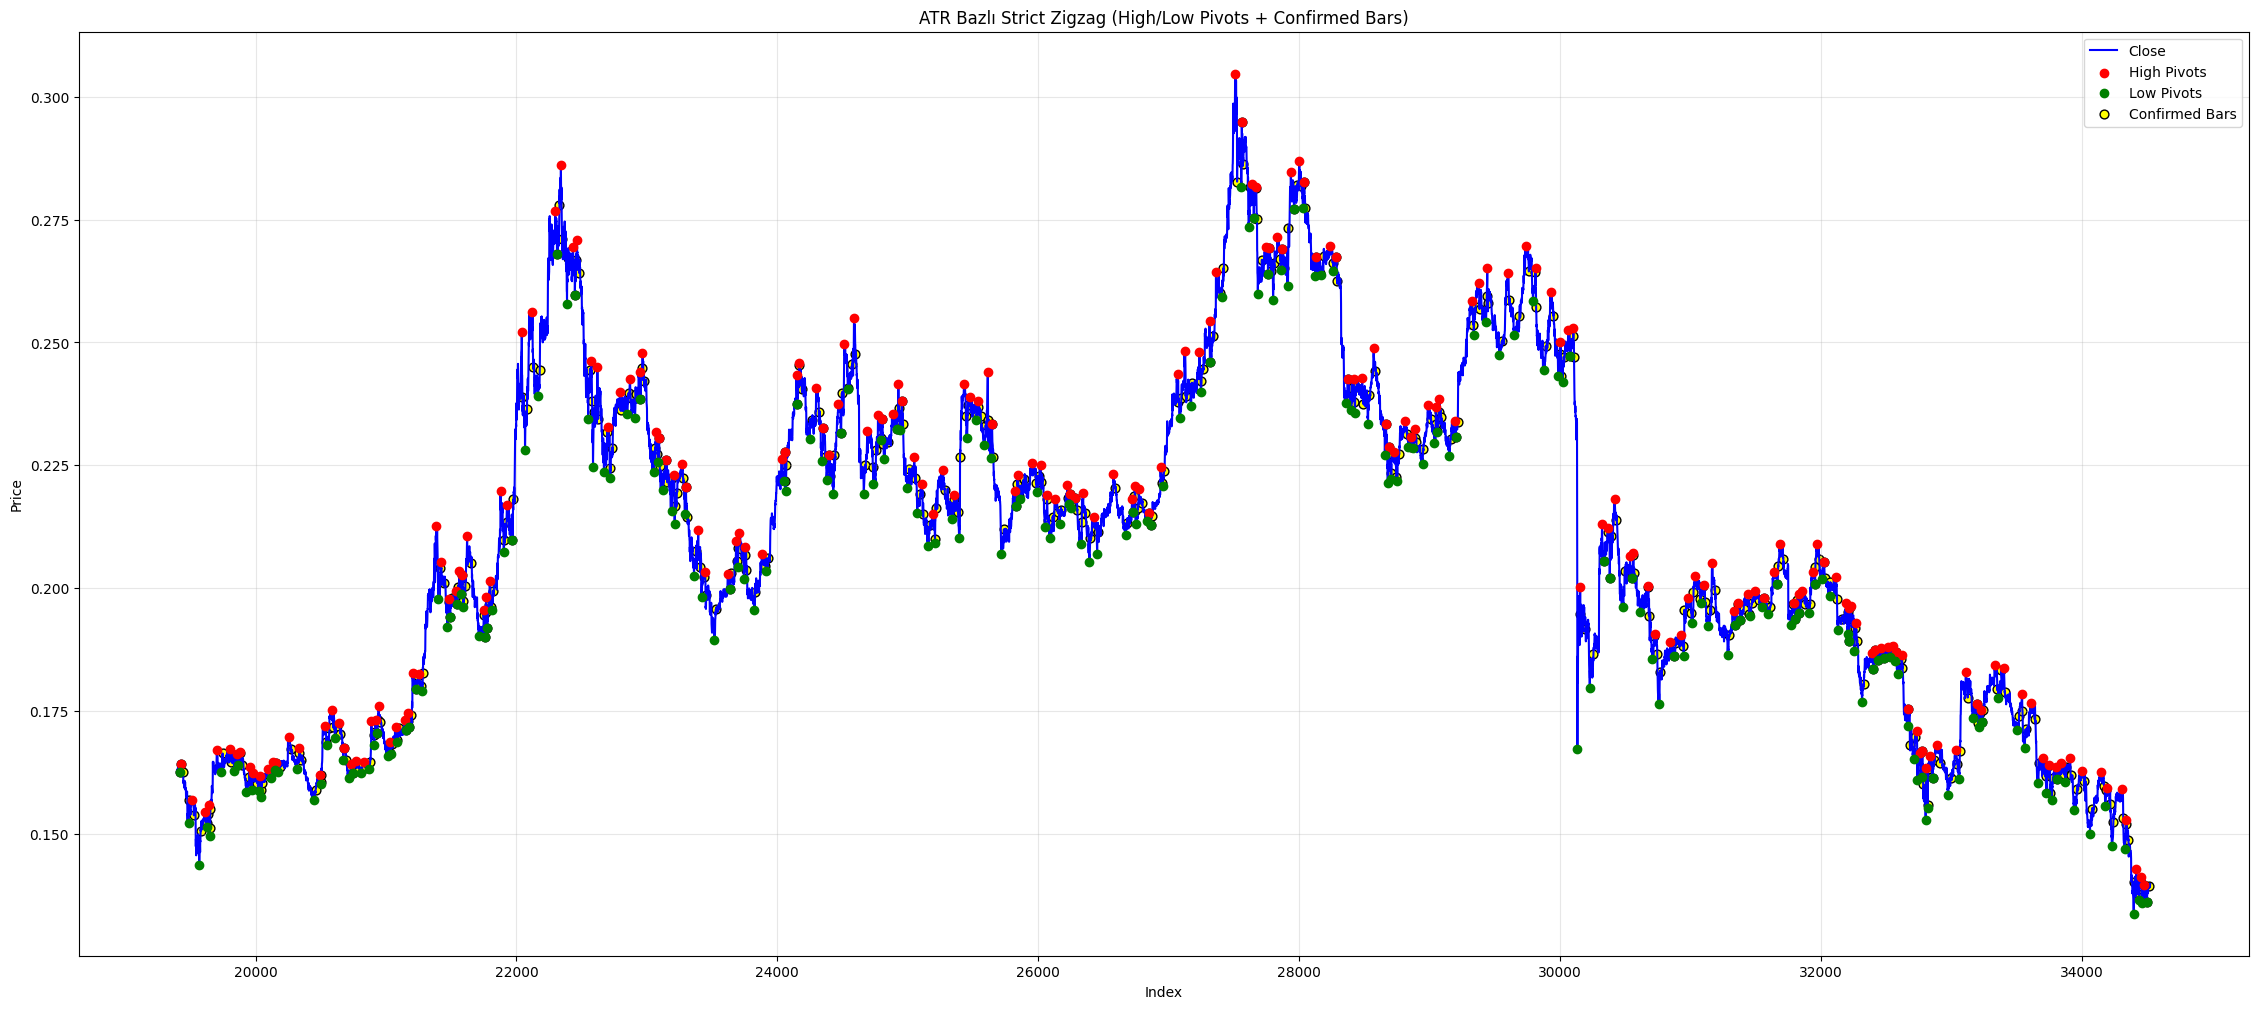

In [ ]:
df_z = df[df.index > 19400]

plt.figure(figsize=(28,12))
plt.plot(df_z["close"], label="Close", color="blue")

# Pivot noktaları
plt.scatter(df_z.index, df_z["high_pivot"], color="red", label="High Pivots", zorder=3)
plt.scatter(df_z.index, df_z["low_pivot"], color="green", label="Low Pivots", zorder=3)

# ✅ Confirmed satırları
confirmed = df_z[(df_z["high_pivot_confirmed"] == 1) | (df_z["low_pivot_confirmed"] == 1)]
plt.scatter(confirmed.index, confirmed["close"], color="yellow", edgecolors="black",
            label="Confirmed Bars", zorder=1, s=40, marker="o")

plt.title("ATR Bazlı Strict Zigzag (High/Low Pivots + Confirmed Bars)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
df[['high_pivot_filled', 'low_pivot_filled']].tail(200)

high_pivot_filled  low_pivot_filled
34326       0.1590800000      0.1475400000
34327       0.1590800000      0.1475400000
34328       0.1590800000      0.1475400000
34329       0.1590800000      0.1475400000
34330       0.1590800000      0.1469200000
...                  ...               ...
34521       0.1396900000      0.1362200000
34522       0.1396900000      0.1362200000
34523       0.1396900000      0.1362200000
34524       0.1396900000      0.1362200000
34525       0.1396900000      0.1362200000

[200 rows x 2 columns]

In [ ]:
# ATR Moves Analysis
def build_pivot_legs(df,
                     atr_col="atr",
                     high_pivot_col="high_pivot",
                     low_pivot_col="low_pivot",
                     high_col="high",
                     low_col="low",
                     close_col="close",
                     compute_entry_stats=True):
    """
    Zigzag pivotları (high_pivot/low_pivot) arasındaki her 'bacak' için
    ATR katını ve opsiyonel entry istatistiklerini hesaplar.

    Ayrıca df'teki tüm sütunları legs_df'e taşır (entry ve exit için ayrı sütunlar).
    """

    # 1) Pivotları sıraya koy
    pivots = []
    for idx, row in df.iterrows():
        if pd.notna(row.get(low_pivot_col, np.nan)):
            pivots.append({"type": "L", "idx": idx, "price": row[low_pivot_col], "atr": row[atr_col]})
        if pd.notna(row.get(high_pivot_col, np.nan)):
            pivots.append({"type": "H", "idx": idx, "price": row[high_pivot_col], "atr": row[atr_col]})
    pivots.sort(key=lambda x: x["idx"])

    # Aynı tip arka arkaya gelirse sonuncuyu tut
    cleaned = []
    for p in pivots:
        if not cleaned or cleaned[-1]["type"] != p["type"]:
            cleaned.append(p)
        else:
            cleaned[-1] = p
    pivots = cleaned

    legs = []
    for i in range(len(pivots) - 1):
        a = pivots[i]
        b = pivots[i + 1]

        start_idx   = a["idx"]
        end_idx     = b["idx"]
        start_type  = a["type"]
        end_type    = b["type"]
        direction   = "up" if start_type == "L" else "down"
        start_price = a["price"]
        end_price   = b["price"]
        start_atr   = a["atr"]
        bars        = int(end_idx - start_idx)
        move        = end_price - start_price
        move_abs    = abs(move)
        atr_mult    = move_abs / start_atr if (start_atr and start_atr > 0) else np.nan

        entry_idx = None
        entry_price = None
        bars_to_entry = None
        mfe_R = None
        triggered = False

        if compute_entry_stats and bars > 0 and (start_atr is not None) and start_atr > 0:
            # Entry kuralı: pivot + 1*ATR kırılması
            thresh = start_price + start_atr if direction == "up" else start_price - start_atr
            seg = df.loc[start_idx:end_idx]

            has_hl = (high_col in df.columns) and (low_col in df.columns)
            if direction == "up":
                hit = seg[seg[high_col] >= thresh] if has_hl else seg[seg[close_col] >= thresh]
            else:
                hit = seg[seg[low_col] <= thresh] if has_hl else seg[seg[close_col] <= thresh]

            if len(hit) > 0:
                entry_idx = hit.index[0]
                entry_price = thresh
                bars_to_entry = int(entry_idx - start_idx)
                triggered = True
                mfe_R = (end_price - entry_price) / start_atr if direction == "up" else (entry_price - end_price) / start_atr

        # df'teki entry ve exit satırlarını al
        entry_row = df.loc[start_idx].to_dict()
        exit_row = df.loc[end_idx].to_dict()

        # prefix ekle
        entry_prefixed = {f"entry_{k}": v for k, v in entry_row.items()}
        exit_prefixed = {f"exit_{k}": v for k, v in exit_row.items()}

        legs.append({
            "start_idx": start_idx,
            "end_idx": end_idx,
            "direction": direction,
            "start_type": start_type,
            "end_type": end_type,
            "start_price": start_price,
            "end_price": end_price,
            "start_atr": start_atr,
            "bars": bars,
            "price_move": move,
            "abs_move": move_abs,
            "atr_multiple": atr_mult,
            "entry_triggered": triggered,
            "entry_idx": entry_idx,
            "entry_price": entry_price,
            "bars_to_entry": bars_to_entry,
            "mfe_R_until_end_pivot": mfe_R,
            **entry_prefixed,
            **exit_prefixed
        })

    legs_df = pd.DataFrame(legs)
    return legs_df


In [ ]:
legs_df = build_pivot_legs(df)

In [ ]:
len(legs_df)

1013

In [ ]:

# 1) ATR katlarının dağılımı (up/down ayrı)
legs_df.groupby("direction")["atr_multiple"].describe([0.666,0.75])

count         mean          std          min          50%        66.6%          75%           max
direction                                                                                                           
down      507.0000000000 7.1844238466 5.9645608632 1.3623911387 5.5811564783 7.1800268842 8.4646317236 65.0062305759
up        506.0000000000 6.5931726095 5.0769768567 1.9807755918 5.1269893791 6.4343895466 7.5084900853 38.5762114006

In [ ]:
# ATR yüzdesi
legs_df['atr_pct_of_price'] = (legs_df['start_atr'] / legs_df['start_price']) * 100

# Ortalama ATR yüzdesi
avg_atr_pct = legs_df['atr_pct_of_price'].mean()
print(avg_atr_pct)


0.7333731879648214


In [ ]:
legs_df.tail()

start_idx  end_idx direction start_type end_type  start_price    end_price    start_atr  bars    price_move     abs_move  atr_multiple  entry_triggered  entry_idx  entry_price  bars_to_entry  mfe_R_until_end_pivot                entry_time   entry_open   entry_high    entry_low  entry_close        entry_volume     entry_rsi entry_cat_rsi  entry_rsi_40    entry_atr  entry_bb_middle  entry_bb_upper  entry_bb_lower  entry_bb_middle_200  entry_bb_upper_200  entry_bb_lower_200  entry_dc_upper_20  entry_dc_lower_20  entry_dc_middle_20  entry_dc_upper_50  entry_dc_lower_50  entry_dc_middle_50  entry_sma_20  entry_sma_50  entry_sma_200  entry_sma_200_4h  entry_sma_20_rate  entry_sma_50_rate  entry_sma_200_rate  entry_sma_20_slope entry_trend_13_50 entry_trend_50_200 entry_trend_4h_50_200  entry_ema_50  entry_ema_20  entry_ema_50_rate  entry_ema_20_rate     entry_nw  entry_nw_upper  entry_nw_lower  entry_supertrend entry_supertrend_direction  entry_supertrend_signal  entry_stoch_k  entry_stoch_d  entry_stoch_rsi_k  entry_stoch_rsi_d  entry_macd_line  entry_macd_signal  entry_macd_hist entry_candle  entry_candle_body  entry_candle_strength entry_candle_class   entry_volume_price  entry_volume_candle  entry_prev_close  entry_high_low  entry_high_prev_close  entry_low_prev_close     entry_tr  entry_prev_high  entry_prev_low  entry_up_move  entry_down_move    entry_+dm    entry_-dm  entry_tr_ema  entry_+dm_ema  entry_-dm_ema     entry_+di     entry_-di      entry_dx     entry_adx               entry_obv  entry_zigzag_high  entry_zigzag_low  entry_last_high  entry_last_low  entry_zigzag_position entry_high_trend entry_low_trend  entry_pct_atr      entry_x  entry_high_pivot  entry_low_pivot  entry_high_pivot_atr  entry_low_pivot_atr  entry_high_pivot_confirmed  entry_low_pivot_confirmed  entry_pivot_bars_ago  entry_high_pivot_filled  entry_low_pivot_filled  entry_high_pivot_atr_filled  entry_low_pivot_atr_filled  entry_high_pivot_confirmed_filled  entry_low_pivot_confirmed_filled  entry_pivot_bars_ago_filled                 exit_time    exit_open    exit_high     exit_low   exit_close         exit_volume      exit_rsi exit_cat_rsi   exit_rsi_40     exit_atr  exit_bb_middle  exit_bb_upper  exit_bb_lower  exit_bb_middle_200  exit_bb_upper_200  exit_bb_lower_200  exit_dc_upper_20  exit_dc_lower_20  exit_dc_middle_20  exit_dc_upper_50  exit_dc_lower_50  exit_dc_middle_50  exit_sma_20  exit_sma_50  exit_sma_200  exit_sma_200_4h  exit_sma_20_rate  exit_sma_50_rate  exit_sma_200_rate  exit_sma_20_slope exit_trend_13_50 exit_trend_50_200 exit_trend_4h_50_200  exit_ema_50  exit_ema_20  exit_ema_50_rate  exit_ema_20_rate      exit_nw  exit_nw_upper  exit_nw_lower  exit_supertrend exit_supertrend_direction  exit_supertrend_signal  exit_stoch_k  exit_stoch_d  exit_stoch_rsi_k  exit_stoch_rsi_d  exit_macd_line  exit_macd_signal  exit_macd_hist exit_candle  exit_candle_body  exit_candle_strength exit_candle_class    exit_volume_price  exit_volume_candle  exit_prev_close  exit_high_low  exit_high_prev_close  exit_low_prev_close      exit_tr  exit_prev_high  exit_prev_low  exit_up_move  exit_down_move     exit_+dm     exit_-dm  exit_tr_ema  exit_+dm_ema  exit_-dm_ema      exit_+di      exit_-di       exit_dx      exit_adx                exit_obv  exit_zigzag_high  exit_zigzag_low  exit_last_high  exit_last_low  exit_zigzag_position exit_high_trend exit_low_trend  exit_pct_atr       exit_x  exit_high_pivot  exit_low_pivot  exit_high_pivot_atr  exit_low_pivot_atr  exit_high_pivot_confirmed  exit_low_pivot_confirmed  exit_pivot_bars_ago  exit_high_pivot_filled  exit_low_pivot_filled  exit_high_pivot_atr_filled  exit_low_pivot_atr_filled  exit_high_pivot_confirmed_filled  exit_low_pivot_confirmed_filled  exit_pivot_bars_ago_filled  atr_pct_of_price
1008      34419    34441      down          H        L 0.1429000000 0.1365700000 0.0019120945    22 -0.0063300000 0.0063300000  3.3105059183             True      34422 0.1409879055              3           2.3105059

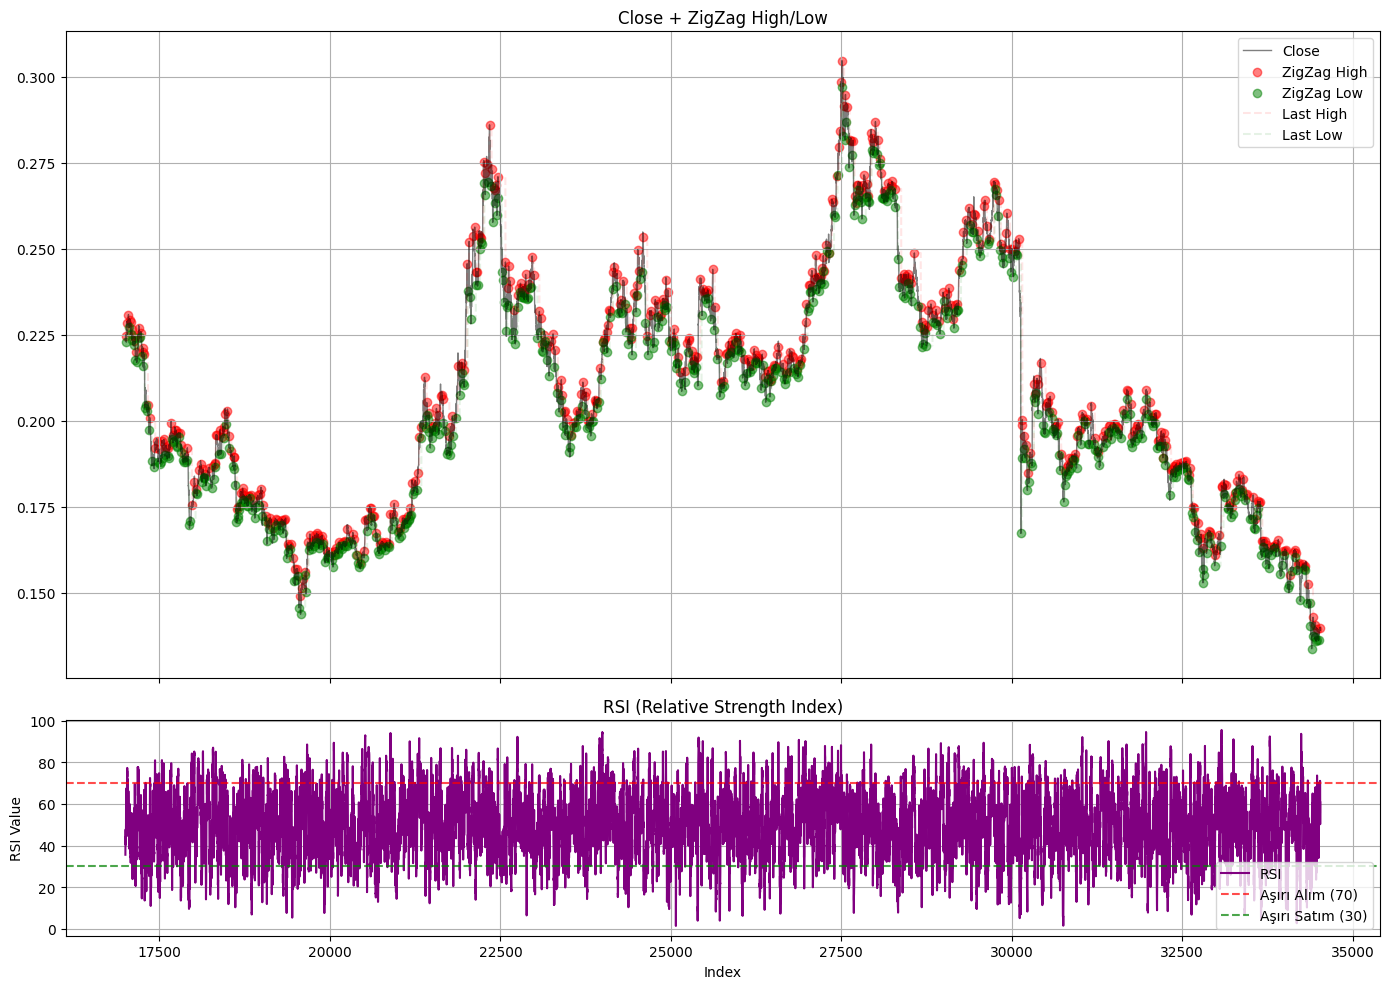

In [ ]:

# Filtre: 17000 sonrası
df_sub = df.loc[df.index >= 17000]

# İki alt grafik oluşturma
# sharex=True ile x eksenlerini senkronize ettik
# gridspec_kw ile alt grafiklerin boyut oranlarını belirledik (3'e 1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Üst grafik: Fiyat ve ZigZag ---
# Fiyat
ax1.plot(df_sub.index, df_sub["close"], label="Close", color="black", linewidth=1, alpha=0.5)

# zigzag pivotları
ax1.scatter(df_sub.index, df_sub["zigzag_high"], label="ZigZag High", color="red", marker="o", alpha=0.5)
ax1.scatter(df_sub.index, df_sub["zigzag_low"], label="ZigZag Low", color="green", marker="o", alpha=0.5)

# son pivot seviyeleri (referans çizgileri)
ax1.plot(df_sub.index, df_sub["last_high"], "--", color="red", alpha=0.1, label="Last High")
ax1.plot(df_sub.index, df_sub["last_low"], "--", color="green", alpha=0.1, label="Last Low")

ax1.set_title("Close + ZigZag High/Low")
ax1.legend()
ax1.grid(True)

# --- Alt grafik: RSI ---
ax2.plot(df_sub.index, df_sub["rsi"], label="RSI", color="purple")
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Aşırı Alım (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Aşırı Satım (30)')
ax2.set_title("RSI (Relative Strength Index)")
ax2.set_xlabel("Index")
ax2.set_ylabel("RSI Value")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

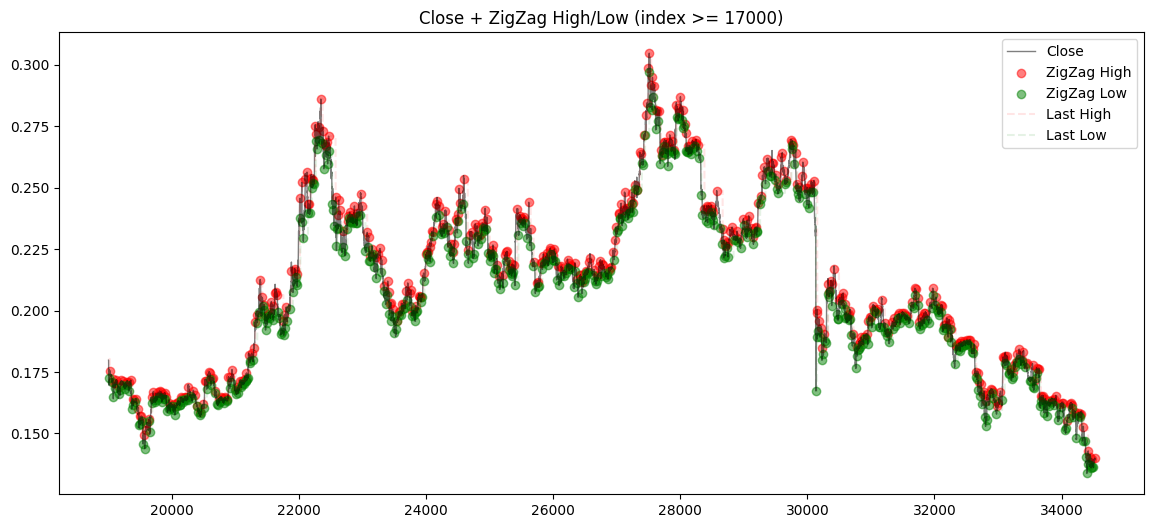

In [ ]:

# Filtre: 17000 sonrası
df_sub = df.loc[df.index >= 19000]

plt.figure(figsize=(14,6))

# fiyat
plt.plot(df_sub.index, df_sub["close"], label="Close", color="black", linewidth=1, alpha=0.5)

# zigzag pivotları
plt.scatter(df_sub.index, df_sub["zigzag_high"], label="ZigZag High", color="red", marker="o", alpha=0.5)
plt.scatter(df_sub.index, df_sub["zigzag_low"], label="ZigZag Low", color="green", marker="o", alpha=0.5)

# son pivot seviyeleri (referans çizgileri)
plt.plot(df_sub.index, df_sub["last_high"], "--", color="red", alpha=0.1, label="Last High")
plt.plot(df_sub.index, df_sub["last_low"], "--", color="green", alpha=0.1, label="Last Low")

plt.title("Close + ZigZag High/Low (index >= 17000)")
plt.legend()
plt.show()



In [ ]:
df["zigzag_position"].describe([0.01,0.05, 0.95, 0.99])

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count   34514.0000000000
mean                 NaN
std                  NaN
min                 -inf
1%       -380.1821206073
5%       -107.0833333333
50%        51.6865784858
95%       192.5798212005
99%       766.2441212871
max                  inf
Name: zigzag_position, dtype: float64

## Peaks-Valleys

In [ ]:
# Yerel zirveler (High)
peaks, _ = find_peaks(df['high'], distance=20)   # distance = en az kaç bar aralıklı olsun
df['local_high'] = np.nan
df.loc[peaks, 'local_high'] = df['high']

# Yerel dipler (Low) için High'ın -Low versiyonu
valleys, _ = find_peaks(-df['low'], distance=10)
df['local_low'] = np.nan
df.loc[valleys, 'local_low'] = df['low']

# NaN’leri son pivot değeriyle doldur
df['local_high'] = df['local_high'].ffill()
df['local_low']  = df['local_low'].ffill()

## Daily Analysis

In [ ]:
df['date'] = df['time'].dt.date  # gün bazında gruplamak için

# Her günün open fiyatını al
daily_open = df.groupby('date')['open'].first().rename('daily_open')
df = df.merge(daily_open, on='date', how='left')

# Günlük yön ve yüzde fark
df['daily_return_pct'] = (df['close'] - df['daily_open']) / df['daily_open'] * 100
df['daily_direction'] = df['daily_return_pct'].apply(lambda x: 'green' if x>0 else ('red' if x<0 else 'neutral'))

# Opsiyonel kategorik
def categorize(pct):
    if pct <= -2.5: return 'neg>2.5%'
    elif pct <= -1: return 'neg1-2.5%'
    elif pct < 0: return 'neg0-1%'
    elif pct < 1: return 'pos0-1%'
    elif pct < 2.5: return 'pos1-2.5%'
    else: return 'pos>2.5%'

df['daily_category'] = df['daily_return_pct'].apply(categorize)

In [ ]:
df['time']

0       2024-12-01 00:00:00+00:00
1       2024-12-01 00:15:00+00:00
2       2024-12-01 00:30:00+00:00
3       2024-12-01 00:45:00+00:00
4       2024-12-01 01:00:00+00:00
                   ...           
34521   2025-11-22 18:45:00+00:00
34522   2025-11-22 19:00:00+00:00
34523   2025-11-22 19:15:00+00:00
34524   2025-11-22 19:30:00+00:00
34525   2025-11-22 19:45:00+00:00
Name: time, Length: 34526, dtype: datetime64[ns, UTC]

In [ ]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'cat_rsi', 'rsi_40', 'atr',
       ...
       'high_pivot_confirmed_filled', 'low_pivot_confirmed_filled', 'pivot_bars_ago_filled', 'local_high', 'local_low', 'date', 'daily_open', 'daily_return_pct', 'daily_direction', 'daily_category'], dtype='object', length=105)

In [ ]:
df[['close','local_high','dc_upper_50', 'local_low', 'dc_lower_50', 'last_high','last_low']].tail(10)

close   local_high  dc_upper_50    local_low  dc_lower_50    last_high     last_low
34516 0.1390800000 0.1375100000 0.1401600000 0.1356300000 0.1354900000 0.1394300000 0.1362200000
34517 0.1390200000 0.1375100000 0.1401600000 0.1356300000 0.1354900000 0.1394300000 0.1362200000
34518 0.1391400000 0.1375100000 0.1401600000 0.1356300000 0.1354900000 0.1394300000 0.1362200000
34519 0.1392700000 0.1375100000 0.1401600000 0.1356300000 0.1354900000 0.1394300000 0.1362200000
34520 0.1391100000 0.1375100000 0.1401600000 0.1386500000 0.1354900000 0.1394300000 0.1362200000
34521 0.1396600000 0.1375100000 0.1401600000 0.1386500000 0.1354900000 0.1394300000 0.1362200000
34522 0.1398700000 0.1401800000 0.1401800000 0.1386500000 0.1354900000 0.1398700000 0.1362200000
34523 0.1393300000 0.1401800000 0.1401800000 0.1386500000 0.1354900000 0.1398700000 0.1362200000
34524 0.1392700000 0.1401800000 0.1401800000 0.1386500000 0.1354900000 0.1398700000 0.1362200000
34525 0.1398400000 0.1401800000 0.1401800000 0.1386500000 0.1354900000 0.1398700000 0.1362200000

In [ ]:
df['last_high'].value_counts()

last_high
0.1687000000    149
0.2285000000    146
0.1669400000    122
0.1786600000    112
0.2709300000    110
               ... 
0.2114400000      1
0.1647100000      1
0.2212200000      1
0.1730400000      1
0.1561600000      1
Name: count, Length: 1098, dtype: int64

In [ ]:
df.tail(5)

time         open         high          low        close             volume           rsi     cat_rsi        rsi_40          atr    bb_middle     bb_upper     bb_lower  bb_middle_200  bb_upper_200  bb_lower_200  dc_upper_20  dc_lower_20  dc_middle_20  dc_upper_50  dc_lower_50  dc_middle_50       sma_20       sma_50      sma_200   sma_200_4h  sma_20_rate  sma_50_rate  sma_200_rate  sma_20_slope trend_13_50 trend_50_200 trend_4h_50_200       ema_50       ema_20  ema_50_rate  ema_20_rate           nw     nw_upper     nw_lower   supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d    macd_line  macd_signal    macd_hist candle  candle_body  candle_strength    candle_class        volume_price    volume_candle   prev_close     high_low  high_prev_close  low_prev_close           tr    prev_high     prev_low       up_move     down_move          +dm          -dm       tr_ema      +dm_ema      -dm_ema           +di           -di            dx           adx                     obv  zigzag_high  zigzag_low    last_high     last_low  zigzag_position high_trend low_trend      pct_atr            x  high_pivot  low_pivot  high_pivot_atr  low_pivot_atr  high_pivot_confirmed  low_pivot_confirmed  pivot_bars_ago  high_pivot_filled  low_pivot_filled  high_pivot_atr_filled  low_pivot_atr_filled  high_pivot_confirmed_filled  low_pivot_confirmed_filled  pivot_bars_ago_filled   local_high    local_low        date   daily_open  daily_return_pct daily_direction daily_category
34521 2025-11-22 18:45:00+00:00 0.1391200000 0.1399500000 0.1390400000 0.1396600000 7223966.0000000000 55.7798165138   above_avg 58.1524482585 0.0008715739 0.1389185000 0.1400448406 0.1377921594   0.1417778000  0.1512975122  0.1322580878 0.1399500000 0.1363200000  0.1381350000 0.1401600000 0.1354900000  0.1378250000 0.1389185000 0.1381936000 0.1417778000 0.1547604625 1.0053376620 1.0106112005  0.9850625415  0.0000743564     uptrend    downtrend       downtrend 0.1385380252 0.1388532501 1.0080986776 1.0058100900 0.1391175949 0.1431224895 0.1351127004 0.1375930000              uptrend       0.0000000000 69.3714677831 59.0906438750 62.5689013996 59.9431440819 0.0002876755 0.0001609597 0.0001267158  green 0.0005400000     0.6195688212    weak_bullish 51725375.9129314050 27931.7029929836 0.1391100000 0.0009100000     0.0008400000    0.0000700000 0.0009100000 0.1393400000 0.1386500000  0.0006100000 -0.0003900000 0.0006100000 0.0000000000 0.0007514374 0.0001908817 0.0001175977 25.4022076466 15.6497017611 23.7565219895 21.1457158364 -13341214609.6000003815          NaN         NaN 0.1394300000 0.1362200000   107.1651090343       None      None 0.6240683644 0.0008715739         NaN        NaN             NaN            NaN                     0                    0             NaN       0.1396900000      0.1362200000           0.0011435999          0.0011421468                            1                           1          21.0000000000 0.1375100000 0.1386500000  2025-11-22 0.1402900000     -0.4490697840             red        neg0-1%
34522 2025-11-22 19:00:00+00:00 0.1396700000 0.1401800000 0.1394300000 0.1398700000 3226237.0000000000 71.1159737418  overbought 56.9126819127 0.0008628900 0.1390315000 0.1400537632 0.1380092368   0.1417327500  0.1512024928  0.1322630072 0.1401800000 0.1372900000  0.1387350000 0.1401800000 0.1354900000  0.1378350000 0.1390315000 0.1382110000 0.1417327500 0.1547327250 1.0060310074 1.0120033861  0.9868573072  0.0000805086     uptrend    downtrend       downtrend 0.1385902595 0.1389500834 1.0092339858 1.0066204822 0.1392094906 0.1431324795 0.1352865017 0.1379000000              uptrend       0.0000000000 73.0872420852 62.0206129490 64.3513346663 60.4941679049 0.0003303775 0.0001948432 0.0001355342  green 0.0002000000     0.2317792456    weak_bullish 23065968.3992278539  4613.1936798457 0.1396600000 0.0007500000     0.0005200000    0.0002300000 0.0007500000 0.1399500000 0.1390400000  0.0002300000 -0.00039000

In [ ]:
df['supertrend_signal'].value_counts()

supertrend_signal
0.0000000000    33650
1.0000000000      866
Name: count, dtype: int64

# Derivative Variables

## Donchian Channel Positions

In [ ]:
df['dc_position_ratio_20'] = (df['close'] - df['dc_lower_20']) / (df['dc_upper_20'] - df['dc_lower_20']) * 100

conditions = [
    (df['dc_position_ratio_20'] < 25),
    (df['dc_position_ratio_20'] >= 25) & (df['dc_position_ratio_20'] < 40),
    (df['dc_position_ratio_20'] >= 40) & (df['dc_position_ratio_20'] < 60),
    (df['dc_position_ratio_20'] >= 60) & (df['dc_position_ratio_20'] < 75),
    (df['dc_position_ratio_20'] >= 75)
]

choices = [
    '0-25',
    '25-40',
    '40-60',
    '60-75',
    '75-100'
]

df['dc_position_20'] = np.select(conditions, choices, default='Bilinmeyen')

df['dc_position_ratio_50'] = (df['close'] - df['dc_lower_50']) / (df['dc_upper_50'] - df['dc_lower_50']) * 100

conditions = [
    (df['dc_position_ratio_50'] < 25),
    (df['dc_position_ratio_50'] >= 25) & (df['dc_position_ratio_50'] < 40),
    (df['dc_position_ratio_50'] >= 40) & (df['dc_position_ratio_50'] < 60),
    (df['dc_position_ratio_50'] >= 60) & (df['dc_position_ratio_50'] < 75),
    (df['dc_position_ratio_50'] >= 75)
]

df['dc_position_50'] = np.select(conditions, choices, default='Bilinmeyen')



df['dc_breakout_20'] = df['high'] > df['dc_upper_20']
df['dc_breakdown_20'] = df['low'] < df['dc_lower_20']

df['dc_breakout_50'] = df['high'] > df['dc_upper_50']
df['dc_breakdown_50'] = df['low'] < df['dc_lower_50']

## BB Position

In [ ]:
def bb_position(row):
    if row['high'] > row['bb_upper']:
        return 'above_upper'
    elif row['close'] > row['bb_middle']:
        return 'above_middle'
    elif row['close'] > row['bb_lower']:
        return 'below_middle'
    else:
        return 'below_lower'

df['bb_position'] = df.apply(bb_position, axis=1)

def calculate_bb_percentage_position(row):
    # Eğer herhangi bir bant değeri NaN ise veya bant genişliği sıfırsa (hata önleme)
    if pd.isna(row['bb_upper']) or pd.isna(row['bb_lower']) or pd.isna(row['close']):
        return np.nan

    band_range = row['bb_upper'] - row['bb_lower']

    # Bant genişliği sıfırsa veya çok küçükse (bölme hatasını önlemek için)
    if band_range <= 0.00000000000000001: # Küçük bir eşik değeri kullan
        if row['close'] > row['bb_upper']:
            return 'above_100' # Üst bandın üzerinde
        elif row['close'] < row['bb_lower']:
            return 'below_0'   # Alt bandın altında
        else:
            return 'within_bands_narrow' # Bantlar aşırı dar veya çakışık

    # Yüzdelik konumu hesapla (Bollinger Band Percentage)
    bbp = ((row['close'] - row['bb_lower']) / band_range) * 100

    # Kategorilere ayırma
    if bbp >= 100:
        return 'above_100'       # Fiyat üst bandın üzerinde
    elif bbp >= 75:
        return '75-100'          # Üst bandın %75'i ile %100'ü arasında
    elif bbp >= 50:
        return '50-75'           # Ortalamanın üzeri, %50 ile %75 arasında
    elif bbp >= 25:
        return '25-50'           # Ortalamanın altı, %25 ile %50 arasında
    elif bbp >= 0:
        return '0-25'            # Alt bandın %0'ı ile %25'i arasında
    else:
        return 'below_0'         # Fiyat alt bandın altında

df['bb_position'] = df.apply(calculate_bb_percentage_position, axis=1)


## Stochastic Position & Cross

In [ ]:
def stoch_position(value):
    if value <= 20:
        return 'very_low'
    elif value <= 50:
        return 'low'
    elif value <= 80:
        return 'high'
    else:
        return 'very_high'

df['stoch_position'] = df['stoch_k'].apply(stoch_position)

df['stoch_cross_up'] = (df['stoch_k'] > df['stoch_d']) & (df['stoch_k'].shift(1) <= df['stoch_d'].shift(1))
df['stoch_cross_down'] = (df['stoch_k'] < df['stoch_d']) & (df['stoch_k'].shift(1) >= df['stoch_d'].shift(1))


## Nadaraya Watson Position

In [ ]:
def nw_position(row):
    if row['close'] > row['nw_upper']:
        return 'above_upper'
    elif row['close'] > row['nw']:
        return 'above_middle'
    elif row['close'] > row['nw_lower']:
        return 'below_middle'
    else:
        return 'below_lower'

df['nw_position'] = df.apply(nw_position, axis=1)


## ADX Position

In [ ]:
df['adx_category'] = None

# DataFrame üzerinde satır satır döngü yapalım
for index, row in df.iterrows():
    adx_value = row['adx']

    if pd.isna(adx_value): # Eğer ADX değeri NaN ise kategoriyi de NaN yap
        df.loc[index, 'adx_category'] = np.nan
    elif adx_value < 25:
        df.loc[index, 'adx_category'] = 'weak_trend'
    elif adx_value >= 25 and adx_value < 40: # 15 dahil, 30 hariç
        df.loc[index, 'adx_category'] = 'medium_trend'
    elif adx_value >= 40 and adx_value < 60: # 15 dahil, 30 hariç
        df.loc[index, 'adx_category'] = 'strong_trend'
    else: # adx_value >= 60
        df.loc[index, 'adx_category'] = 'super_strong_trend'

## SMA Cross

In [ ]:
# Fark hesapla
df['diff_50_200'] = df['sma_50'] - df['sma_200']

# Önceki fark
df['diff_50_200_prev'] = df['diff_50_200'].shift(1)

# Yönlü crossover
df['sma_cross_up'] = (df['diff_50_200'] > 0) & (df['diff_50_200_prev'] <= 0)
df['sma_cross_down'] = (df['diff_50_200'] < 0) & (df['diff_50_200_prev'] >= 0)

# Fark hesapla
df['diff_50_200_4h'] = df['sma_200'] - df['sma_200_4h']

# Önceki fark
df['diff_50_200_4h_prev'] = df['diff_50_200'].shift(1)

# Yönlü crossover
df['sma_cross_up_4h'] = (df['diff_50_200_4h'] > 0) & (df['diff_50_200_4h_prev'] <= 0)
df['sma_cross_down_4h'] = (df['diff_50_200_4h'] < 0) & (df['diff_50_200_4h_prev'] >= 0)


## BB - DC Width Rate

In [ ]:
df['bb_width_rate'] = df['bb_upper'] / df['bb_lower']
df['dc_50_width_rate'] = df['dc_upper_50'] / df['dc_lower_50']
df['dc_20_width_rate'] = df['dc_upper_20'] / df['dc_lower_20']

In [ ]:
def width_rate_position_np(df, col, low_width, high_width):
    conditions = [
        df[col] < low_width,
        df[col] > high_width
    ]
    choices = ['narrow', 'wide']
    df[col + '_position'] = np.select(conditions, choices, default='middle-wide')
    return df

In [ ]:
low_dc_width = df['dc_50_width_rate'].quantile(0.15)
high_dc_width = df['dc_50_width_rate'].quantile(0.85)
low_dc_width_20 = df['dc_20_width_rate'].quantile(0.15)
high_dc_width_20 = df['dc_20_width_rate'].quantile(0.85)
low_bb_width = df['bb_width_rate'].quantile(0.15)
high_bb_width = df['bb_width_rate'].quantile(0.85)

df = width_rate_position_np(df, 'dc_50_width_rate', low_dc_width, high_dc_width)
df = width_rate_position_np(df, 'dc_20_width_rate', low_dc_width_20, high_dc_width_20)
df = width_rate_position_np(df, 'bb_width_rate', low_bb_width, high_bb_width)

In [ ]:
low_pct_atr = df['pct_atr'].quantile(0.15)
high_pct_atr = df['pct_atr'].quantile(0.85)
df = width_rate_position_np(df, 'pct_atr', low_pct_atr, high_pct_atr)

# STRATEGIES

## BB Strategies - 1 Or 3 Touch - Trend or Not

In [ ]:
def bb_touch_signal(df, touch_count=1, trend_filter=False, trend_col='trend_50_200', trend_direction='uptrend'):
    """
    BB üst banda veya alt banda temas sayısına göre Long/Short sinyali.

    Params:
        df: DataFrame with BB bands & trend
        touch_count: int (1 veya 3)
        trend_filter: bool (True → trend şartı aranır)
        trend_col: str (ör. 'sma_trend')
        trend_direction: 'uptrend' veya 'downtrend'

    Returns:
        pd.Series: True where signal occurs
    """
    df['bb_touch_upper'] = df['high'] >= df['bb_upper']
    df['bb_touch_lower'] = df['low'] <= df['bb_lower']

    # Son 'touch_count' bardaki temas toplamı
    touch_upper = sum([df['bb_touch_upper'].shift(i+1) for i in range(touch_count)])
    touch_lower = sum([df['bb_touch_lower'].shift(i+1) for i in range(touch_count)])

    signal_long = touch_upper >= touch_count
    signal_short = touch_lower >= touch_count

    if trend_filter:
        signal_long = signal_long & (df[trend_col] == trend_direction)
        signal_short = signal_short & (df[trend_col] != trend_direction)

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)


## DC Strategies - Trend or Not

In [ ]:
def dc_breakout_signal(df, dc_upper='dc_upper_20', dc_lower='dc_lower_20',
                       trend_filter=False, trend_col='trend_50_200', trend_direction='uptrend'):
    """
    DC breakout sinyali.

    Params:
        dc_upper: Üst kanal kolonu
        dc_lower: Alt kanal kolonu
        trend_filter: Trend filtresi kullanılacak mı?
        trend_col: Trend kolonu ismi
        trend_direction: Beklenen trend yönü ('uptrend' veya 'downtrend')

    Returns:
        long_signal, short_signal: pd.Series (bool)
    """
    # DC breakout: şu anki high, bir önceki üst bandın üstüne çıktı mı?
    breakout_upper = df['high'] > df[dc_upper].shift(1)
    breakout_lower = df['low'] < df[dc_lower].shift(1)

    signal_long = breakout_upper
    signal_short = breakout_lower

    if trend_filter:
        signal_long &= (df[trend_col] == trend_direction)
        signal_short &= (df[trend_col] != trend_direction)

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)



## NW Strategies



In [ ]:
def nw_breakout_signal(df, band_ratio=0.2):
    """
    Nadaraya-Watson breakout sinyali.
    NW bandının belirli bir oran üzerinde aşılması durumunda long/short sinyali üretir.

    Args:
        df (pd.DataFrame): Fiyat verisi içeren DataFrame.
        band_ratio (float): Band genişliğinin yüzdesi. Örn. 0.2 → %20

    Returns:
        pd.Series: signal_long, signal_short
    """
    band_width = df['nw_upper'] - df['nw_lower']

    excess_upper = df['high'] > df['nw_upper'].shift(1) + band_ratio * band_width.shift(1)
    excess_lower = df['low'] < df['nw_lower'].shift(1) - band_ratio * band_width.shift(1)

    signal_long = excess_lower
    signal_short = excess_upper

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)



## MACD - Stochastic and Two Dots Signal

In [ ]:
def macd_signal_generator_bool(macd_df):
    """
    MACD göstergelerine göre True/False alım/satım sinyalleri üretir.

    Args:
        macd_df (pd.DataFrame): 'macd_line' ve 'macd_signal' sütunlarını içeren MACD DataFrame'i.

    Returns:
        tuple: (macd_long_signal, macd_short_signal)
               macd_long_signal (pd.Series): Long sinyallerini içeren Series (True/False).
               macd_short_signal (pd.Series): Short sinyallerini içeren Series (True/False).
    """
    # Long sinyali (MACD çizgisi sinyal çizgisini yukarı keser)
    long_signals = (macd_df['macd_line'] > macd_df['macd_signal']) & \
                   (macd_df['macd_line'].shift(1) <= macd_df['macd_signal'].shift(1))

    # Short sinyali (MACD çizgisi sinyal çizgisini aşağı keser)
    short_signals = (macd_df['macd_line'] < macd_df['macd_signal']) & \
                    (macd_df['macd_line'].shift(1) >= macd_df['macd_signal'].shift(1))

    return long_signals, short_signals

In [ ]:
def stoch_signal_generator_bool(stoch_df):
    """
    Stokastik göstergelere göre True/False alım/satım sinyalleri üretir.

    Args:
        stoch_df (pd.DataFrame): 'stoch_k' ve 'stoch_d' sütunlarını içeren Stokastik DataFrame'i.

    Returns:
        tuple: (stoch_long_signal, stoch_short_signal)
               stoch_long_signal (pd.Series): Long sinyallerini içeren Series (True/False).
               stoch_short_signal (pd.Series): Short sinyallerini içeren Series (True/False).
    """
    # Yukarı kesişim (long sinyali)
    stoch_cross_up = (stoch_df['stoch_k'] > stoch_df['stoch_d']) & \
                     (stoch_df['stoch_k'].shift(1) <= stoch_df['stoch_d'].shift(1))

    # Aşağı kesişim (short sinyali)
    stoch_cross_down = (stoch_df['stoch_k'] < stoch_df['stoch_d']) & \
                       (stoch_df['stoch_k'].shift(1) >= stoch_df['stoch_d'].shift(1))

    return stoch_cross_up, stoch_cross_down

In [ ]:
def two_dots_signal_bool(macd_signals, stoch_signals, window=5):
    """
    MACD ve Stokastik sinyallerini birleştirerek yeni bir True/False sinyal üretir.
    Her iki sinyal de belirli bir pencere içinde aynı yönde ise True sinyal üretir.

    Args:
        macd_signals (tuple): macd_signal_generator_bool'dan dönen (long_signals, short_signals) tuple'ı.
        stoch_signals (tuple): stoch_signal_generator_bool'dan dönen (long_signals, short_signals) tuple'ı.
        window (int): İki sinyalin aynı yönde oluşması için bakılacak geçmiş veri birimi sayısı.

    Returns:
        tuple: (two_dots_long_signal, two_dots_short_signal)
               two_dots_long_signal (pd.Series): Birleşik long sinyallerini içeren Series (True/False).
               two_dots_short_signal (pd.Series): Birleşik short sinyallerini içeren Series (True/False).
    """
    # Gelen sinyalleri ayır
    macd_long_signal, macd_short_signal = macd_signals
    stoch_long_signal, stoch_short_signal = stoch_signals

    combined_long_signals = pd.Series(False, index=macd_long_signal.index)
    combined_short_signals = pd.Series(False, index=macd_long_signal.index)

    for i in range(len(macd_long_signal)):
        # Long sinyali için pencere kontrolü
        long_conditions_met = False
        for j in range(max(0, i - window + 1), i + 1):
            if macd_long_signal.iloc[j] and stoch_long_signal.iloc[j]:
                long_conditions_met = True
                break

        if long_conditions_met:
            combined_long_signals.iloc[i] = True

        # Short sinyali için pencere kontrolü
        short_conditions_met = False
        for j in range(max(0, i - window + 1), i + 1):
            if macd_short_signal.iloc[j] and stoch_short_signal.iloc[j]:
                short_conditions_met = True
                break

        if short_conditions_met:
            combined_short_signals.iloc[i] = True

    return combined_long_signals, combined_short_signals


In [ ]:
# MACD Sinyallerini al
long_macd_signal, short_macd_signal = macd_signal_generator_bool(df)
df['macd_long_signal'] = long_macd_signal
df['macd_short_signal'] = short_macd_signal

# Stokastik Sinyallerini al
long_stoch_signal, short_stoch_signal = stoch_signal_generator_bool(df)
df['stoch_long_signal'] = long_stoch_signal
df['stoch_short_signal'] = short_stoch_signal

two_dots_long, two_dots_short = two_dots_signal_bool(
    (df['macd_long_signal'], df['macd_short_signal']),
    (df['stoch_long_signal'], df['stoch_short_signal']),
    window=5
)

df['two_dots_long'] = two_dots_long
df['two_dots_short'] = two_dots_short


## Pivot Breakout Signals

In [ ]:
def pivot_breakout_signal_fixed(df, high_pivot='high_pivot_filled', low_pivot='low_pivot_filled',
                                  breakout_col='close', breakdown_col='close',
                                  trend_filter=False, trend_col='trend_13_50', trend_direction='uptrend'):
    """
    DÜZELTİLMİŞ VERSİYON: Kırılan pivot'u doğru takip eder
    """

    signal_long = pd.Series(False, index=df.index)
    signal_short = pd.Series(False, index=df.index)

    last_signal = None
    last_high_pivot_used = None  # Kırılan pivot değeri
    last_low_pivot_used = None

    for i in range(1, len(df)):  # 0'dan değil 1'den başla (shift için)
        # ÖNCEKİ bar'ın pivot değerleri (bunlar kırılıyor)
        prev_high_pivot = df[high_pivot].iloc[i-1]
        prev_low_pivot = df[low_pivot].iloc[i-1]

        # ŞİMDİKİ bar'ın fiyatı
        current_close = df[breakout_col].iloc[i]

        # LONG: Close > önceki high_pivot
        if current_close > prev_high_pivot:
            # Son sinyal short MI veya farklı bir pivot mı kırıldı?
            if last_signal == 'short' or prev_high_pivot != last_high_pivot_used:
                signal_long.iloc[i] = True
                last_signal = 'long'
                last_high_pivot_used = prev_high_pivot  # Kırılan pivot'u kaydet

        # SHORT: Close < önceki low_pivot
        if current_close < prev_low_pivot:
            # Son sinyal long MU veya farklı bir pivot mı kırıldı?
            if last_signal == 'long' or prev_low_pivot != last_low_pivot_used:
                signal_short.iloc[i] = True
                last_signal = 'short'
                last_low_pivot_used = prev_low_pivot  # Kırılan pivot'u kaydet

    if trend_filter:
        signal_long &= (df[trend_col] == trend_direction)
        signal_short &= (df[trend_col] != trend_direction)

    return signal_long, signal_short

In [ ]:
df['pivot_breakout'] = False
df['pivot_breakdown'] = False

In [ ]:
pivot_long, pivot_short = pivot_breakout_signal_fixed(df)
df['pivot_breakout'] = pivot_long
df['pivot_breakdown'] = pivot_short

In [ ]:
df['pivot_breakdown'].value_counts()

pivot_breakdown
False    34273
True       253
Name: count, dtype: int64

In [ ]:
# DC 20 breakout
long_dc20, short_dc20 = dc_breakout_signal(df, 'dc_upper_20', 'dc_lower_20',trend_col='trend_13_50', trend_filter=True)
df['dc_breakout_20'] = long_dc20
df['dc_breakdown_20'] = short_dc20
# DC 50 breakout
long_dc50, short_dc50 = dc_breakout_signal(df, 'dc_upper_50', 'dc_lower_50', trend_col='trend_13_50', trend_filter=True)
df['dc_breakout_50'] = long_dc50
df['dc_breakdown_50'] = short_dc50


# BB bir kere temas long/short
long1, short1 = bb_touch_signal(df, touch_count=1, trend_filter=True)
df['bb_1_touch_long'] = long1
df['bb_1_touch_short'] = short1
# BB üç kere temas long/short
long3, short3 = bb_touch_signal(df, touch_count=3, trend_filter=True)
df['bb_3_touch_long'] = long3
df['bb_3_touch_short'] = short3


# NW signal
long_nw, short_nw = nw_breakout_signal(df, band_ratio=0.2)
df['nw_long'] = long_nw
df['nw_short'] = short_nw




# Signals

## BB.ELF Signal

In [ ]:
# Long tarafı için
no_long_touch_last_10 = df['bb_3_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_long_clean'] = df['bb_3_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_3_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_short_clean'] = df['bb_3_touch_short'] & no_short_touch_last_10

# Long tarafı için
no_long_touch_last_10 = df['bb_1_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_long_clean'] = df['bb_1_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_1_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_short_clean'] = df['bb_1_touch_short'] & no_short_touch_last_10

## DC Clean Signal

In [ ]:
#20
df['dc_breakout_clean_20'] = df['dc_breakout_20'] & (
    df['dc_breakout_20'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_20'] = df['dc_breakdown_20'] & (
    df['dc_breakdown_20'].shift(1).rolling(window=10).sum() == 0
)

#55
df['dc_breakout_clean_50'] = df['dc_breakout_50'] & (
    df['dc_breakout_50'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_50'] = df['dc_breakdown_50'] & (
    df['dc_breakdown_50'].shift(1).rolling(window=10).sum() == 0
)

## NW Clean Signal

In [ ]:
# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_long = df['nw_long'] & df['nw_long'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_long_in_next_5 = (df['nw_long'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_long_clean'] = consecutive_nw_long & no_nw_long_in_next_5

# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_short = df['nw_short'] & df['nw_short'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_short_in_next_5 = (df['nw_short'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_short_clean'] = consecutive_nw_short & no_nw_short_in_next_5

## Pivot Signals

In [ ]:
df['pivot_up'] = False
df['pivot_down'] = False
df.loc[(df['low_pivot_confirmed']) & (df['trend_13_50']== 'uptrend'), 'pivot_up'] = True
df.loc[(df['high_pivot_confirmed']) & (df['trend_13_50']== 'downtrend'), 'pivot_down'] = True

In [ ]:
len(df.columns)

162

### DC - BB Pivot Atr

In [ ]:
df[['high_pivot_filled', 'dc_breakdown_clean_50', 'high_pivot_atr_filled','low_pivot_filled', 'dc_breakout_clean_50', 'low_pivot_atr_filled' ]]

high_pivot_filled  dc_breakdown_clean_50  high_pivot_atr_filled  low_pivot_filled  dc_breakout_clean_50  low_pivot_atr_filled
0           0.4232100000                  False           0.0033200000               NaN                 False                   NaN
1           0.4232100000                  False           0.0033200000               NaN                 False                   NaN
2           0.4232100000                  False           0.0033200000               NaN                 False                   NaN
3           0.4232100000                  False           0.0033200000               NaN                 False                   NaN
4           0.4232100000                  False           0.0033200000               NaN                 False                   NaN
...                  ...                    ...                    ...               ...                   ...                   ...
34521       0.1396900000                  False           0.0011435999      0.1362200000                 False          0.0011421468
34522       0.1396900000                  False           0.0011435999      0.1362200000                  True          0.0011421468
34523       0.1396900000                  False           0.0011435999      0.1362200000                 False          0.0011421468
34524       0.1396900000                  False           0.0011435999      0.1362200000                 False          0.0011421468
34525       0.1396900000                  False           0.0011435999      0.1362200000                 False          0.0011421468

[34526 rows x 6 columns]

In [ ]:
df.loc[df['dc_breakout_clean_50']  ,'dc50_long_pivot_atr'] = (df['close'] - df['low_pivot_filled']) / df['low_pivot_atr_filled']
df.loc[df['dc_breakdown_clean_50']  ,'dc50_short_pivot_atr'] = (df['high_pivot_filled'] - df['close']) / df['high_pivot_atr_filled']
df.loc[df['bb_3_touch_long_clean']  ,'bb3_long_pivot_atr'] = (df['close'] - df['low_pivot_filled']) / df['low_pivot_atr_filled']
df.loc[df['bb_3_touch_short_clean']  ,'bb3_short_pivot_atr'] = (df['high_pivot_filled'] - df['close']) / df['high_pivot_atr_filled']

### Determining 'X' Atr




In [ ]:
df['pct_atr'].describe([0.05,0.1,0.15,0.2,0.65,0.7,0.75, 0.8,0.85,0.9,0.95,0.99])

count   34526.0000000000
mean        0.7100368594
std         0.3560060501
min         0.1837450622
5%          0.3441610391
10%         0.3924714252
15%         0.4343708329
20%         0.4655738215
50%         0.6318548871
65%         0.7409063086
70%         0.7842268770
75%         0.8332970492
80%         0.8954232600
85%         0.9837751196
90%         1.1128270492
95%         1.3065520923
99%         1.8765947442
max         8.5286907303
Name: pct_atr, dtype: float64

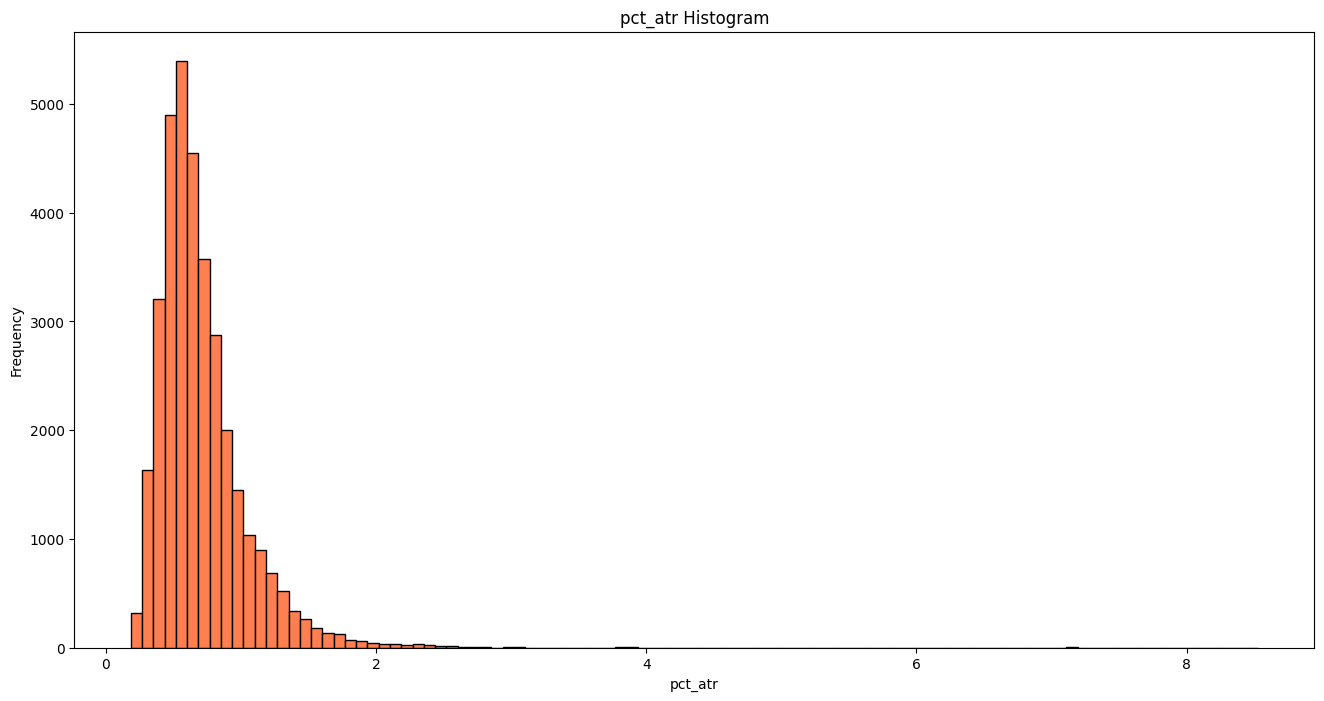

In [ ]:
plt.figure(figsize=(16, 8))
plt.hist(df['pct_atr'], bins=100, color='coral', edgecolor='black')

plt.title('pct_atr Histogram')
plt.xlabel('pct_atr')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# It determined according to percent atr levels.
"""df['x'] = np.minimum(
    np.maximum(df['close'] * df['pct_atr'].quantile(0.1)/100, 1 * df['atr']),
    df['close'] * df['pct_atr'].quantile(0.9)/100)"""

x_levels = [-6, -3, -2, 2, 3, 6]

for level in x_levels:
    df[f'target_{level}x'] = df['close'] + level * df['x']


In [ ]:
df

time         open         high          low        close               volume           rsi     cat_rsi        rsi_40          atr    bb_middle     bb_upper     bb_lower  bb_middle_200  bb_upper_200  bb_lower_200  dc_upper_20  dc_lower_20  dc_middle_20  dc_upper_50  dc_lower_50  dc_middle_50       sma_20       sma_50      sma_200   sma_200_4h  sma_20_rate  sma_50_rate  sma_200_rate  sma_20_slope trend_13_50 trend_50_200 trend_4h_50_200       ema_50       ema_20  ema_50_rate  ema_20_rate           nw     nw_upper     nw_lower   supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d    macd_line  macd_signal    macd_hist candle  candle_body  candle_strength    candle_class         volume_price      volume_candle   prev_close     high_low  high_prev_close  low_prev_close           tr    prev_high     prev_low       up_move     down_move          +dm          -dm       tr_ema      +dm_ema      -dm_ema           +di           -di            dx           adx                     obv  zigzag_high  zigzag_low    last_high     last_low  zigzag_position high_trend low_trend      pct_atr            x   high_pivot  low_pivot  high_pivot_atr  low_pivot_atr  high_pivot_confirmed  low_pivot_confirmed  pivot_bars_ago  high_pivot_filled  low_pivot_filled  high_pivot_atr_filled  low_pivot_atr_filled  high_pivot_confirmed_filled  low_pivot_confirmed_filled  pivot_bars_ago_filled   local_high    local_low        date   daily_open  daily_return_pct daily_direction daily_category  dc_position_ratio_20 dc_position_20  dc_position_ratio_50 dc_position_50  dc_breakout_20  dc_breakdown_20  dc_breakout_50  dc_breakdown_50 bb_position stoch_position  stoch_cross_up  stoch_cross_down   nw_position adx_category   diff_50_200  diff_50_200_prev  sma_cross_up  sma_cross_down  diff_50_200_4h  diff_50_200_4h_prev  sma_cross_up_4h  sma_cross_down_4h  bb_width_rate  dc_50_width_rate  dc_20_width_rate dc_50_width_rate_position dc_20_width_rate_position bb_width_rate_position pct_atr_position  macd_long_signal  macd_short_signal  stoch_long_signal  stoch_short_signal  two_dots_long  two_dots_short  pivot_breakout  pivot_breakdown  bb_touch_upper  bb_touch_lower  bb_1_touch_long  bb_1_touch_short  bb_3_touch_long  bb_3_touch_short  nw_long  nw_short  bb_3_touch_long_clean  bb_3_touch_short_clean  bb_1_touch_long_clean  bb_1_touch_short_clean  dc_breakout_clean_20  dc_breakdown_clean_20  dc_breakout_clean_50  dc_breakdown_clean_50  nw_long_clean  nw_short_clean  pivot_up  pivot_down  dc50_long_pivot_atr  dc50_short_pivot_atr  bb3_long_pivot_atr  bb3_short_pivot_atr   target_-6x   target_-3x   target_-2x    target_2x    target_3x    target_6x
0     2024-12-01 00:00:00+00:00 0.4216000000 0.4241800000 0.4208600000 0.4232100000  17630066.0000000000           NaN         NaN           NaN 0.0033200000          NaN          NaN          NaN            NaN           NaN           NaN          NaN          NaN           NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN          NaN           NaN           NaN   downtrend    downtrend       downtrend 0.4232100000 0.4232100000 1.0000000000 1.0000000000          NaN          NaN          NaN          NaN              uptrend                NaN           NaN           NaN           NaN           NaN 0.0000000000 0.0000000000 0.0000000000  green 0.0016100000     0.4849397590    weak_bullish  41657961.7683892176   67069.3184471067          NaN 0.0033200000              NaN             NaN 0.0033200000          NaN          NaN           NaN           NaN 0.0000000000 0.0000000000          NaN          NaN          NaN           NaN           NaN           NaN           NaN            0.0000000000          NaN         NaN          NaN          NaN              NaN       None      None 0.7844805179 0.0033200000 0.4232100000        NaN    0.0033200000            NaN                     0                    0             NaN  

In [ ]:
df

time         open         high          low        close               volume           rsi     cat_rsi        rsi_40          atr    bb_middle     bb_upper     bb_lower  bb_middle_200  bb_upper_200  bb_lower_200  dc_upper_20  dc_lower_20  dc_middle_20  dc_upper_50  dc_lower_50  dc_middle_50       sma_20       sma_50      sma_200   sma_200_4h  sma_20_rate  sma_50_rate  sma_200_rate  sma_20_slope trend_13_50 trend_50_200 trend_4h_50_200       ema_50       ema_20  ema_50_rate  ema_20_rate           nw     nw_upper     nw_lower   supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d    macd_line  macd_signal    macd_hist candle  candle_body  candle_strength    candle_class         volume_price      volume_candle   prev_close     high_low  high_prev_close  low_prev_close           tr    prev_high     prev_low       up_move     down_move          +dm          -dm       tr_ema      +dm_ema      -dm_ema           +di           -di            dx           adx                     obv  zigzag_high  zigzag_low    last_high     last_low  zigzag_position high_trend low_trend      pct_atr            x   high_pivot  low_pivot  high_pivot_atr  low_pivot_atr  high_pivot_confirmed  low_pivot_confirmed  pivot_bars_ago  high_pivot_filled  low_pivot_filled  high_pivot_atr_filled  low_pivot_atr_filled  high_pivot_confirmed_filled  low_pivot_confirmed_filled  pivot_bars_ago_filled   local_high    local_low        date   daily_open  daily_return_pct daily_direction daily_category  dc_position_ratio_20 dc_position_20  dc_position_ratio_50 dc_position_50  dc_breakout_20  dc_breakdown_20  dc_breakout_50  dc_breakdown_50 bb_position stoch_position  stoch_cross_up  stoch_cross_down   nw_position adx_category   diff_50_200  diff_50_200_prev  sma_cross_up  sma_cross_down  diff_50_200_4h  diff_50_200_4h_prev  sma_cross_up_4h  sma_cross_down_4h  bb_width_rate  dc_50_width_rate  dc_20_width_rate dc_50_width_rate_position dc_20_width_rate_position bb_width_rate_position pct_atr_position  macd_long_signal  macd_short_signal  stoch_long_signal  stoch_short_signal  two_dots_long  two_dots_short  pivot_breakout  pivot_breakdown  bb_touch_upper  bb_touch_lower  bb_1_touch_long  bb_1_touch_short  bb_3_touch_long  bb_3_touch_short  nw_long  nw_short  bb_3_touch_long_clean  bb_3_touch_short_clean  bb_1_touch_long_clean  bb_1_touch_short_clean  dc_breakout_clean_20  dc_breakdown_clean_20  dc_breakout_clean_50  dc_breakdown_clean_50  nw_long_clean  nw_short_clean  pivot_up  pivot_down  dc50_long_pivot_atr  dc50_short_pivot_atr  bb3_long_pivot_atr  bb3_short_pivot_atr   target_-6x   target_-3x   target_-2x    target_2x    target_3x    target_6x
0     2024-12-01 00:00:00+00:00 0.4216000000 0.4241800000 0.4208600000 0.4232100000  17630066.0000000000           NaN         NaN           NaN 0.0033200000          NaN          NaN          NaN            NaN           NaN           NaN          NaN          NaN           NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN          NaN           NaN           NaN   downtrend    downtrend       downtrend 0.4232100000 0.4232100000 1.0000000000 1.0000000000          NaN          NaN          NaN          NaN              uptrend                NaN           NaN           NaN           NaN           NaN 0.0000000000 0.0000000000 0.0000000000  green 0.0016100000     0.4849397590    weak_bullish  41657961.7683892176   67069.3184471067          NaN 0.0033200000              NaN             NaN 0.0033200000          NaN          NaN           NaN           NaN 0.0000000000 0.0000000000          NaN          NaN          NaN           NaN           NaN           NaN           NaN            0.0000000000          NaN         NaN          NaN          NaN              NaN       None      None 0.7844805179 0.0033200000 0.4232100000        NaN    0.0033200000            NaN                     0                    0             NaN  

# Target and Results

In [ ]:
def calculate_bars_to_hit_updated(df, max_bars=100, verbose=True):
    for i in range(len(df)):
        entry = df.loc[i, 'close']
        x = df.loc[i, 'x']
        for level in x_levels:
            target_price = entry + level * x
            for j in range(1, max_bars + 1):
                if i + j >= len(df):
                    break
                high = df.loc[i + j, 'high']
                low = df.loc[i + j, 'low']
                if (level > 0 and high >= target_price) or (level < 0 and low <= target_price):
                    df.at[i, f'{level}x_bar'] = j
                    break

    # Inform per 1000 rows.
        if verbose and i % 1000 == 0 and i != 0:
            print(f"{i} satır tamamlandı...")

    return df


In [ ]:
#x_levels = [ -4, -2,  2,  4 ]
#x_levels = [ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5 ]
x_levels = [-3, 3]
#x_levels = [-6, -3, 3, 6]
df = calculate_bars_to_hit_updated(df)


1000 satır tamamlandı...
2000 satır tamamlandı...
3000 satır tamamlandı...
4000 satır tamamlandı...
5000 satır tamamlandı...
6000 satır tamamlandı...
7000 satır tamamlandı...
8000 satır tamamlandı...
9000 satır tamamlandı...
10000 satır tamamlandı...
11000 satır tamamlandı...
12000 satır tamamlandı...
13000 satır tamamlandı...
14000 satır tamamlandı...
15000 satır tamamlandı...
16000 satır tamamlandı...
17000 satır tamamlandı...
18000 satır tamamlandı...
19000 satır tamamlandı...
20000 satır tamamlandı...
21000 satır tamamlandı...
22000 satır tamamlandı...
23000 satır tamamlandı...
24000 satır tamamlandı...
25000 satır tamamlandı...
26000 satır tamamlandı...
27000 satır tamamlandı...
28000 satır tamamlandı...
29000 satır tamamlandı...
30000 satır tamamlandı...
31000 satır tamamlandı...
32000 satır tamamlandı...
33000 satır tamamlandı...
34000 satır tamamlandı...


In [ ]:
df.tail()

time         open         high          low        close             volume           rsi     cat_rsi        rsi_40          atr    bb_middle     bb_upper     bb_lower  bb_middle_200  bb_upper_200  bb_lower_200  dc_upper_20  dc_lower_20  dc_middle_20  dc_upper_50  dc_lower_50  dc_middle_50       sma_20       sma_50      sma_200   sma_200_4h  sma_20_rate  sma_50_rate  sma_200_rate  sma_20_slope trend_13_50 trend_50_200 trend_4h_50_200       ema_50       ema_20  ema_50_rate  ema_20_rate           nw     nw_upper     nw_lower   supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d    macd_line  macd_signal    macd_hist candle  candle_body  candle_strength    candle_class        volume_price    volume_candle   prev_close     high_low  high_prev_close  low_prev_close           tr    prev_high     prev_low       up_move     down_move          +dm          -dm       tr_ema      +dm_ema      -dm_ema           +di           -di            dx           adx                     obv  zigzag_high  zigzag_low    last_high     last_low  zigzag_position high_trend low_trend      pct_atr            x  high_pivot  low_pivot  high_pivot_atr  low_pivot_atr  high_pivot_confirmed  low_pivot_confirmed  pivot_bars_ago  high_pivot_filled  low_pivot_filled  high_pivot_atr_filled  low_pivot_atr_filled  high_pivot_confirmed_filled  low_pivot_confirmed_filled  pivot_bars_ago_filled   local_high    local_low        date   daily_open  daily_return_pct daily_direction daily_category  dc_position_ratio_20 dc_position_20  dc_position_ratio_50 dc_position_50  dc_breakout_20  dc_breakdown_20  dc_breakout_50  dc_breakdown_50 bb_position stoch_position  stoch_cross_up  stoch_cross_down   nw_position adx_category   diff_50_200  diff_50_200_prev  sma_cross_up  sma_cross_down  diff_50_200_4h  diff_50_200_4h_prev  sma_cross_up_4h  sma_cross_down_4h  bb_width_rate  dc_50_width_rate  dc_20_width_rate dc_50_width_rate_position dc_20_width_rate_position bb_width_rate_position pct_atr_position  macd_long_signal  macd_short_signal  stoch_long_signal  stoch_short_signal  two_dots_long  two_dots_short  pivot_breakout  pivot_breakdown  bb_touch_upper  bb_touch_lower  bb_1_touch_long  bb_1_touch_short  bb_3_touch_long  bb_3_touch_short  nw_long  nw_short  bb_3_touch_long_clean  bb_3_touch_short_clean  bb_1_touch_long_clean  bb_1_touch_short_clean  dc_breakout_clean_20  dc_breakdown_clean_20  dc_breakout_clean_50  dc_breakdown_clean_50  nw_long_clean  nw_short_clean  pivot_up  pivot_down  dc50_long_pivot_atr  dc50_short_pivot_atr  bb3_long_pivot_atr  bb3_short_pivot_atr   target_-6x   target_-3x   target_-2x    target_2x    target_3x    target_6x  3x_bar  -3x_bar
34521 2025-11-22 18:45:00+00:00 0.1391200000 0.1399500000 0.1390400000 0.1396600000 7223966.0000000000 55.7798165138   above_avg 58.1524482585 0.0008715739 0.1389185000 0.1400448406 0.1377921594   0.1417778000  0.1512975122  0.1322580878 0.1399500000 0.1363200000  0.1381350000 0.1401600000 0.1354900000  0.1378250000 0.1389185000 0.1381936000 0.1417778000 0.1547604625 1.0053376620 1.0106112005  0.9850625415  0.0000743564     uptrend    downtrend       downtrend 0.1385380252 0.1388532501 1.0080986776 1.0058100900 0.1391175949 0.1431224895 0.1351127004 0.1375930000              uptrend       0.0000000000 69.3714677831 59.0906438750 62.5689013996 59.9431440819 0.0002876755 0.0001609597 0.0001267158  green 0.0005400000     0.6195688212    weak_bullish 51725375.9129314050 27931.7029929836 0.1391100000 0.0009100000     0.0008400000    0.0000700000 0.0009100000 0.1393400000 0.1386500000  0.0006100000 -0.0003900000 0.0006100000 0.0000000000 0.0007514374 0.0001908817 0.0001175977 25.4022076466 15.6497017611 23.7565219895 21.1457158364 -13341214609.6000003815          NaN         NaN 0.1394300000 0.1362200000   107.1651090343       None      None 0.6240683644 0.0008715739         NaN        NaN             NaN            NaN                     0                    0             

In [ ]:
x_levels = [-6, -4, -3, -2, -1, 1, 2, 3, 4, 6]
df = df[
    [col for col in df.columns if 'x_bar' not in col] +
    [f"{i}x_bar" for i in x_levels if f"{i}x_bar" in df.columns]
]

In [ ]:
len(df)

34526

In [ ]:
df.iloc[-110:-90, -15:]

nw_short_clean  pivot_up  pivot_down  dc50_long_pivot_atr  dc50_short_pivot_atr  bb3_long_pivot_atr  bb3_short_pivot_atr   target_-6x   target_-3x   target_-2x    target_2x    target_3x    target_6x       -3x_bar       3x_bar
34416           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1285058229 0.1331029115 0.1346352743 0.1407647257 0.1422970885 0.1468941771           NaN 2.0000000000
34417           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1320054368 0.1367277184 0.1383018123 0.1445981877 0.1461722816 0.1508945632 24.0000000000          NaN
34418           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1329946610 0.1377523305 0.1393382203 0.1456817797 0.1472676695 0.1520253390 13.0000000000          NaN
34419           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1333586209 0.1381293104 0.1397195403 0.1460804597 0.1476706896 0.1524413791 12.0000000000          NaN
34420           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1332559655 0.1380229828 0.1396119885 0.1459680115 0.1475570172 0.1523240345 11.0000000000          NaN
34421           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1321734183 0.1369017092 0.1384778061 0.1447821939 0.1463582908 0.1510865817 20.0000000000          NaN
34422           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1298683393 0.1345141696 0.1360627798 0.1422572202 0.1438058304 0.1484516607           NaN          NaN
34423           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1301483084 0.1348041542 0.1363561028 0.1425638972 0.1441158458 0.1487716916           NaN          NaN
34424           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1315108247 0.1362154124 0.1377836082 0.1440563918 0.1456245876 0.1503291753 18.0000000000          NaN
34425           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1316601416 0.1363700708 0.1379400472 0.1442199528 0.1457899292 0.1504998584 17.0000000000          NaN
34426           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1311282003 0.1358191001 0.1373827334 0.1436372666 0.1452008999 0.1498917997 16.0000000000          NaN
34427           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1319401107 0.1366600554 0.1382333702 0.1445266298 0.1460999446 0.1508198893 14.0000000000          NaN
34428           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1307455758 0.1354227879 0.1369818586 0.1432181414 0.1447772121 0.1494544242           NaN          NaN
34429           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1306055913 0.1352777956 0.1368351971 0.1430648029 0.1446222044 0.1492944087           NaN          NaN
34430           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1302229668 0.1348814834 0.1364343223 0.1426456777 0.1441985166 0.1488570332           NaN          NaN
34431           False     False       False                  NaN                   NaN                 NaN                  NaN 0.1285524844 0.1331512422 0.1346841615 0.1408158385 0.1423487578 0.1469475156           NaN          NaN
34432           False     False       False   

In [ ]:
df.iloc[:,-18:].columns

Index(['dc_breakout_clean_50', 'dc_breakdown_clean_50', 'nw_long_clean', 'nw_short_clean', 'pivot_up', 'pivot_down', 'dc50_long_pivot_atr', 'dc50_short_pivot_atr', 'bb3_long_pivot_atr', 'bb3_short_pivot_atr', 'target_-6x', 'target_-3x', 'target_-2x', 'target_2x', 'target_3x', 'target_6x', '-3x_bar', '3x_bar'], dtype='object')

#

In [ ]:
def analyze_x_bar_results_transposed_display(df):
    """
    Analyze x_bar columns and return transposed table (horizontal view),
    rounded to 2 decimals, with '%' symbol on percent_reached row.
    """
    x_bar_cols = [col for col in df.columns if col.endswith('x_bar')]
    analysis = pd.DataFrame(columns=["level", "count", "percent_reached", "mean_bar", "median_bar"])

    for col in x_bar_cols:
        level = col.replace("x_bar", "")
        values = df[col].dropna()
        count = len(values)
        percent_reached = (count / len(df)) * 100
        mean_bar = values.mean()
        median_bar = values.median()

        analysis = pd.concat([
            analysis,
            pd.DataFrame([{
                "level": level,
                "count": count,
                "percent_reached": percent_reached,
                "mean_bar": mean_bar,
                "median_bar": median_bar
            }])
        ], ignore_index=True)

    # Doğru sıralama için
    analysis["sort_key"] = analysis["level"].astype(str).str.replace('−', '-').str.replace('–', '-').astype(float)
    analysis = analysis.sort_values("sort_key").drop(columns="sort_key")

    # Transpoze et
    transposed = analysis.set_index("level").T

    # Yüzde satırında % işareti, diğerlerini 2 ondalık
    def format_value(val, row_name):
        if row_name == "percent_reached":
            return f"{val:.2f}%"
        return round(val, 2)

    for row in transposed.index:
        transposed.loc[row] = transposed.loc[row].apply(lambda val: format_value(val, row))

    return transposed




## General Bar Distribution

In [ ]:
result = analyze_x_bar_results_transposed_display(df)
print(result)



level                      -3             3
count                   22856         21138
percent_reached        66.20%        61.22%
mean_bar        29.7900000000 31.0300000000
median_bar      22.0000000000 24.0000000000


/tmp/ipython-input-2269534140.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis = pd.concat([


In [ ]:
def average_bars_to_levels(df, signal_columns, x_bar_columns):
    """
    Her sinyal için, ulaşılabilen x seviyelerine ortalama ve medyan bar süresini hesaplar.

    Args:
        df (pd.DataFrame): Ana veri seti
        signal_columns (list): ['sinyal_1', 'sinyal_2', ...]
        x_bar_columns (list): ['1x_bar', '2x_bar', ...]

    Returns:
        pd.DataFrame: Sinyal - seviye - ortalama bar - medyan bar tablosu
    """
    results = []

    for signal in signal_columns:
        if signal not in df.columns:
            continue
        df_signal = df[df[signal] == True]

        for x_col in x_bar_columns:
            if x_col not in df.columns:
                continue
            valid = df_signal[x_col].dropna()
            if len(valid) == 0:
                continue

            results.append({
                'signal': signal,
                'x_level': x_col,
                'mean_bar': round(valid.mean(), 2),
                'count': len(valid)
            })

    return pd.DataFrame(results)



In [ ]:
signal_columns = [
    'bb_3_touch_long_clean', 'bb_3_touch_short_clean',
    'bb_1_touch_long_clean', 'bb_1_touch_short_clean',
    'dc_breakout_clean_20', 'dc_breakdown_clean_20',
    'dc_breakout_clean_55', 'dc_breakdown_clean_55',
    'nw_long_clean', 'nw_short_clean'
]

x_bar_cols = [col for col in df.columns if col.endswith('x_bar')]

avg_bar_df = average_bars_to_levels(df, signal_columns, x_bar_cols)

In [ ]:
avg_bar_df[avg_bar_df['signal']=='bb_3_touch_long_clean'].T

0                      1
signal    bb_3_touch_long_clean  bb_3_touch_long_clean
x_level                 -3x_bar                 3x_bar
mean_bar          29.9500000000          28.1900000000
count                       208                    192

In [ ]:
signal_columns = [
    'bb_3_touch_long_clean', 'bb_3_touch_short_clean',
    'bb_1_touch_long_clean', 'bb_1_touch_short_clean',
    'dc_breakout_clean_20', 'dc_breakdown_clean_20',
    'dc_breakout_clean_55', 'dc_breakdown_clean_55',
    'nw_long_clean', 'nw_short_clean'
]
for col in signal_columns:
  print(col.upper())
  print(avg_bar_df[avg_bar_df['signal']==col].T, end='\n\n----------\n\n')


BB_3_TOUCH_LONG_CLEAN
                              0                      1
signal    bb_3_touch_long_clean  bb_3_touch_long_clean
x_level                 -3x_bar                 3x_bar
mean_bar          29.9500000000          28.1900000000
count                       208                    192

----------

BB_3_TOUCH_SHORT_CLEAN
                               2                       3
signal    bb_3_touch_short_clean  bb_3_touch_short_clean
x_level                  -3x_bar                  3x_bar
mean_bar           24.4300000000           30.4200000000
count                        243                     224

----------

BB_1_TOUCH_LONG_CLEAN
                              4                      5
signal    bb_1_touch_long_clean  bb_1_touch_long_clean
x_level                 -3x_bar                 3x_bar
mean_bar          30.1800000000          28.8000000000
count                       288                    280

----------

BB_1_TOUCH_SHORT_CLEAN
                               6    

## Signal Standard Results

In [ ]:
def compare_x_bars(df, signal_col, x_levels, signal_type='long'):
    """
    Pozitif ve negatif x_bar sütunlarını ikili karşılaştırır. Long/Short destekli.

    Args:
        df (pd.DataFrame): Ana DataFrame
        signal_col (str): Sinyal sütunu adı
        x_levels (list): x seviyeleri (örn: [-10, -5, ..., 10])
        signal_type (str): 'long' veya 'short'

    Returns:
        pd.DataFrame: Sonuç tablosu
    """
    results = []
    df_signal = df[df[signal_col] == True].copy()

    pos_x = [x for x in x_levels if x > 0]
    neg_x = [x for x in x_levels if x < 0]

    for px in pos_x:
        for nx in neg_x:
            pos_col = f"{px}x_bar"
            neg_col = f"{nx}x_bar"

            if pos_col in df_signal.columns and neg_col in df_signal.columns:
                df_valid = df_signal.copy()

                mask = (df_valid[pos_col].isna() ^ df_valid[neg_col].isna()) | \
                       (df_valid[pos_col].notna() & df_valid[neg_col].notna())

                df_valid = df_valid[mask]
                df_valid[pos_col] = df_valid[pos_col].fillna(999)
                df_valid[neg_col] = df_valid[neg_col].fillna(999)

                if signal_type == 'long':
                    tp_first = (df_valid[pos_col] < df_valid[neg_col]).sum()
                    sl_first = (df_valid[pos_col] > df_valid[neg_col]).sum()
                    profit_score = ((tp_first * px + sl_first * nx) / len(df_valid) / min(np.abs(px), np.abs(nx))) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{px}x_bar",
                        "sl_level": f"{nx}x_bar",
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid) ) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

                elif signal_type == 'short':
                    tp_first = (df_valid[neg_col] < df_valid[pos_col]).sum()
                    sl_first = (df_valid[neg_col] > df_valid[pos_col]).sum()
                    profit_score = -((tp_first * nx + sl_first * px) / len(df_valid) / min(np.abs(px), np.abs(nx))) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{nx}x_bar",  # TP seviyesi negatif olmalı
                        "sl_level": f"{px}x_bar",  # SL seviyesi pozitif olmalı
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

    return pd.DataFrame(results)


### 6 Aylık başlangıç, bitiş, min ve max değerler

In [ ]:
print('Start:', df.loc[df['time']==df['time'].min(), 'close'])
print('Finish:', df.loc[df['time']==df['time'].max(), 'close'])
print('Min:', df['close'].min())
print('Max:', df['close'].max())

Start: 0   0.4232100000
Name: close, dtype: float64
Finish: 34525   0.1398400000
Name: close, dtype: float64
Min: 0.13158
Max: 0.4808


In [ ]:
df['candle_strength'].describe([0.05, 0.1, 0.9, 0.95])

count   34526.0000000000
mean        0.4968563298
std         0.4116999410
min         0.0000000000
5%          0.0401889434
10%         0.0805551001
50%         0.4079871464
90%         1.0047691632
95%         1.2441560082
max         5.6348579549
Name: candle_strength, dtype: float64

In [ ]:
df['volume_price'].describe([0.05, 0.1, 0.9, 0.95])

count        34526.0000000000
mean      66891048.8954951689
std       98239880.7136982977
min         545991.7685361509
5%        11338194.4944391511
10%       14650849.9265646935
50%       40969935.1879490912
90%      136187677.3310187459
95%      199400776.2456437945
max     4387265654.5128507614
Name: volume_price, dtype: float64

In [ ]:
df['obv'].describe([0.01, 0.05, 0.1, 0.9, 0.95, 0.99])

count          34526.0000000000
mean     -6600813765.2959871292
std       2475103891.5545582771
min     -13563363867.6000003815
1%      -12057915430.1000003815
5%      -10651081255.3500003815
10%      -9612079635.1000003815
50%      -6960938570.1000003815
90%      -3006813566.6000003815
95%      -2028552279.0999999046
99%       -257961745.7500000000
max        499217733.0000000000
Name: obv, dtype: float64

In [ ]:
df['time'].min()

Timestamp('2024-12-01 00:00:00+0000', tz='UTC')

## Big Time Interval

In [ ]:
#df_4h = pd.read_csv('/content/ARB_big_time_4h.csv')
#df_4h['time'] = pd.to_datetime(df_4h['time'])

In [ ]:
#df_4h = df_4h.drop('Unnamed: 0',axis=1)
#df_4h = df_4h[df_4h['time'] >= df['time'].min()]
#df_4h.head()

In [ ]:
#df.set_index('time', inplace=True)
#df_4h.set_index('time', inplace=True)
#df_4h.index = df_4h.index + pd.Timedelta(hours=4)

#df_4h.columns = [col + '_4h' for col in df_4h.columns]

In [ ]:
#df = pd.merge_asof(df,df_4h, left_index=True,right_index=True,direction='backward')

# NAN Values and New Df

In [ ]:
dff = df.copy()
dff.loc[:, dff.columns.str.contains('x_bar')] = dff.loc[:, dff.columns.str.contains('x_bar')].fillna(999)

# GENERAL DATAFRAME ANALYSIS

## Pivot 1-2-3 Atr Graphs

In [ ]:
df = atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=3)

/tmp/ipython-input-2554673345.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
/tmp/ipython-input-2554673345.py:99: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)


In [ ]:
df[['high_pivot', 'low_pivot', 'high_pivot_confirmed', 'low_pivot_confirmed']]

high_pivot  low_pivot  high_pivot_confirmed  low_pivot_confirmed
0     0.4232100000        NaN                     0                    0
1              NaN        NaN                     0                    0
2              NaN        NaN                     0                    0
3              NaN        NaN                     0                    0
4              NaN        NaN                     0                    0
...            ...        ...                   ...                  ...
34521          NaN        NaN                     0                    0
34522          NaN        NaN                     0                    0
34523          NaN        NaN                     0                    0
34524          NaN        NaN                     0                    0
34525          NaN        NaN                     0                    0

[34526 rows x 4 columns]

In [ ]:
df['time']

0       2024-12-01 00:00:00+00:00
1       2024-12-01 00:15:00+00:00
2       2024-12-01 00:30:00+00:00
3       2024-12-01 00:45:00+00:00
4       2024-12-01 01:00:00+00:00
                   ...           
34521   2025-11-22 18:45:00+00:00
34522   2025-11-22 19:00:00+00:00
34523   2025-11-22 19:15:00+00:00
34524   2025-11-22 19:30:00+00:00
34525   2025-11-22 19:45:00+00:00
Name: time, Length: 34526, dtype: datetime64[ns, UTC]

In [ ]:
df[df['low_pivot'].isna()].count()

time         34019
open         34019
high         34019
low          34019
close        34019
             ...  
target_2x    34019
target_3x    34019
target_6x    34019
-3x_bar      22680
3x_bar       20645
Length: 174, dtype: int64

In [ ]:
df['low_pivot_confirmed'].value_counts()

low_pivot_confirmed
0    34019
1      507
Name: count, dtype: int64

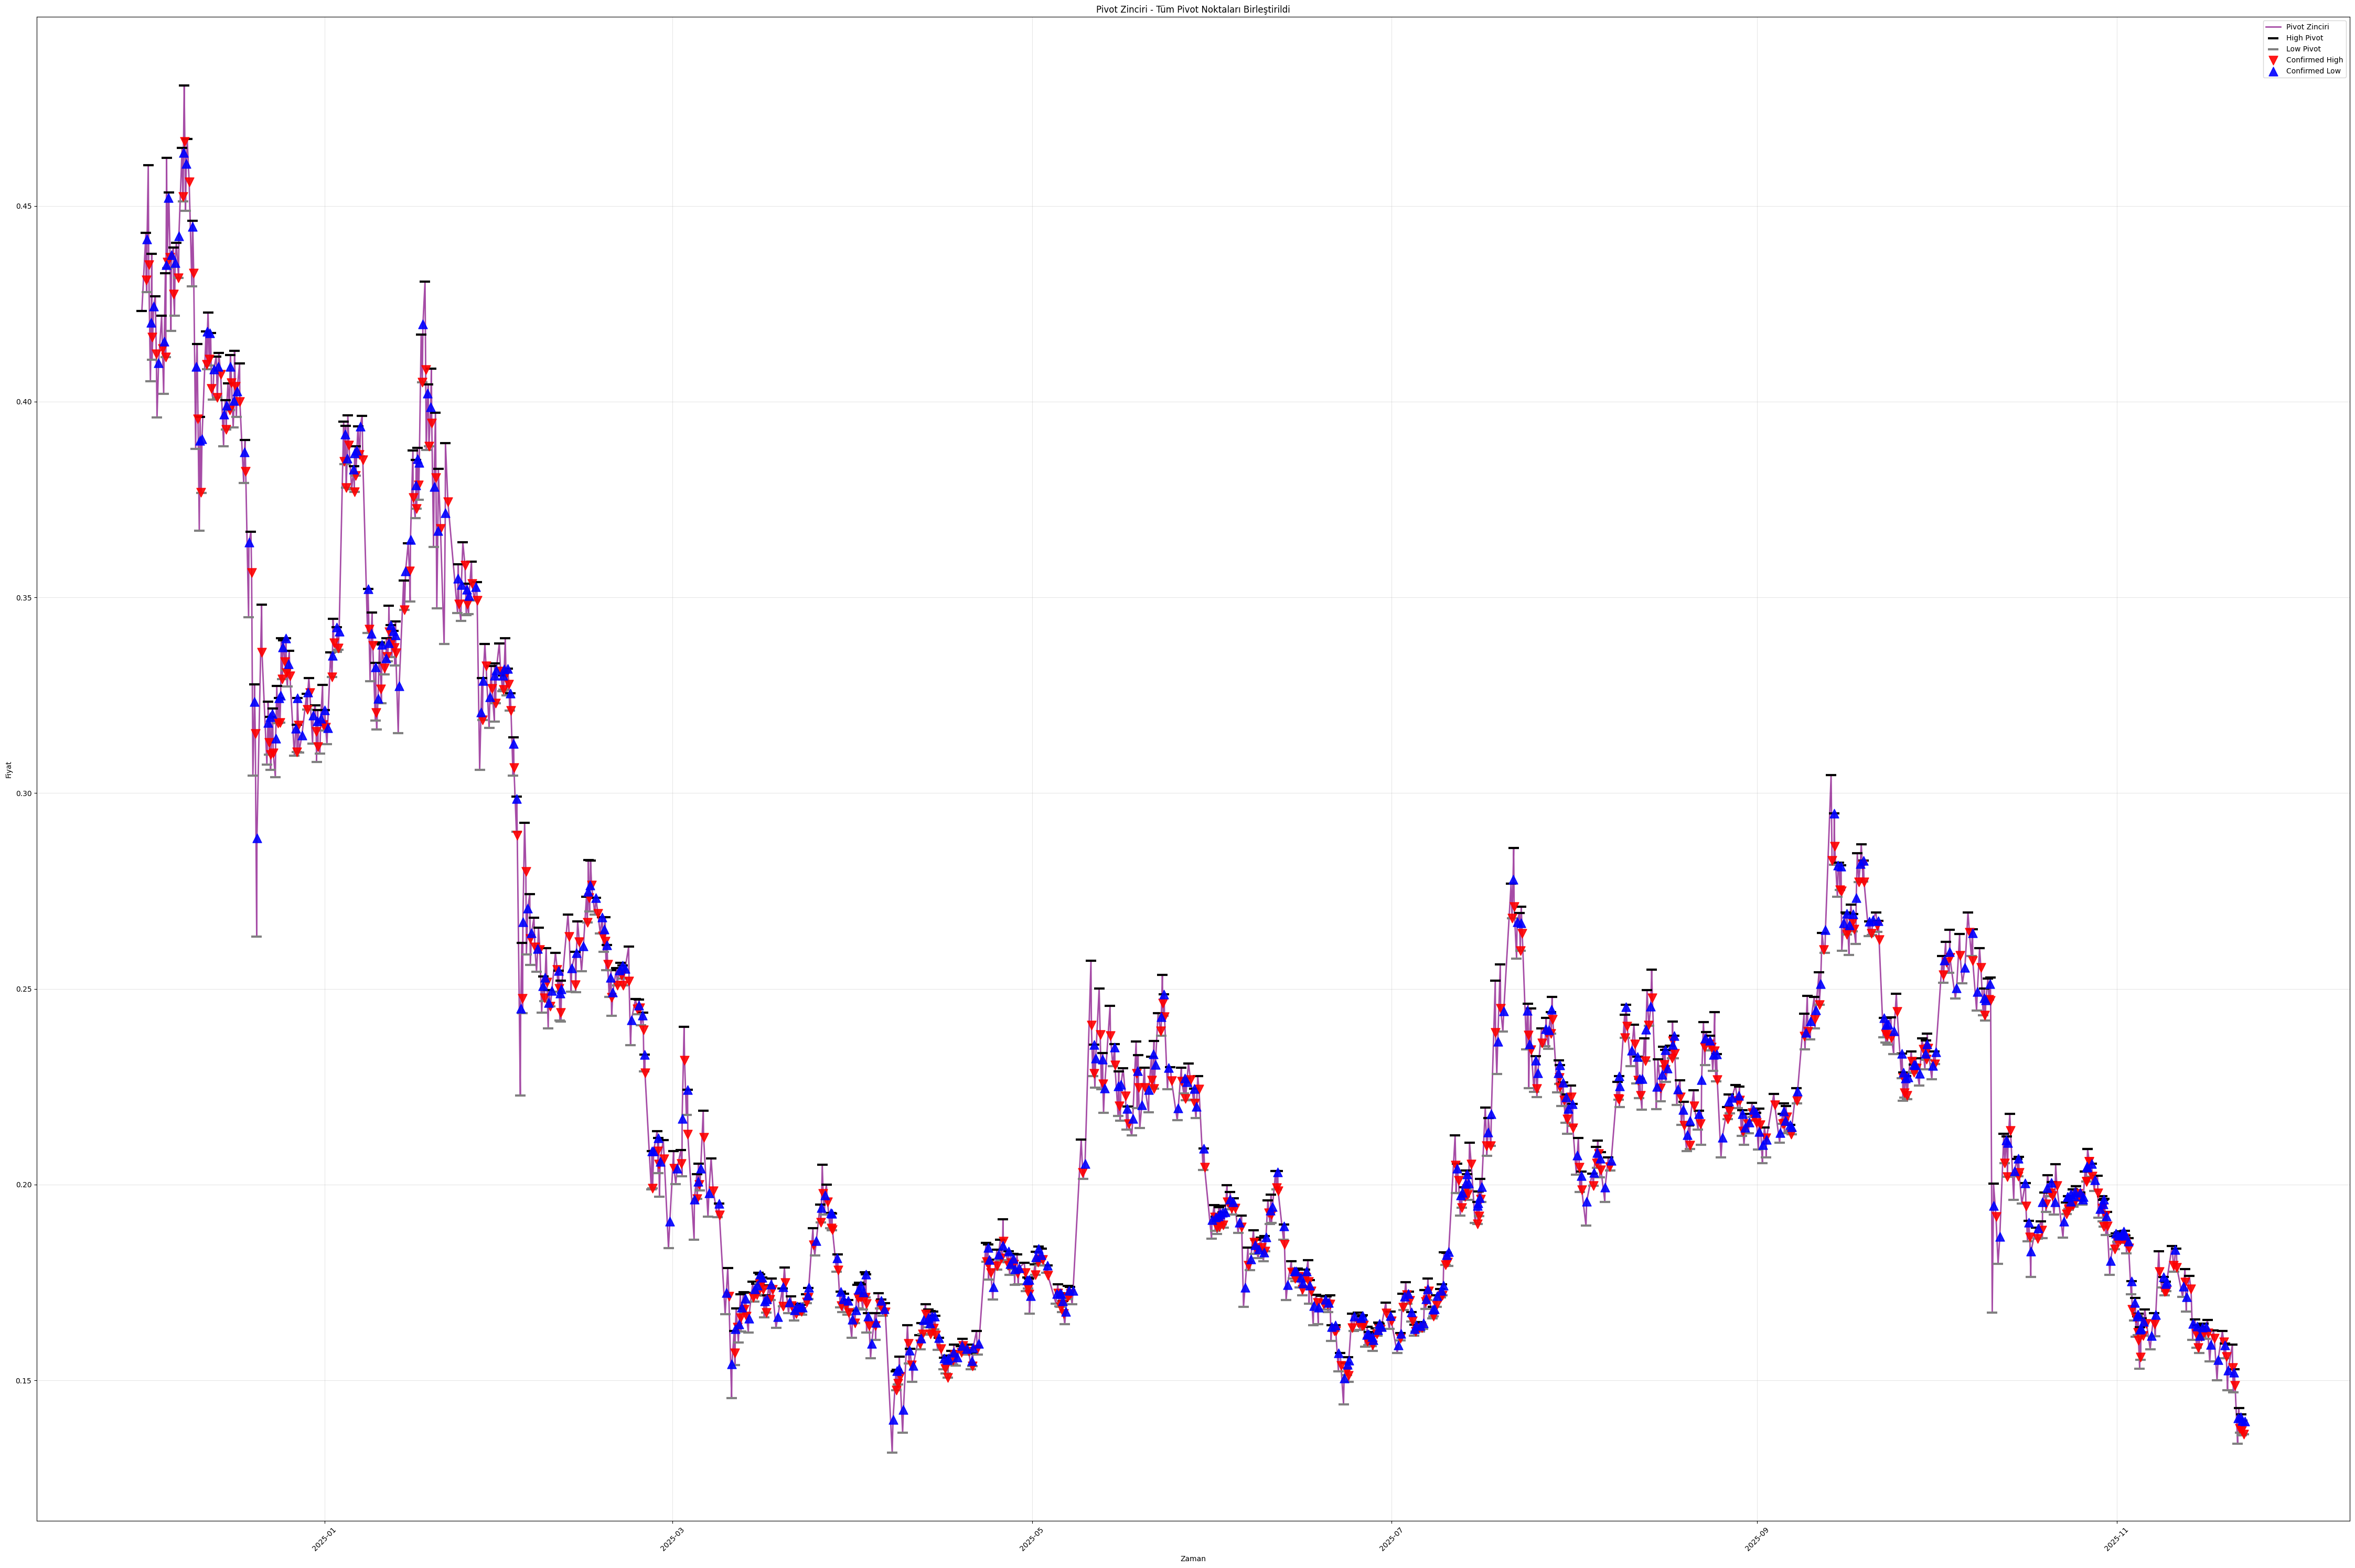

In [ ]:
time_column = 'time'

plt.figure(figsize=(45, 30))

# Tüm pivot noktalarını zaman sırasına göre birleştirelim
pivot_sequence = []

# High pivot noktalarını ekle
if 'high_pivot' in df.columns:
    high_pivots = df[df['high_pivot'].notna()][[time_column, 'high_pivot']].copy()
    high_pivots = high_pivots.rename(columns={'high_pivot': 'price'})
    high_pivots['type'] = 'high_pivot'
    pivot_sequence.append(high_pivots)

# High pivot confirmed noktalarını ekle (close değeri ile)
if 'high_pivot_confirmed' in df.columns:
    high_confirmed = df[df['high_pivot_confirmed'] == 1][[time_column, 'close']].copy()
    high_confirmed = high_confirmed.rename(columns={'close': 'price'})
    high_confirmed['type'] = 'high_confirmed'
    pivot_sequence.append(high_confirmed)

# Low pivot noktalarını ekle
if 'low_pivot' in df.columns:
    low_pivots = df[df['low_pivot'].notna()][[time_column, 'low_pivot']].copy()
    low_pivots = low_pivots.rename(columns={'low_pivot': 'price'})
    low_pivots['type'] = 'low_pivot'
    pivot_sequence.append(low_pivots)

# Low pivot confirmed noktalarını ekle (close değeri ile)
if 'low_pivot_confirmed' in df.columns:
    low_confirmed = df[df['low_pivot_confirmed'] == 1][[time_column, 'close']].copy()
    low_confirmed = low_confirmed.rename(columns={'close': 'price'})
    low_confirmed['type'] = 'low_confirmed'
    pivot_sequence.append(low_confirmed)

# Tüm pivot noktalarını birleştir ve zaman sırasına göre sırala
if pivot_sequence:
    all_pivots = pd.concat(pivot_sequence).sort_values(time_column).reset_index(drop=True)

    # Zincir çizgisini çiz
    plt.plot(all_pivots[time_column], all_pivots['price'],
             color='purple', linewidth=2, label='Pivot Zinciri', alpha=0.7, marker='')

# 1. High pivot noktaları (- siyah)
if 'high_pivot' in df.columns:
    high_pivot_points = df[df['high_pivot'].notna()]
    plt.scatter(high_pivot_points[time_column], high_pivot_points['high_pivot'],
                marker='_', color='black', s=200, label='High Pivot', linewidth=3, zorder=5)

# 2. Low pivot noktaları (- gri)
if 'low_pivot' in df.columns:
    low_pivot_points = df[df['low_pivot'].notna()]
    plt.scatter(low_pivot_points[time_column], low_pivot_points['low_pivot'],
                marker='_', color='gray', s=200, label='Low Pivot', linewidth=3, zorder=5)

# 3. Onaylanmış high pivot noktaları (v kırmızı) - CLOSE değeri ile
if 'high_pivot_confirmed' in df.columns:
    confirmed_high = df[df['high_pivot_confirmed'] == 1]
    plt.scatter(confirmed_high[time_column], confirmed_high['close'],
                marker='v', color='red', s=150, label='Confirmed High', alpha=0.9, zorder=6)

# 4. Onaylanmış low pivot noktaları (^ mavi) - CLOSE değeri ile
if 'low_pivot_confirmed' in df.columns:
    confirmed_low = df[df['low_pivot_confirmed'] == 1]
    plt.scatter(confirmed_low[time_column], confirmed_low['close'],
                marker='^', color='blue', s=150, label='Confirmed Low', alpha=0.9, zorder=6)

plt.title('Pivot Zinciri - Tüm Pivot Noktaları Birleştirildi')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

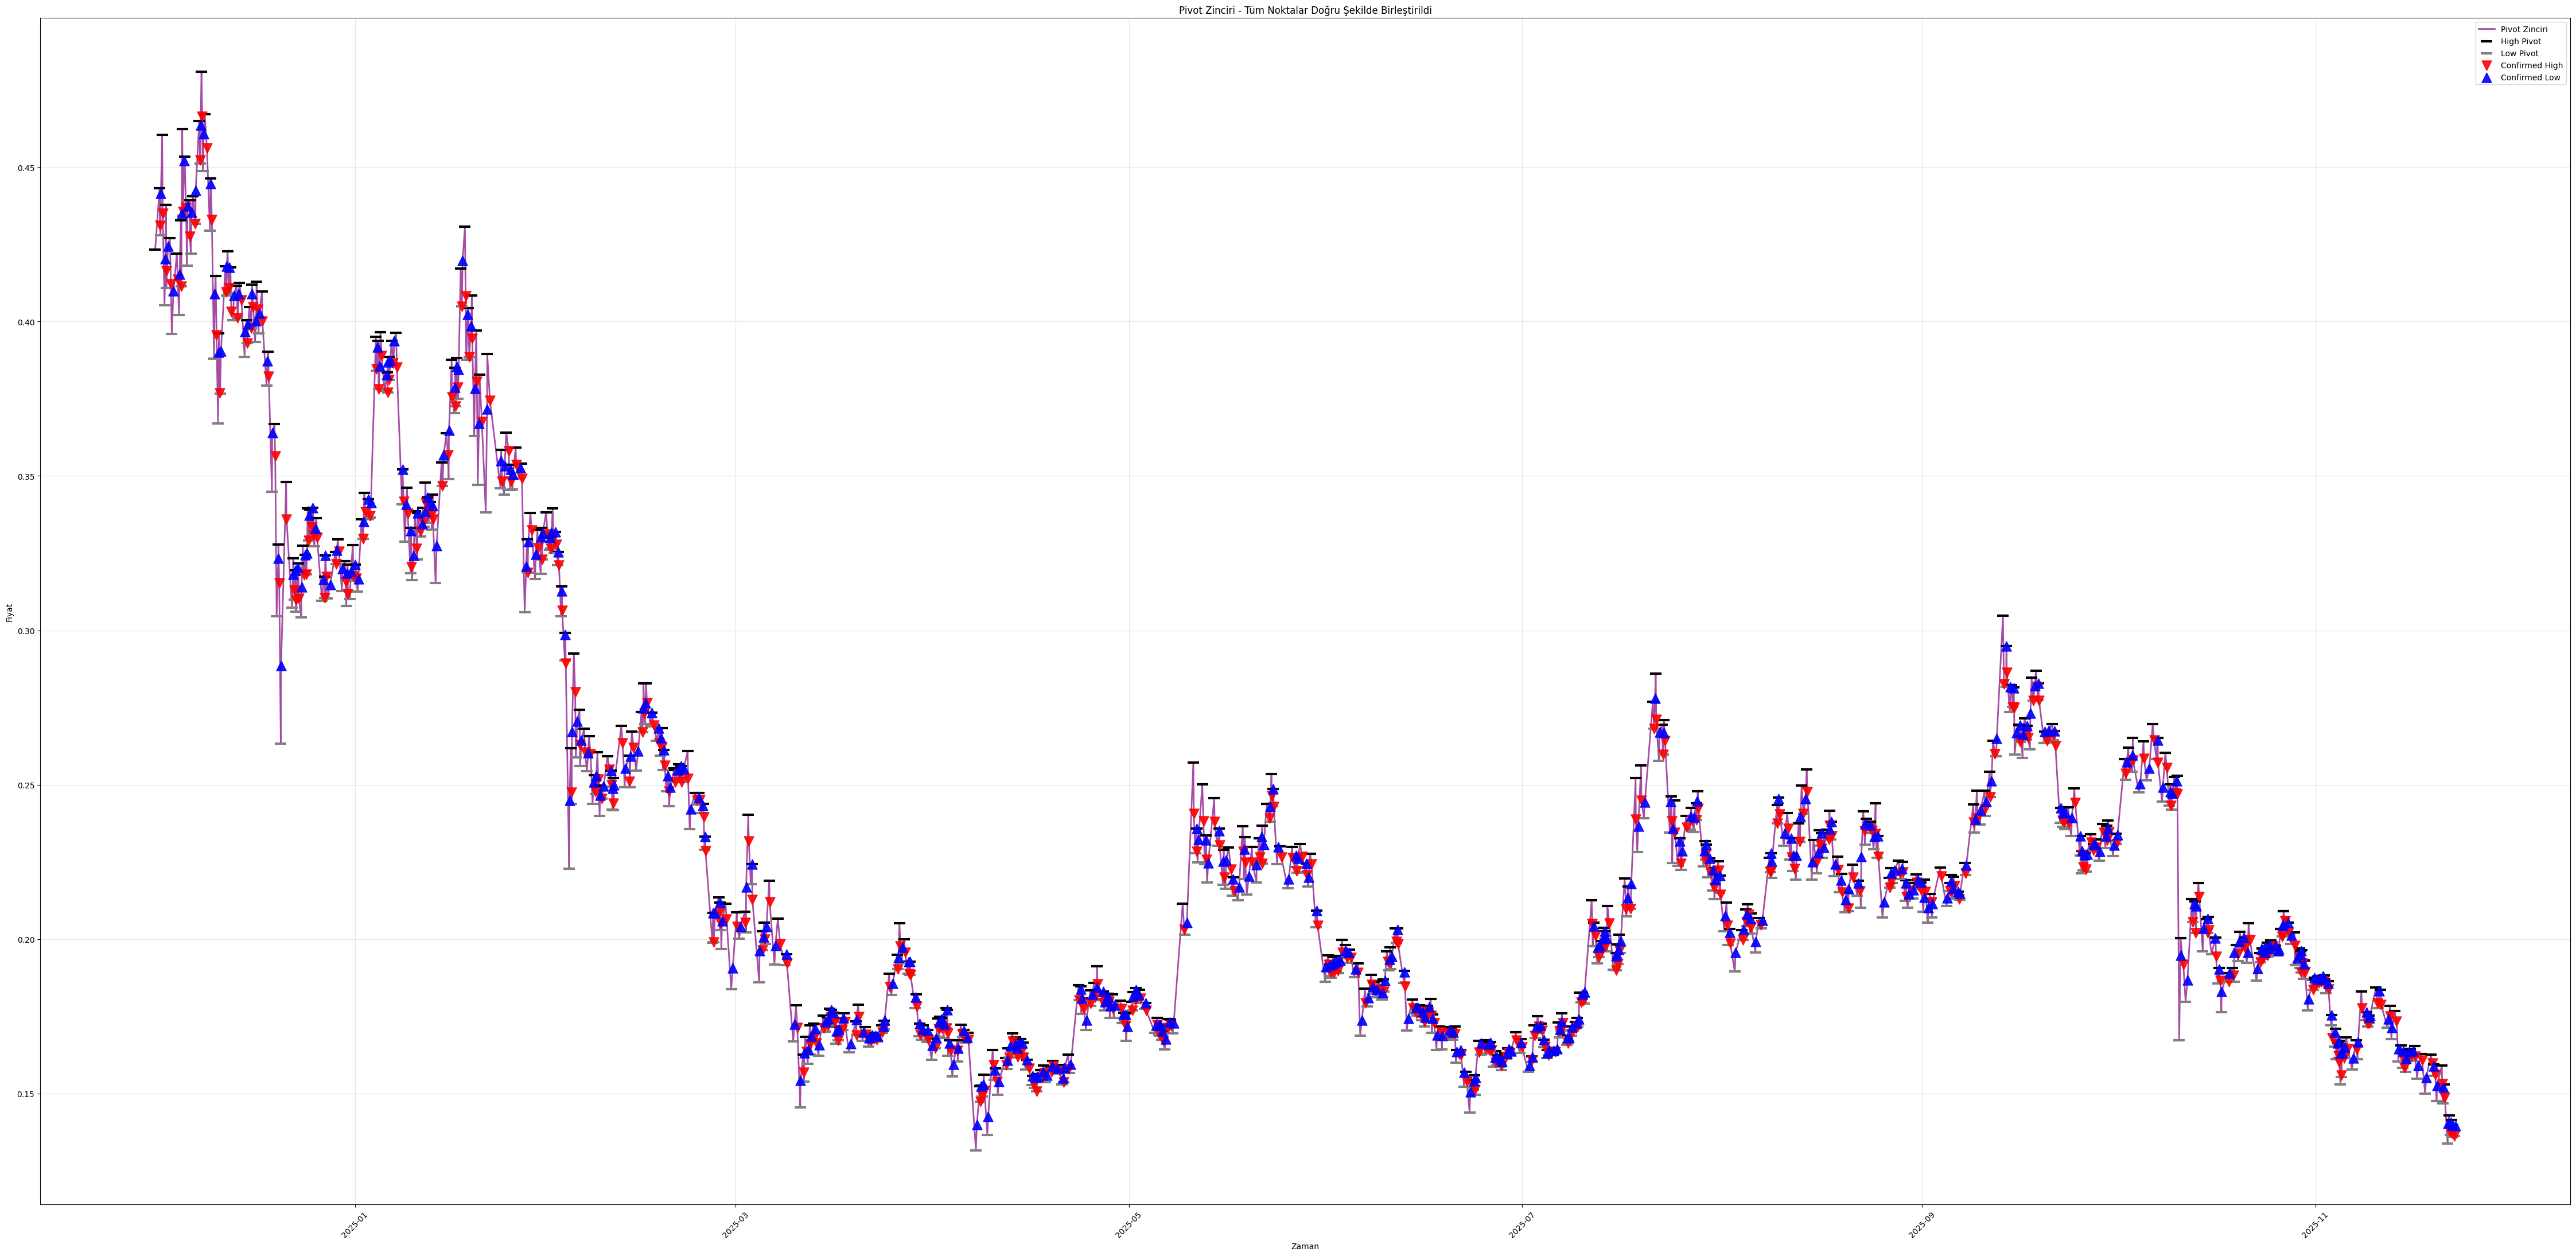

In [ ]:
time_column = 'time'

plt.figure(figsize=(45, 22))

# Tüm pivot noktalarını topla
all_points = []

# High pivot'lar
if 'high_pivot' in df.columns:
    high_points = df[df['high_pivot'].notna()][[time_column, 'high_pivot']]
    high_points = high_points.rename(columns={'high_pivot': 'price'})
    all_points.append(high_points)

# Low pivot'lar
if 'low_pivot' in df.columns:
    low_points = df[df['low_pivot'].notna()][[time_column, 'low_pivot']]
    low_points = low_points.rename(columns={'low_pivot': 'price'})
    all_points.append(low_points)

# High pivot confirmed'lar (close değeri)
if 'high_pivot_confirmed' in df.columns:
    high_conf_points = df[df['high_pivot_confirmed'] == 1][[time_column, 'close']]
    high_conf_points = high_conf_points.rename(columns={'close': 'price'})
    all_points.append(high_conf_points)

# Low pivot confirmed'lar (close değeri)
if 'low_pivot_confirmed' in df.columns:
    low_conf_points = df[df['low_pivot_confirmed'] == 1][[time_column, 'close']]
    low_conf_points = low_conf_points.rename(columns={'close': 'price'})
    all_points.append(low_conf_points)

# Tüm noktaları birleştir ve sırala
if all_points:
    combined = pd.concat(all_points).sort_values(time_column).drop_duplicates().reset_index(drop=True)

    # Ana zincir çizgisi
    plt.plot(combined[time_column], combined['price'],
             color='purple', linewidth=2, label='Pivot Zinciri', alpha=0.7)

# Semboller
if 'high_pivot' in df.columns:
    high_pivot_points = df[df['high_pivot'].notna()]
    plt.scatter(high_pivot_points[time_column], high_pivot_points['high_pivot'],
                marker='_', color='black', s=200, label='High Pivot', linewidth=3, zorder=5)

if 'low_pivot' in df.columns:
    low_pivot_points = df[df['low_pivot'].notna()]
    plt.scatter(low_pivot_points[time_column], low_pivot_points['low_pivot'],
                marker='_', color='gray', s=200, label='Low Pivot', linewidth=3, zorder=5)

if 'high_pivot_confirmed' in df.columns:
    confirmed_high = df[df['high_pivot_confirmed'] == 1]
    plt.scatter(confirmed_high[time_column], confirmed_high['close'],
                marker='v', color='red', s=150, label='Confirmed High', alpha=0.9, zorder=6)

if 'low_pivot_confirmed' in df.columns:
    confirmed_low = df[df['low_pivot_confirmed'] == 1]
    plt.scatter(confirmed_low[time_column], confirmed_low['close'],
                marker='^', color='blue', s=150, label='Confirmed Low', alpha=0.9, zorder=6)

plt.title('Pivot Zinciri - Tüm Noktalar Doğru Şekilde Birleştirildi')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

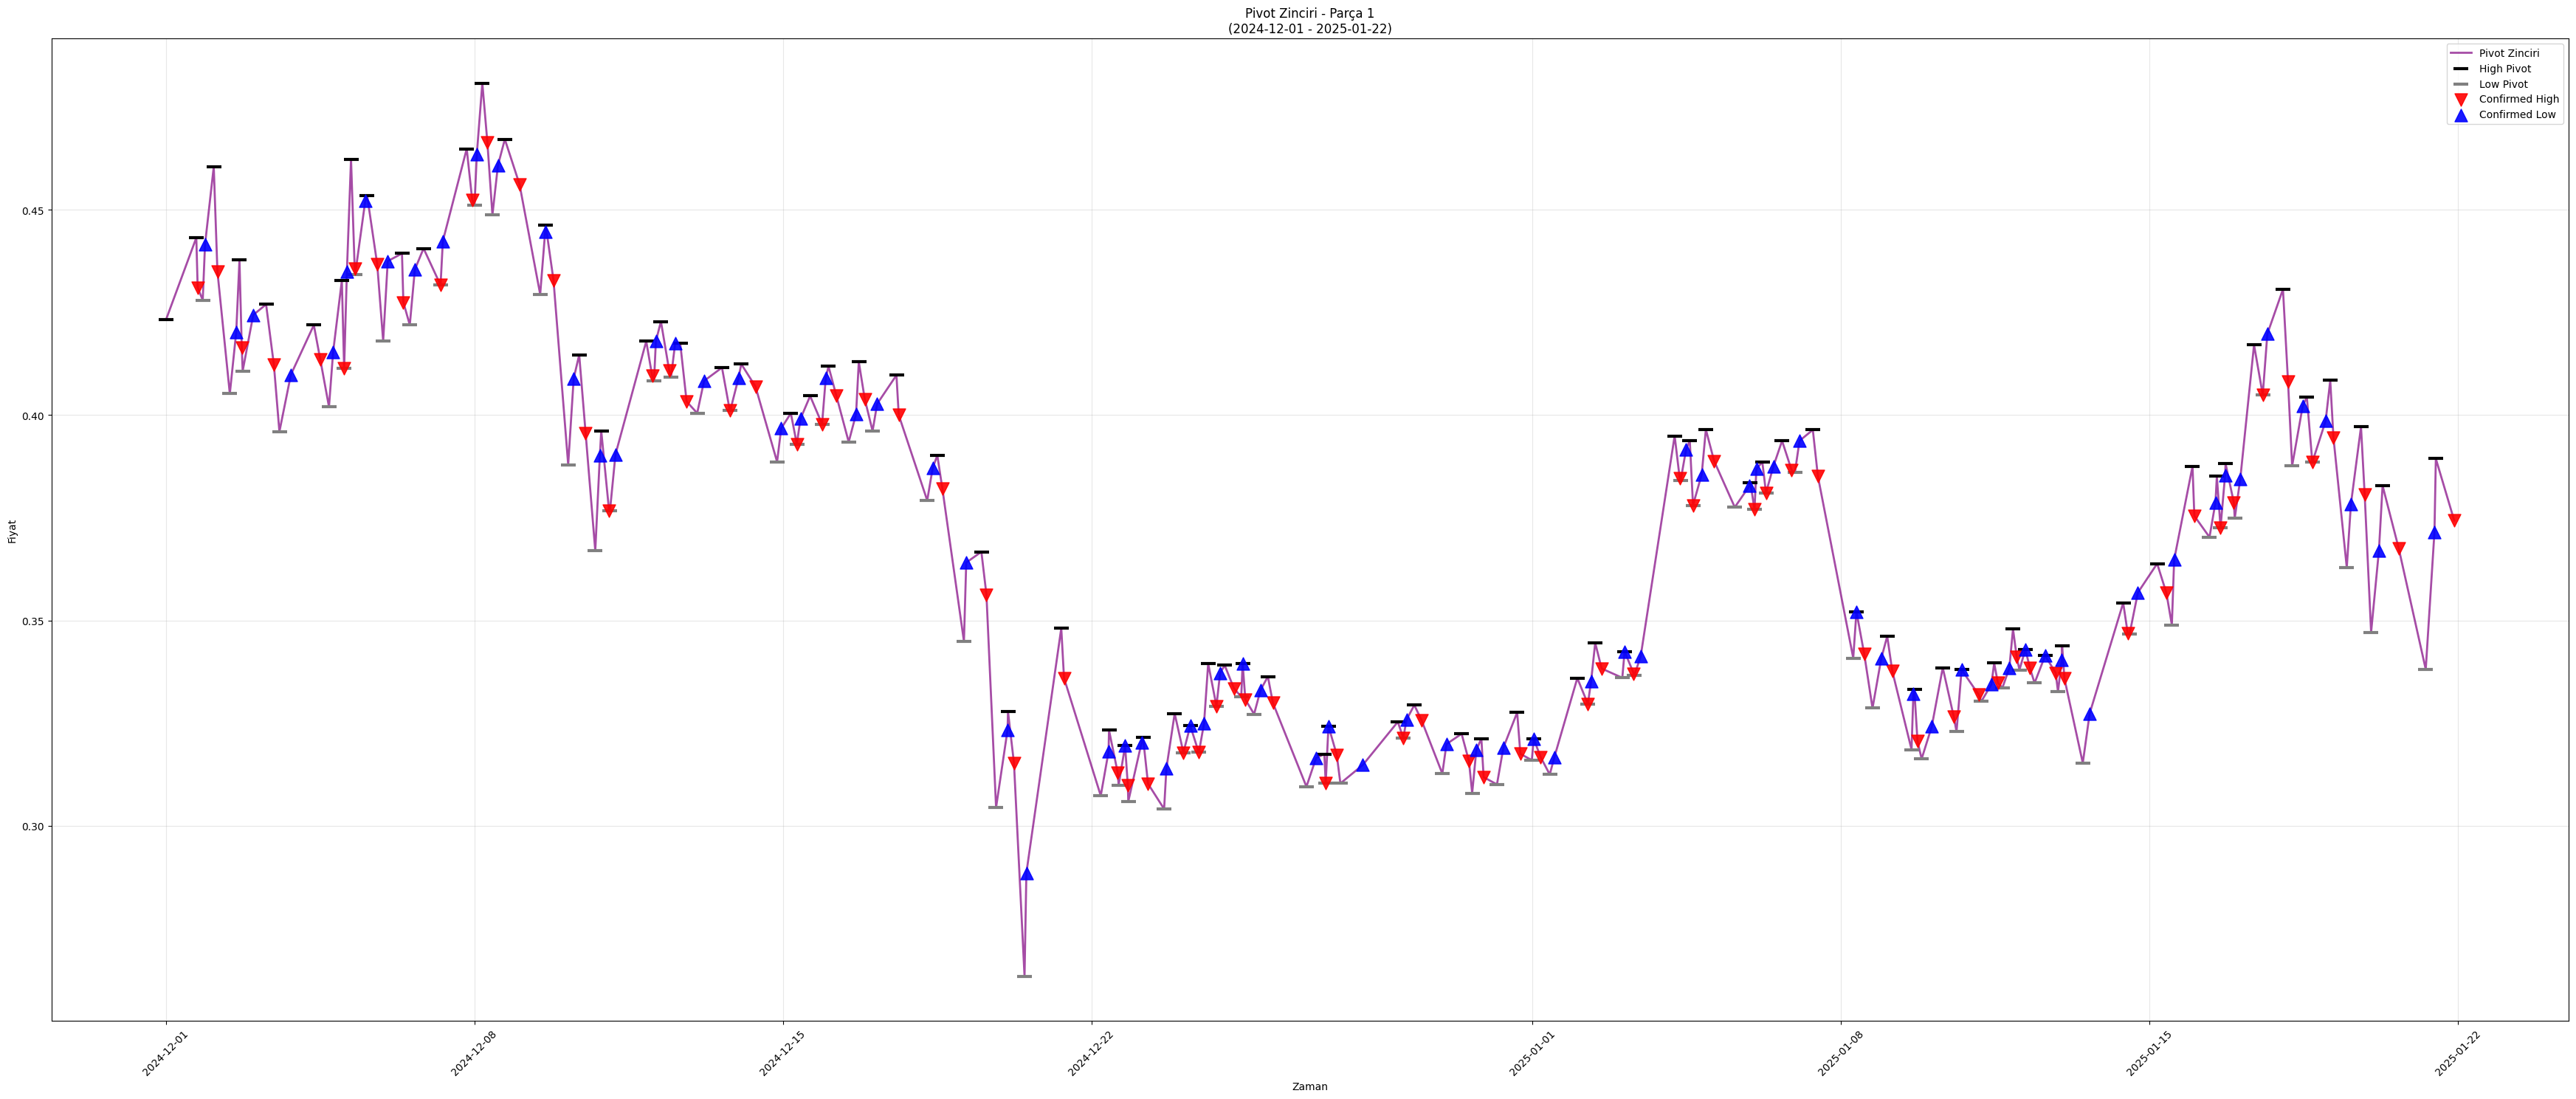

Parça 1 tamamlandı: 4993 mum, 290 pivot noktası


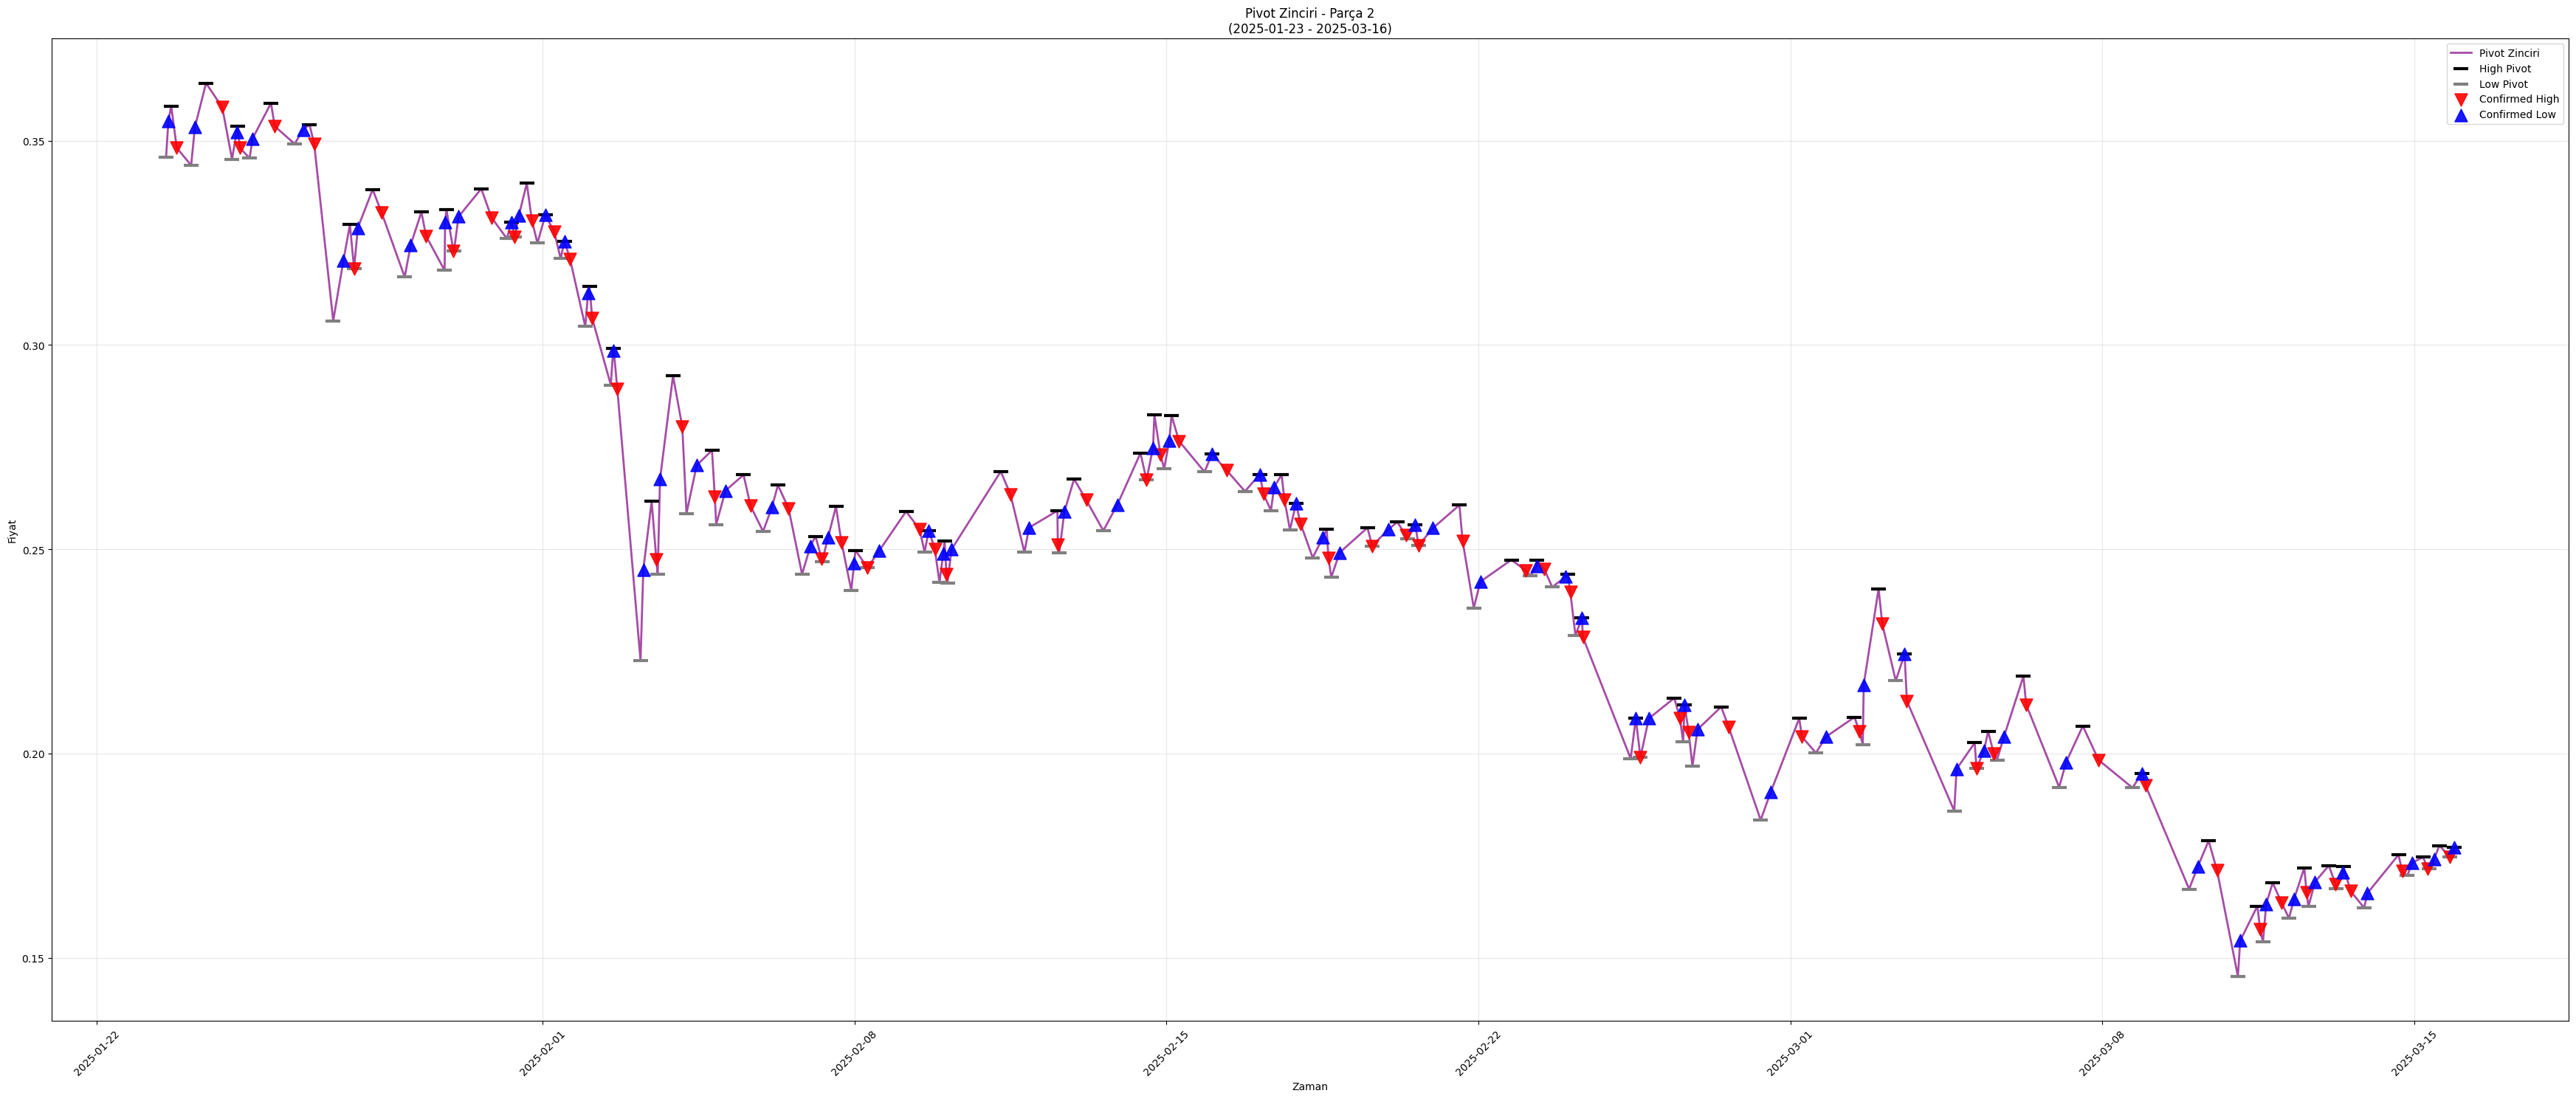

Parça 2 tamamlandı: 4993 mum, 252 pivot noktası


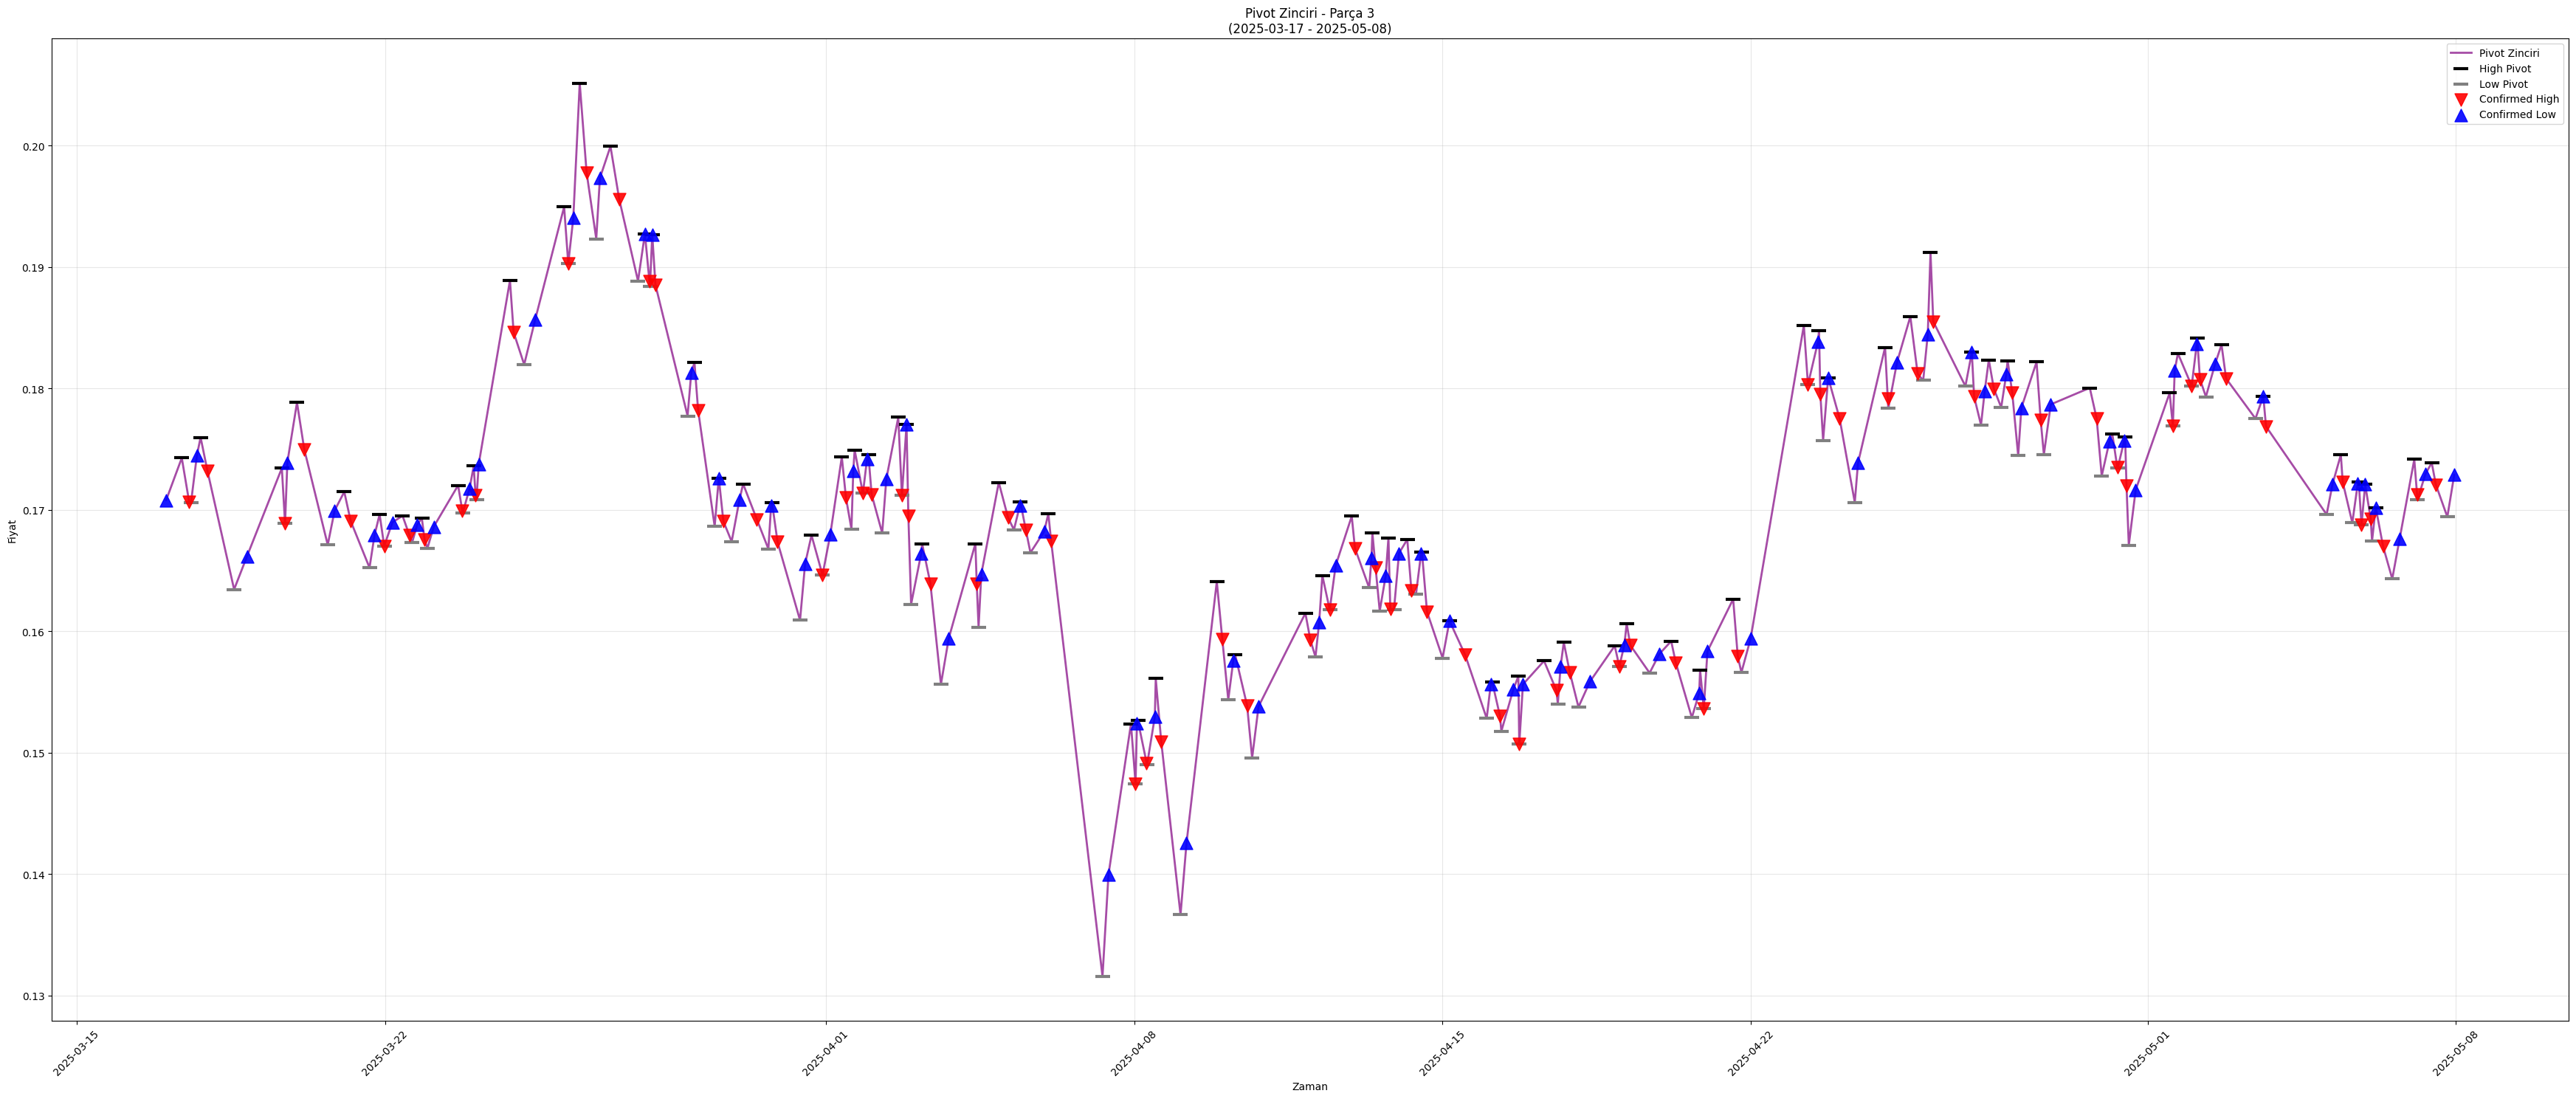

Parça 3 tamamlandı: 4993 mum, 284 pivot noktası


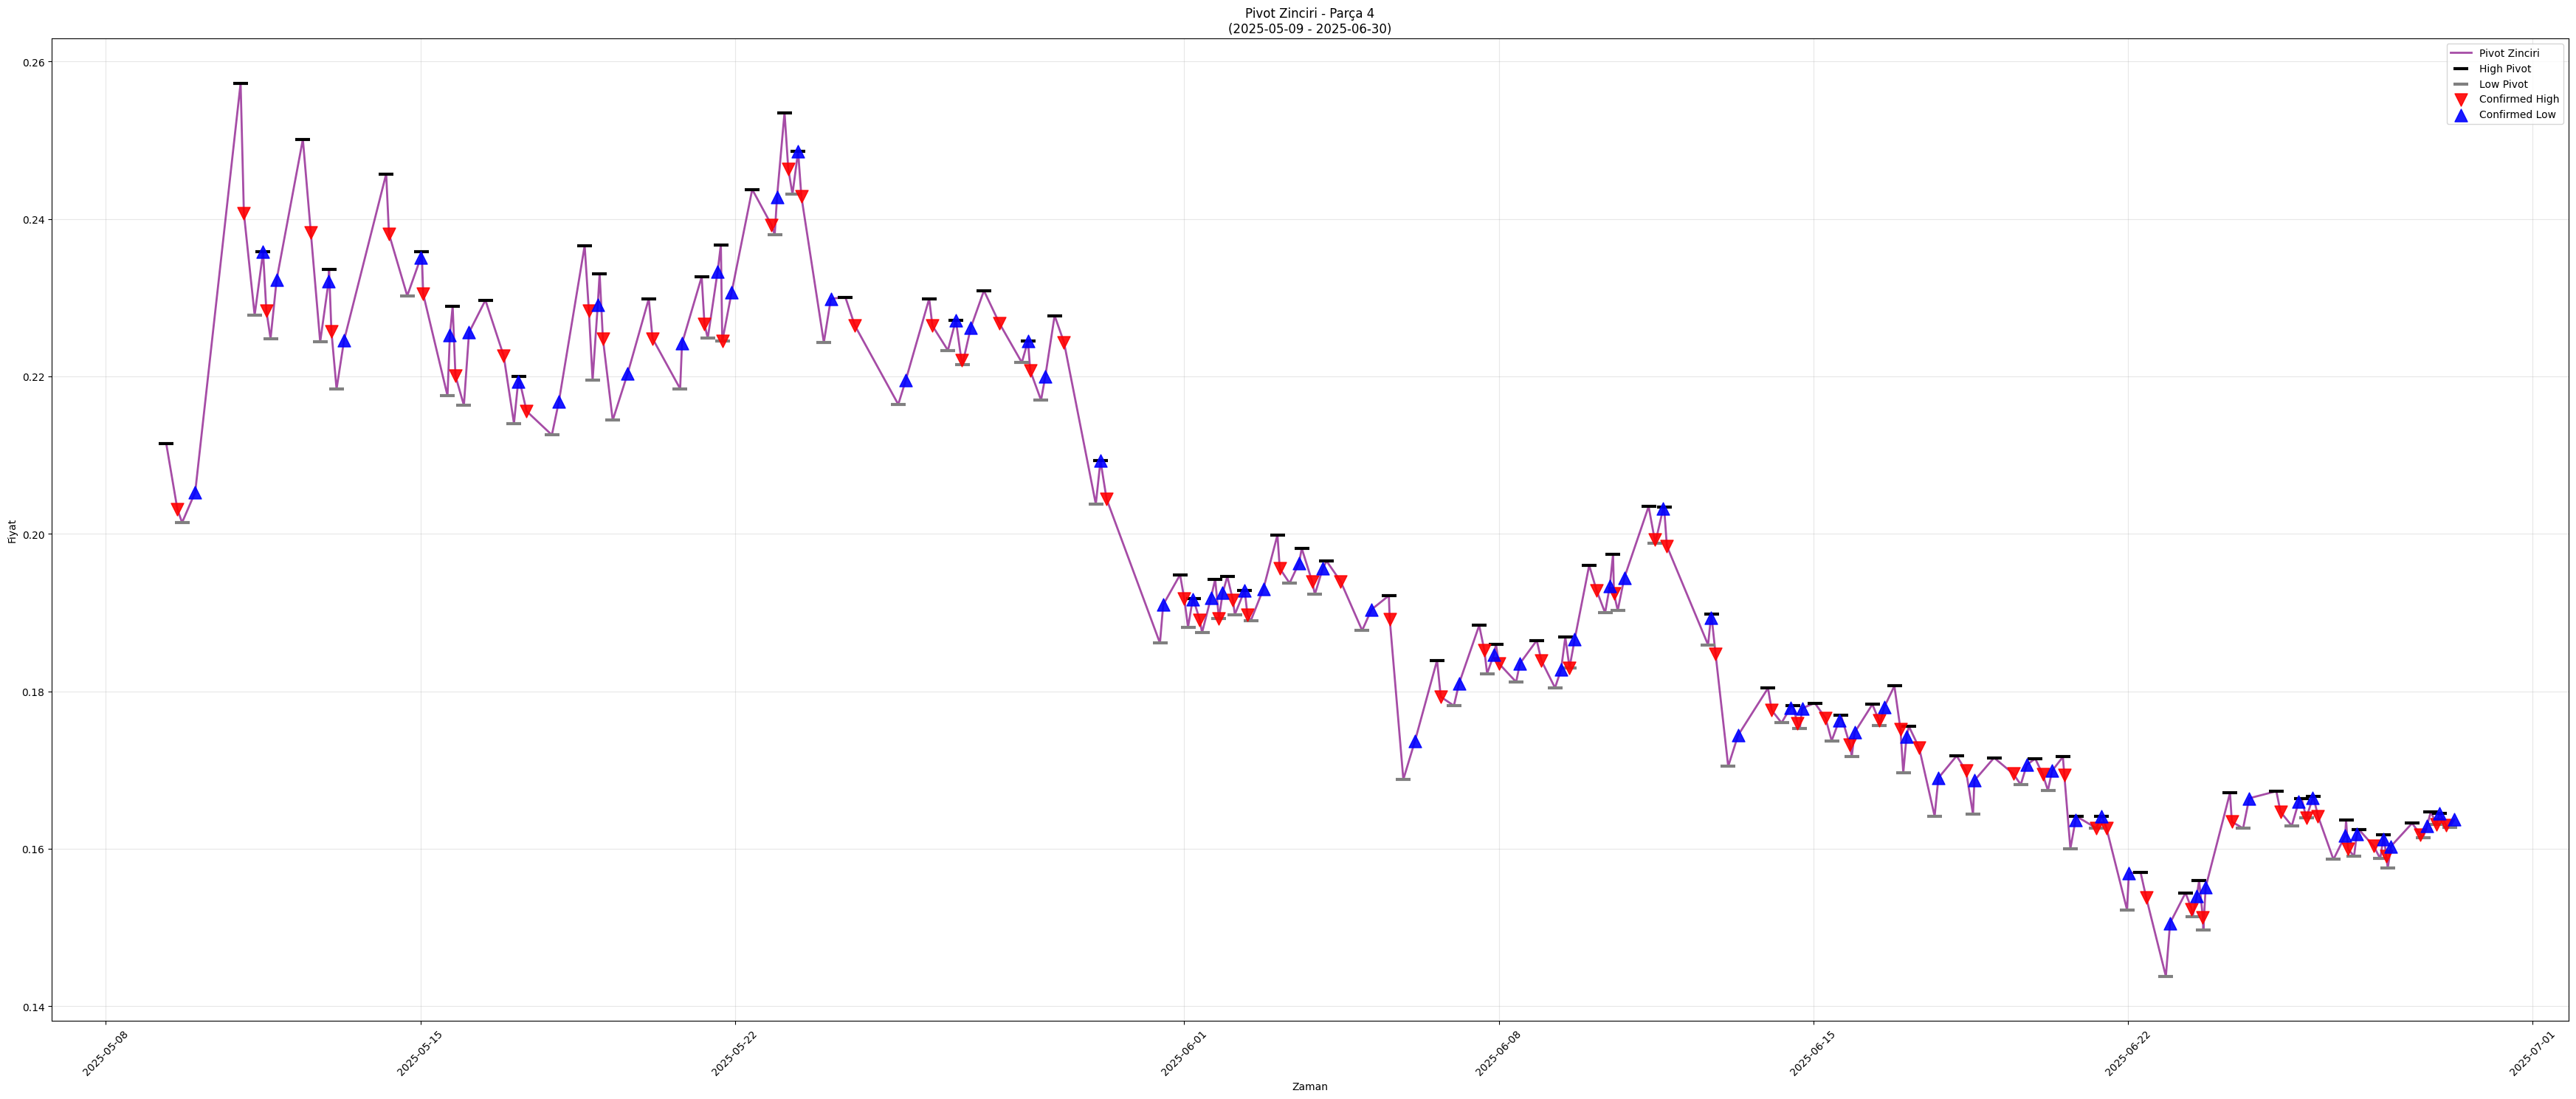

Parça 4 tamamlandı: 4993 mum, 266 pivot noktası
Tüm parçalar oluşturuldu!


In [ ]:
date_ranges = [
    ('2024-12-01', '2025-01-22'),
    ('2025-01-23', '2025-03-16'),
    ('2025-03-17', '2025-05-08'),
    ('2025-05-09', '2025-06-30')
]

time_column = 'time'

# Zaman sütununu datetime'a çevir (eğer değilse)
df[time_column] = pd.to_datetime(df[time_column])

# Her bir tarih aralığı için grafik oluştur
for i, (start_date, end_date) in enumerate(date_ranges, 1):
    # Tarih aralığını filtrele
    mask = (df[time_column] >= start_date) & (df[time_column] <= end_date)
    df_filtered = df.loc[mask]

    if len(df_filtered) == 0:
        print(f"Parça {i}: {start_date} - {end_date} aralığında veri bulunamadı")
        continue

    # Grafik oluştur
    plt.figure(figsize=(35, 15))

    # Tüm pivot noktalarını topla
    all_points = []

    # High pivot'lar
    if 'high_pivot' in df_filtered.columns:
        high_points = df_filtered[df_filtered['high_pivot'].notna()][[time_column, 'high_pivot']]
        high_points = high_points.rename(columns={'high_pivot': 'price'})
        all_points.append(high_points)

    # Low pivot'lar
    if 'low_pivot' in df_filtered.columns:
        low_points = df_filtered[df_filtered['low_pivot'].notna()][[time_column, 'low_pivot']]
        low_points = low_points.rename(columns={'low_pivot': 'price'})
        all_points.append(low_points)

    # High pivot confirmed'lar (close değeri)
    if 'high_pivot_confirmed' in df_filtered.columns:
        high_conf_points = df_filtered[df_filtered['high_pivot_confirmed'] == 1][[time_column, 'close']]
        high_conf_points = high_conf_points.rename(columns={'close': 'price'})
        all_points.append(high_conf_points)

    # Low pivot confirmed'lar (close değeri)
    if 'low_pivot_confirmed' in df_filtered.columns:
        low_conf_points = df_filtered[df_filtered['low_pivot_confirmed'] == 1][[time_column, 'close']]
        low_conf_points = low_conf_points.rename(columns={'close': 'price'})
        all_points.append(low_conf_points)

    # Tüm noktaları birleştir ve sırala
    if all_points:
        combined = pd.concat(all_points).sort_values(time_column).drop_duplicates().reset_index(drop=True)

        # Ana zincir çizgisi
        plt.plot(combined[time_column], combined['price'],
                 color='purple', linewidth=2, label='Pivot Zinciri', alpha=0.7)

    # Semboller
    if 'high_pivot' in df_filtered.columns:
        high_pivot_points = df_filtered[df_filtered['high_pivot'].notna()]
        plt.scatter(high_pivot_points[time_column], high_pivot_points['high_pivot'],
                    marker='_', color='black', s=200, label='High Pivot', linewidth=3, zorder=5)

    if 'low_pivot' in df_filtered.columns:
        low_pivot_points = df_filtered[df_filtered['low_pivot'].notna()]
        plt.scatter(low_pivot_points[time_column], low_pivot_points['low_pivot'],
                    marker='_', color='gray', s=200, label='Low Pivot', linewidth=3, zorder=5)

    if 'high_pivot_confirmed' in df_filtered.columns:
        confirmed_high = df_filtered[df_filtered['high_pivot_confirmed'] == 1]
        plt.scatter(confirmed_high[time_column], confirmed_high['close'],
                    marker='v', color='red', s=150, label='Confirmed High', alpha=0.9, zorder=6)

    if 'low_pivot_confirmed' in df_filtered.columns:
        confirmed_low = df_filtered[df_filtered['low_pivot_confirmed'] == 1]
        plt.scatter(confirmed_low[time_column], confirmed_low['close'],
                    marker='^', color='blue', s=150, label='Confirmed Low', alpha=0.9, zorder=6)

    plt.title(f'Pivot Zinciri - Parça {i}\n({start_date} - {end_date})')
    plt.xlabel('Zaman')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Parça {i} tamamlandı: {len(df_filtered)} mum, {len(combined) if all_points else 0} pivot noktası")

print("Tüm parçalar oluşturuldu!")

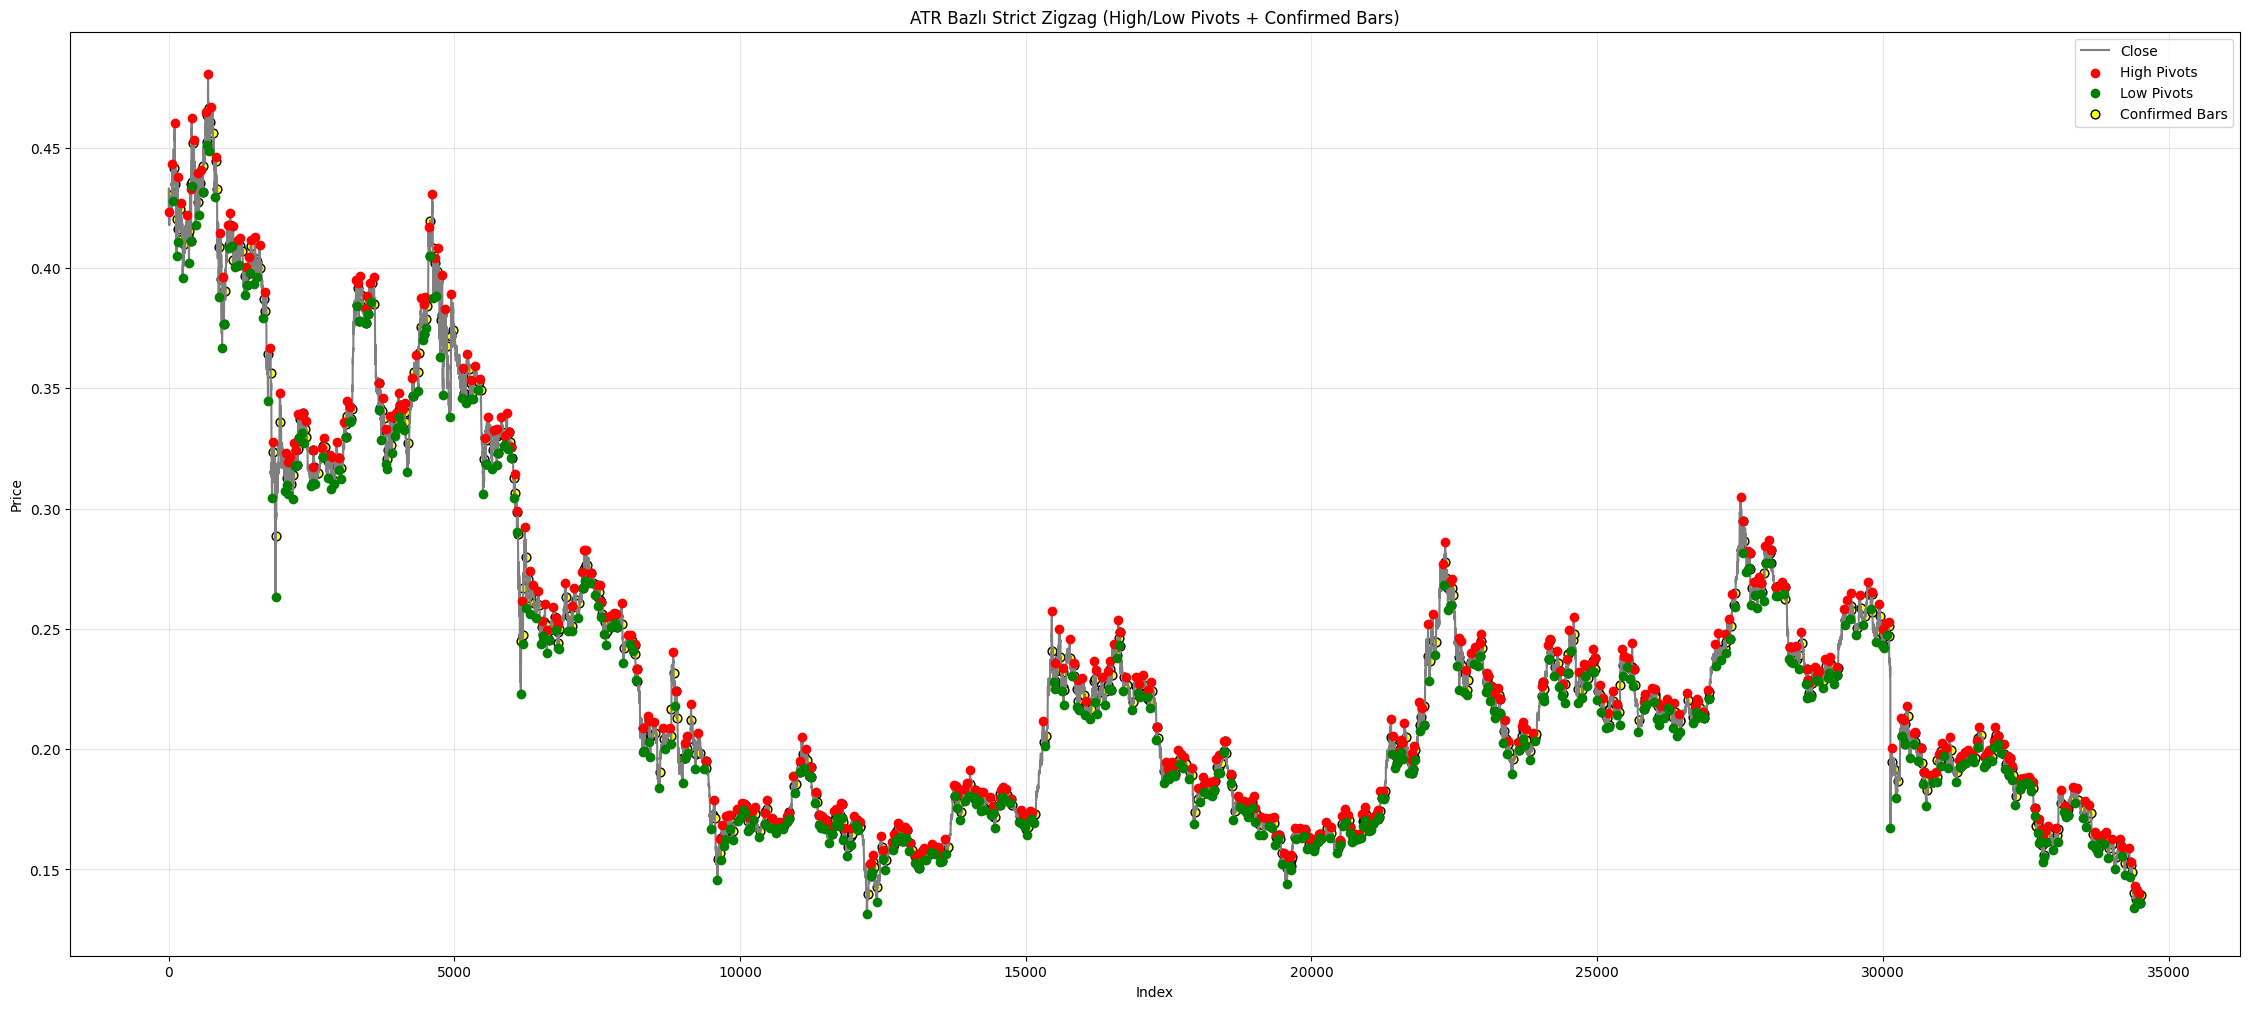

In [ ]:
df_z = df[(df['high_pivot'].notna()) | (df['low_pivot'].notna()) | (df['high_pivot_confirmed'].notna()) | (df['low_pivot_confirmed'].notna())]

plt.figure(figsize=(28,12))
plt.plot(df_z["close"], label="Close", color="grey")

# Pivot noktaları
plt.scatter(df_z.index, df_z["high_pivot"], color="red", label="High Pivots", zorder=3)
plt.scatter(df_z.index, df_z["low_pivot"], color="green", label="Low Pivots", zorder=3)

# ✅ Confirmed satırları
confirmed = df_z[(df_z["high_pivot_confirmed"] == 1) | (df_z["low_pivot_confirmed"] == 1)]
plt.scatter(confirmed.index, confirmed["close"], color="yellow", edgecolors="black",
            label="Confirmed Bars", zorder=1, s=40, marker="o")

plt.title("ATR Bazlı Strict Zigzag (High/Low Pivots + Confirmed Bars)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
legs_df = build_pivot_legs(df)

In [ ]:
legs_df.columns[legs_df.columns.str.contains('rsi')]

Index(['entry_rsi', 'entry_cat_rsi', 'entry_rsi_40', 'entry_stoch_rsi_k', 'entry_stoch_rsi_d', 'exit_rsi', 'exit_cat_rsi', 'exit_rsi_40', 'exit_stoch_rsi_k', 'exit_stoch_rsi_d'], dtype='object')

In [ ]:
q_low, q_high = legs_df['start_atr'].quantile([0.1,0.9])

In [ ]:
# ATR yüzdesi
legs_df['atr_pct_of_price'] = (legs_df['start_atr'] / legs_df['start_price']) * 100

# Ortalama ATR yüzdesi
avg_atr_pct = legs_df['atr_pct_of_price'].mean()
print(avg_atr_pct)


0.7333731879648214


In [ ]:

# 1) ATR katlarının dağılımı (up/down ayrı)
legs_df.groupby(["direction"])["atr_multiple"].describe([0.08, 0.29, 0.33, 0.38, 0.57,0.75])

count         mean          std          min           8%          29%          33%          38%          50%          57%          75%           max
direction                                                                                                                                                               
down      507.0000000000 7.1844238466 5.9645608632 1.3623911387 2.9704259389 4.0466626165 4.3570567690 4.6324682815 5.5811564783 6.2416267076 8.4646317236 65.0062305759
up        506.0000000000 6.5931726095 5.0769768567 1.9807755918 2.9111044585 3.7964540925 3.9701832371 4.2383082642 5.1269893791 5.5017626348 7.5084900853 38.5762114006

In [ ]:
legs_df.loc[(legs_df["entry_triggered"]) & (legs_df['direction']=='up') #& (legs_df['entry_rsi'] < 30)
            , "mfe_R_until_end_pivot"].describe([0.66,0.99])

count   506.0000000000
mean      5.5931726095
std       5.0769768567
min       0.9807755918
50%       4.1269893791
66%       5.3517936261
99%      28.1779854957
max      37.5762114006
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
legs_df.loc[(legs_df["entry_triggered"]) & (legs_df['direction']=='down') #& (legs_df['entry_rsi'] < 30)
            , "mfe_R_until_end_pivot"].describe([0.66,0.99])

count   507.0000000000
mean      6.1844238466
std       5.9645608632
min       0.3623911387
50%       4.5811564783
66%       6.1402529914
99%      27.3841581142
max      64.0062305759
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
legs_df.loc[(legs_df["entry_triggered"]) & (legs_df["entry_trend_13_50"]== 'uptrend') & (legs_df['direction']=='up') #& (legs_df['entry_rsi'] < 30)
            , "mfe_R_until_end_pivot"].describe([0.02,0.66,0.99])

count   140.0000000000
mean      5.9568920039
std       5.0999042285
min       1.2326883715
2%        1.5162723592
50%       4.3605450200
66%       5.8044255652
99%      26.3028309045
max      33.3048832137
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
legs_df.loc[(legs_df["entry_triggered"]) & (legs_df["entry_trend_13_50"]== 'downtrend') & (legs_df['direction']=='down') #& (legs_df['entry_rsi'] > 70)
              , "mfe_R_until_end_pivot"].describe([0.66,0.99])

count   135.0000000000
mean      6.8864857536
std       6.2546018528
min       0.3623911387
50%       5.1954611602
66%       6.5786320317
99%      29.7402617437
max      43.7051272818
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
filtered = legs_df.loc[
    (legs_df["entry_triggered"]) &
    (legs_df["start_atr"] >= q_low) &
    (legs_df["start_atr"] <= q_high)
]

In [ ]:
filtered.loc[filtered['entry_triggered'], "mfe_R_until_end_pivot"].describe()

count   809.0000000000
mean      5.9447997003
std       5.4244524042
min       0.3623911387
25%       2.7682464687
50%       4.4345096196
75%       7.1123527550
max      60.4438473803
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
filtered = filtered.loc[filtered["entry_adx"] > 20]


In [ ]:
# ATR yüzdesi
filtered['atr_pct_of_price'] = (filtered['start_atr'] / filtered['start_price']) * 100

# Ortalama ATR yüzdesi
avg_atr_pct = filtered['atr_pct_of_price'].mean()
print(avg_atr_pct)


0.6984957291982509


In [ ]:
filtered.loc[(legs_df["entry_trend_13_50"]== 'uptrend') & (legs_df['direction']=='up') , "mfe_R_until_end_pivot"].describe()

count   103.0000000000
mean      6.4061012055
std       5.4001637097
min       1.3467252972
25%       3.2970699888
50%       4.6133451514
75%       7.2835536101
max      33.3048832137
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
filtered.loc[ (filtered["entry_trend_13_50"]== 'downtrend') & (filtered['direction']=='down') , "mfe_R_until_end_pivot"].describe()

count   98.0000000000
mean     7.3670523915
std      6.5969592528
min      0.3623911387
25%      3.6426078408
50%      5.4891992255
75%      8.6785942658
max     43.7051272818
Name: mfe_R_until_end_pivot, dtype: float64

In [ ]:
dff

time         open         high          low        close               volume           rsi     cat_rsi        rsi_40          atr    bb_middle     bb_upper     bb_lower  bb_middle_200  bb_upper_200  bb_lower_200  dc_upper_20  dc_lower_20  dc_middle_20  dc_upper_50  dc_lower_50  dc_middle_50       sma_20       sma_50      sma_200   sma_200_4h  sma_20_rate  sma_50_rate  sma_200_rate  sma_20_slope trend_13_50 trend_50_200 trend_4h_50_200       ema_50       ema_20  ema_50_rate  ema_20_rate           nw     nw_upper     nw_lower   supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d    macd_line  macd_signal    macd_hist candle  candle_body  candle_strength    candle_class         volume_price      volume_candle   prev_close     high_low  high_prev_close  low_prev_close           tr    prev_high     prev_low       up_move     down_move          +dm          -dm       tr_ema      +dm_ema      -dm_ema           +di           -di            dx           adx                     obv  zigzag_high  zigzag_low    last_high     last_low  zigzag_position high_trend low_trend      pct_atr            x   high_pivot  low_pivot  high_pivot_atr  low_pivot_atr  high_pivot_confirmed  low_pivot_confirmed  pivot_bars_ago  high_pivot_filled  low_pivot_filled  high_pivot_atr_filled  low_pivot_atr_filled  high_pivot_confirmed_filled  low_pivot_confirmed_filled  pivot_bars_ago_filled   local_high    local_low        date   daily_open  daily_return_pct daily_direction daily_category  dc_position_ratio_20 dc_position_20  dc_position_ratio_50 dc_position_50  dc_breakout_20  dc_breakdown_20  dc_breakout_50  dc_breakdown_50 bb_position stoch_position  stoch_cross_up  stoch_cross_down   nw_position adx_category   diff_50_200  diff_50_200_prev  sma_cross_up  sma_cross_down  diff_50_200_4h  diff_50_200_4h_prev  sma_cross_up_4h  sma_cross_down_4h  bb_width_rate  dc_50_width_rate  dc_20_width_rate dc_50_width_rate_position dc_20_width_rate_position bb_width_rate_position pct_atr_position  macd_long_signal  macd_short_signal  stoch_long_signal  stoch_short_signal  two_dots_long  two_dots_short  pivot_breakout  pivot_breakdown  bb_touch_upper  bb_touch_lower  bb_1_touch_long  bb_1_touch_short  bb_3_touch_long  bb_3_touch_short  nw_long  nw_short  bb_3_touch_long_clean  bb_3_touch_short_clean  bb_1_touch_long_clean  bb_1_touch_short_clean  dc_breakout_clean_20  dc_breakdown_clean_20  dc_breakout_clean_50  dc_breakdown_clean_50  nw_long_clean  nw_short_clean  pivot_up  pivot_down  dc50_long_pivot_atr  dc50_short_pivot_atr  bb3_long_pivot_atr  bb3_short_pivot_atr   target_-6x   target_-3x   target_-2x    target_2x    target_3x    target_6x        -3x_bar         3x_bar
0     2024-12-01 00:00:00+00:00 0.4216000000 0.4241800000 0.4208600000 0.4232100000  17630066.0000000000           NaN         NaN           NaN 0.0033200000          NaN          NaN          NaN            NaN           NaN           NaN          NaN          NaN           NaN          NaN          NaN           NaN          NaN          NaN          NaN          NaN          NaN          NaN           NaN           NaN   downtrend    downtrend       downtrend 0.4232100000 0.4232100000 1.0000000000 1.0000000000          NaN          NaN          NaN          NaN              uptrend                NaN           NaN           NaN           NaN           NaN 0.0000000000 0.0000000000 0.0000000000  green 0.0016100000     0.4849397590    weak_bullish  41657961.7683892176   67069.3184471067          NaN 0.0033200000              NaN             NaN 0.0033200000          NaN          NaN           NaN           NaN 0.0000000000 0.0000000000          NaN          NaN          NaN           NaN           NaN           NaN           NaN            0.0000000000          NaN         NaN          NaN          NaN              NaN       None      None 0.7844805179 0.0033200000 0.4232100000        NaN    0.0033200000            NaN                     0         

# Market Structure Pivots

In [ ]:
dff[dff['low_pivot'].notna() | dff['high_pivot'].notna()][['high_pivot', 'high_pivot_filled' ,'low_pivot', 'low_pivot_filled']]

high_pivot  high_pivot_filled    low_pivot  low_pivot_filled
0     0.4232100000       0.4232100000          NaN               NaN
66    0.4431700000       0.4431700000          NaN               NaN
80             NaN       0.4431700000 0.4279900000      0.4279900000
104   0.4604300000       0.4604300000          NaN      0.4279900000
139            NaN       0.4604300000 0.4052000000      0.4052000000
...            ...                ...          ...               ...
34441          NaN       0.1429000000 0.1365700000      0.1365700000
34453 0.1413500000       0.1413500000          NaN      0.1365700000
34464          NaN       0.1413500000 0.1360200000      0.1360200000
34477 0.1396900000       0.1396900000          NaN      0.1360200000
34500          NaN       0.1396900000 0.1362200000      0.1362200000

[1015 rows x 4 columns]

In [ ]:
dff['rsi'][14]

np.float64(50.30555555555555)

In [ ]:
dff.loc[dff['high_pivot'].notna(), 'high_rsi'] = dff['rsi']
dff.loc[dff['low_pivot'].notna(), 'low_rsi'] = dff['rsi']

dff['high_rsi'] = dff['high_rsi'].ffill().fillna(dff['rsi'][14])
dff['low_rsi'] = dff['low_rsi'].ffill().fillna(dff['rsi'][14])

In [ ]:
dff.loc[dff['high_pivot_filled'] < dff['high_pivot_filled'].shift(1), 'previous_high'] = dff['high_pivot_filled'].shift(1)
dff.loc[dff['low_pivot_filled'] < dff['low_pivot_filled'].shift(1), 'previous_low'] = dff['low_pivot_filled'].shift(1)
dff.loc[dff['high_pivot_filled'] < dff['high_pivot_filled'].shift(1), 'previous_high_rsi'] = dff['rsi'].shift(1)
dff.loc[dff['low_pivot_filled'] < dff['low_pivot_filled'].shift(1), 'previous_low_rsi'] = dff['rsi'].shift(1)

dff['previous_high'] = dff['previous_high'].ffill().fillna(dff['close'][0])
dff['previous_low'] = dff['previous_low'].ffill().fillna(dff['close'][0])
dff['previous_high_rsi'] = dff['previous_high_rsi'].ffill().fillna(dff['rsi'][14])
dff['previous_low_rsi'] = dff['previous_low_rsi'].ffill().fillna(dff['rsi'][14])

In [ ]:
dff['H_avg'] = (dff['previous_high'] + dff['high_pivot_filled']) / 2
dff['L_avg'] = (dff['previous_low'] + dff['low_pivot_filled']) / 2
dff['H_avg'] = dff['H_avg'].ffill().fillna(dff['close'][0])
dff['L_avg'] = dff['L_avg'].ffill().fillna(dff['close'][0])

In [ ]:
dff['HL_atr'] = (dff['high_pivot_filled'] - dff['low_pivot_filled']) / dff.loc[dff['low_pivot'].notna(), 'atr']
dff['HLp'] = (dff['high_pivot_filled'] - dff['previous_low']) / dff.loc[dff['high_pivot'].notna(), 'atr']
dff['LHp'] = (dff['previous_high'] - dff['low_pivot_filled']) / dff.loc[dff['low_pivot'].notna(), 'atr']
dff['HL_atr'] = dff['HL_atr'].ffill().fillna(2)
dff['HLp'] = dff['HLp'].ffill().fillna(2)
dff['LHp'] = dff['LHp'].ffill().fillna(2)

In [ ]:
dff['H-L'] = (dff['high_pivot_filled'] - dff['low_pivot_filled']) / dff['low_pivot_filled']
dff['L-pH'] = (dff['previous_high'] - dff['low_pivot_filled']) / dff['low_pivot_filled']
dff['H-pL'] = (dff['high_pivot_filled'] - dff['previous_low']) / dff['previous_low']
dff['H-L'] = dff['H-L'].ffill().fillna(1)
dff['L-pH'] = dff['L-pH'].ffill().fillna(1)
dff['H-pL'] = dff['H-pL'].ffill().fillna(1)

In [ ]:
dff.loc[dff['high_pivot_filled'] < dff['high_pivot_filled'].shift(1), 'high_structure'] = 'LH'
dff.loc[dff['high_pivot_filled'] > dff['high_pivot_filled'].shift(1), 'high_structure'] = 'HH'
dff.loc[dff['low_pivot_filled'] < dff['low_pivot_filled'].shift(1), 'low_structure'] = 'LL'
dff.loc[dff['low_pivot_filled'] > dff['low_pivot_filled'].shift(1), 'low_structure'] = 'HL'

dff['high_structure'] = dff['high_structure'].ffill().fillna('HH')
dff['low_structure'] = dff['low_structure'].ffill().fillna('LL')

In [ ]:
dff[dff['low_pivot'].notna() | dff['high_pivot'].notna()][['high_pivot', 'high_pivot_filled' ,'low_pivot', 'low_pivot_filled', 'high_structure','low_structure']]

high_pivot  high_pivot_filled    low_pivot  low_pivot_filled high_structure low_structure
0     0.4232100000       0.4232100000          NaN               NaN             HH            LL
66    0.4431700000       0.4431700000          NaN               NaN             HH            LL
80             NaN       0.4431700000 0.4279900000      0.4279900000             HH            LL
104   0.4604300000       0.4604300000          NaN      0.4279900000             HH            LL
139            NaN       0.4604300000 0.4052000000      0.4052000000             HH            LL
...            ...                ...          ...               ...            ...           ...
34441          NaN       0.1429000000 0.1365700000      0.1365700000             LH            HL
34453 0.1413500000       0.1413500000          NaN      0.1365700000             LH            HL
34464          NaN       0.1413500000 0.1360200000      0.1360200000             LH            LL
34477 0.1396900000       0.1396900000          NaN      0.1360200000             LH            LL
34500          NaN       0.1396900000 0.1362200000      0.1362200000             LH            HL

[1015 rows x 6 columns]

In [ ]:
dff['high_structure'].value_counts()

high_structure
LH    19564
HH    14962
Name: count, dtype: int64

In [ ]:
dff['low_structure'].value_counts()

low_structure
LL    18287
HL    16239
Name: count, dtype: int64

In [ ]:
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

In [ ]:
dff[dff['low_pivot_confirmed']==1]

time         open         high          low        close              volume           rsi     cat_rsi        rsi_40          atr    bb_middle     bb_upper     bb_lower  bb_middle_200  bb_upper_200  bb_lower_200  dc_upper_20  dc_lower_20  dc_middle_20  dc_upper_50  dc_lower_50  dc_middle_50       sma_20       sma_50      sma_200   sma_200_4h  sma_20_rate  sma_50_rate  sma_200_rate  sma_20_slope trend_13_50 trend_50_200 trend_4h_50_200       ema_50       ema_20  ema_50_rate  ema_20_rate           nw     nw_upper     nw_lower   supertrend supertrend_direction  supertrend_signal       stoch_k       stoch_d   stoch_rsi_k   stoch_rsi_d     macd_line   macd_signal    macd_hist candle  candle_body  candle_strength    candle_class         volume_price     volume_candle   prev_close     high_low  high_prev_close  low_prev_close           tr    prev_high     prev_low       up_move     down_move          +dm          -dm       tr_ema      +dm_ema      -dm_ema           +di           -di            dx           adx                     obv  zigzag_high  zigzag_low    last_high     last_low  zigzag_position high_trend low_trend      pct_atr            x   high_pivot  low_pivot  high_pivot_atr  low_pivot_atr  high_pivot_confirmed  low_pivot_confirmed  pivot_bars_ago  high_pivot_filled  low_pivot_filled  high_pivot_atr_filled  low_pivot_atr_filled  high_pivot_confirmed_filled  low_pivot_confirmed_filled  pivot_bars_ago_filled   local_high    local_low        date   daily_open  daily_return_pct daily_direction daily_category  dc_position_ratio_20 dc_position_20  dc_position_ratio_50 dc_position_50  dc_breakout_20  dc_breakdown_20  dc_breakout_50  dc_breakdown_50 bb_position stoch_position  stoch_cross_up  stoch_cross_down   nw_position  adx_category   diff_50_200  diff_50_200_prev  sma_cross_up  sma_cross_down  diff_50_200_4h  diff_50_200_4h_prev  sma_cross_up_4h  sma_cross_down_4h  bb_width_rate  dc_50_width_rate  dc_20_width_rate dc_50_width_rate_position dc_20_width_rate_position bb_width_rate_position pct_atr_position  macd_long_signal  macd_short_signal  stoch_long_signal  stoch_short_signal  two_dots_long  two_dots_short  pivot_breakout  pivot_breakdown  bb_touch_upper  bb_touch_lower  bb_1_touch_long  bb_1_touch_short  bb_3_touch_long  bb_3_touch_short  nw_long  nw_short  bb_3_touch_long_clean  bb_3_touch_short_clean  bb_1_touch_long_clean  bb_1_touch_short_clean  dc_breakout_clean_20  dc_breakdown_clean_20  dc_breakout_clean_50  dc_breakdown_clean_50  nw_long_clean  nw_short_clean  pivot_up  pivot_down  dc50_long_pivot_atr  dc50_short_pivot_atr  bb3_long_pivot_atr  bb3_short_pivot_atr   target_-6x   target_-3x   target_-2x    target_2x    target_3x    target_6x        -3x_bar         3x_bar      high_rsi       low_rsi  previous_high  previous_low  previous_high_rsi  previous_low_rsi        H_avg        L_avg        HL_atr           HLp           LHp          H-L          L-pH          H-pL high_structure low_structure
85    2024-12-01 21:15:00+00:00 0.4374900000 0.4422000000 0.4368600000 0.4415400000 41582171.0000000000 59.0612371775   above_avg 60.1937269373 0.0042662252 0.4348220000 0.4427794833 0.4268645167            NaN           NaN           NaN 0.4435300000 0.4257400000  0.4346350000 0.4435300000 0.4203500000  0.4319400000 0.4348220000 0.4295126000          NaN          NaN 1.0154500002 1.0280024381           NaN  0.0004448568     uptrend    downtrend       downtrend 0.4310173535 0.4338563820 1.0244135101 1.0177100494          NaN          NaN          NaN 0.4253010000              uptrend       1.0000000000 62.9677600216 64.0783729667 45.2409895803 43.9873566917  0.0027182362  0.0024347297 0.0002835065  green 0.0040500000     0.9493169663  medium_bullish  94175320.4692666531 381410.0479005298 0.4374900000 0.0053400000     0.0047100000    0.0006300000 0.0053400000 0.4385800000 0.4357600000  0.0036200000 -0.0011000000 0.0036200000 0.0000000000 0.0045830830 0.0014001077 0.0005934993 30.5494727012 12.9497823234 40.4597512483 28.22

In [ ]:
dff['pivot_go_up']= False
dff['pivot_go_down']= False

dff.loc[(dff['low_pivot_confirmed']) & (dff['low_structure']=='HL') & (dff['high_structure']=='HH') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_go_up'] = True
dff.loc[(dff['high_pivot_confirmed']) & (dff['high_structure']=='LH') & (dff['low_structure']=='LL') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_go_down'] = True

In [ ]:
dff['pivot_mr_up']= False # Mean Reversion: mr
dff['pivot_mr_down']= False

dff.loc[(dff['low_pivot_confirmed']) & (dff['low_structure']=='LL') & (dff['high_structure']=='LH') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_mr_up'] = True
dff.loc[(dff['high_pivot_confirmed']) & (dff['high_structure']=='HH') & (dff['low_structure']=='HL') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_mr_down'] = True


In [ ]:
dff['pivot_flag_up']= False # flag formation
dff['pivot_flag_down']= False

dff.loc[(dff['low_pivot_confirmed']) & (dff['low_structure']=='HL') & (dff['high_structure']=='LH') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_flag_up'] = True
dff.loc[(dff['high_pivot_confirmed']) & (dff['high_structure']=='LH') & (dff['low_structure']=='HL') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_flag_down'] = True

In [ ]:
dff['pivot_expanded_up']= False # expanding prices
dff['pivot_expanded_down']= False

dff.loc[(dff['low_pivot_confirmed']) & (dff['low_structure']=='LL') & (dff['high_structure']=='HH') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_expanded_up'] = True
dff.loc[(dff['high_pivot_confirmed']) & (dff['high_structure']=='HH') & (dff['low_structure']=='LL') & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_expanded_down'] = True

In [ ]:
dff['pivot_go_breakout']= False
dff['pivot_go_breakdown']= False

dff.loc[(dff['low_pivot_confirmed']) & (dff['low_structure']=='HL') & (dff['high_structure']!='HH') & (dff['close'] > dff['high_pivot_filled']) & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr) , 'pivot_go_breakout'] = True
dff.loc[(dff['high_pivot_confirmed']) & (dff['high_structure']=='LH') & (dff['low_structure']!='LL') & (dff['close'] < dff['low_pivot_filled']) & (dff['pct_atr'] < high_atr) & (dff['pct_atr'] > low_atr), 'pivot_go_breakdown'] = True

### Code Exit

In [ ]:
print("Kod çalışması burada durduruluyor.")
raise SystemExit

Kod çalışması burada durduruluyor.


SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
dff.to_csv('ETHDC50.csv', index=False)

In [ ]:
dosya_isimleri = ['BTC_atr.csv', 'ETH_atr.csv', 'SOL_atr.csv', 'XRP_atr.csv', 'PEPE_atr.csv', 'DOGE_atr.csv']
df_listesi = []

for dosya in dosya_isimleri:
    df = pd.read_csv(dosya)
    df_listesi.append(df)

combined_df = pd.concat(df_listesi, ignore_index=True)
combined_df = combined_df.sort_values(by='time').reset_index(drop=True)

## Highest Atr Analysis

In [ ]:
pd.concat([dff.loc[(dff['1x_bar'] < dff['-1x_bar']) & dff['atr'] > dff['atr'].quantile(0.8) ,
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['1x_bar'] > dff['-1x_bar']) & dff['atr'] > dff['atr'].quantile(0.8),
                   'adx_category'].value_counts().rename('SL')],axis=1)

## NY-Lonra Exchanges Analysis

In [ ]:
df['date'] = df['time'].dt.date
df['time_only'] = df['time'].dt.time

# Açılış ve kapanış fiyatlarını filtreleyelim
open_prices = df[df['time_only'].astype(str) == '14:30:00'].set_index('date')
close_prices = df[df['time_only'].astype(str) == '23:45:00'].set_index('date')

# Bir önceki günün kapanış fiyatını (23:45) bir sonraki günün açılış fiyatıyla (08:00) eşleştirelim.
# Bunun için kapanış fiyatlarını bir gün ileri kaydırmamız gerekiyor.
close_prices['previous_close'] = close_prices['close'].shift(1)

# Açılış ve kapanış fiyatlarını birleştirip, bir önceki günün kapanışını ekleyelim.
merged_df = open_prices.join(close_prices, how='inner', lsuffix='_open', rsuffix='_close')

# İlk günü atlayalım, çünkü bir önceki gün kapanış verisi yok
#merged_df = merged_df.dropna()

In [ ]:
# Pozitif başlangıç: Açılış fiyatı, bir önceki günün kapanışından yüksekse
merged_df['is_positive_start'] = merged_df['close_open'] > merged_df['previous_close']

# Pozitif ve negatif başlangıçları ayıralım
positive_days = merged_df[merged_df['is_positive_start']].copy()
negative_days = merged_df[~merged_df['is_positive_start']].copy()

print(f"Pozitif başlangıç yapan gün sayısı: {len(positive_days)}")
print(f"Negatif başlangıç yapan gün sayısı: {len(negative_days)}")

In [ ]:
# Pozitif başlayan günlerin gün içi kâr/zararını hesaplayalım
positive_days['daily_profit'] = positive_days['close_close'] - positive_days['close_open']
total_positive_profit = positive_days['daily_profit'].sum()
positive_gains = (positive_days['daily_profit'] > 0).sum()
positive_gain_rate = positive_gains / len(positive_days) if len(positive_days) > 0 else 0

print("\n--- Pozitif Başlangıç Yapan Günler ---")
print(f"Toplam Gün İçi Kâr/Zarar: {total_positive_profit:.2f}")
print(f"Kârla Kapanan Gün Sayısı: {positive_gains}")
print(f"Kâr Oranı: {positive_gain_rate:.2%}")

# Negatif başlayan günlerin gün içi kâr/zararını hesaplayalım
negative_days['daily_profit'] = negative_days['close_close'] - negative_days['close_open']
total_negative_profit = negative_days['daily_profit'].sum()
negative_gains = (negative_days['daily_profit'] > 0).sum()
negative_gain_rate = negative_gains / len(negative_days) if len(negative_days) > 0 else 0

print("\n--- Negatif Başlangıç Yapan Günler ---")
print(f"Toplam Gün İçi Kâr/Zarar: {total_negative_profit:.2f}")
print(f"Kârla Kapanan Gün Sayısı: {negative_gains}")
print(f"Kâr Oranı: {negative_gain_rate:.2%}")

## Daily Analysis

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   ['pct_atr', 'x','sma_50_rate','rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle', 'adx', 'obv','volume','daily_return_pct']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   ['pct_atr', 'x','sma_50_rate', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle', 'adx', 'obv','volume','daily_return_pct']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'daily_direction'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'daily_direction'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   'daily_direction'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   'daily_direction'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'daily_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'daily_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   'daily_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   'daily_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['rsi']>90) ,
                   'daily_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['rsi']>90) ,
                   'daily_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['2x_bar'] < dff['-1x_bar']) & (dff['rsi']<15) ,
                   'daily_category'].value_counts().rename('TP'),
           dff.loc[(dff['2x_bar'] > dff['-1x_bar']) & (dff['rsi']<15) ,
                   'daily_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'adx_category'].value_counts().rename('SL')]
          , axis=1).reindex(['weak_trend', 'medium_trend' ,'strong_trend', 'super_strong_trend'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   'adx_category'].value_counts().rename('SL')]
          , axis=1).reindex(['weak_trend', 'medium_trend' ,'strong_trend', 'super_strong_trend' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'candle'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']),
                   'candle'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'candle_class'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']),
                   'candle_class'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['1x_bar'] < dff['-1x_bar']) & (dff['sma_50_rate'] > 1.12),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['1x_bar'] > dff['-1x_bar']) & (dff['sma_50_rate'] > 1.12),
                   'candle_class'].value_counts().rename('SL')],axis=1).fillna(0)

In [ ]:
pd.concat([dff.loc[(dff['-1x_bar'] < dff['1x_bar']) & (dff['sma_50_rate'] < 0.90),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-1x_bar'] > dff['1x_bar']) & (dff['sma_50_rate'] < 0.90),
                   'candle_class'].value_counts().rename('SL')],axis=1).fillna(0)

In [ ]:
dff[(dff['sma_50_rate'] > 1.12) & (dff['sma_50_rate'].shift(1) < 1.12)][['-2x_bar','1x_bar']]

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['rsi'] > 70) & (dff['trend_50_200']=='uptrend'),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['rsi'] > 70) & (dff['trend_50_200']=='uptrend'),
                   'adx_category'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])  & (dff['rsi'] < 30) & (dff['trend_50_200']=='downtrend'),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar'])  & (dff['rsi'] < 30) & (dff['trend_50_200']=='downtrend'),
                   'adx_category'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar'])  & (dff['sma_50_rate'] > 1.10),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar'])  & (dff['sma_50_rate'] > 1.10),
                   'adx_category'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])  & (dff['sma_50_rate'] < 0.92),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar'])  & (dff['sma_50_rate'] < 0.92),
                   'adx_category'].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75'])) & (dff['sma_50_rate'] > 1.1)].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75'])) & (dff['sma_50_rate'] > 1.1)].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0)

In [ ]:
df['sma_50_rate'].max(), df['sma_50_rate'].min()

In [ ]:
df.head(20)

In [ ]:
dff[(dff['sma_50_rate'] < 0.90) & (dff['sma_50_rate'].shift(1) > 0.90) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

italik metin
###SMA_EMA_Rate

In [ ]:
df['sma_50_rate'].max(), df['sma_50_rate'].min()

In [ ]:
dff[(dff['sma_50_rate'] < 0.97) & (dff['sma_50_rate'].shift(1) > 0.97) & (dff['3x_bar'] < dff['-3x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] < 0.97) & (dff['sma_50_rate'].shift(1) > 0.97) & (dff['3x_bar'] > dff['-3x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.08) & (dff['sma_50_rate'].shift(1) < 1.08) & (dff['3x_bar'] > dff['-3x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.08) & (dff['sma_50_rate'].shift(1) < 1.08) & (dff['3x_bar'] < dff['-3x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] < 0.93) & (dff['sma_50_rate'].shift(1) > 0.93) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] < 0.93) & (dff['sma_50_rate'].shift(1) > 0.93) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.07) & (dff['sma_50_rate'].shift(1) < 1.07) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.07) & (dff['sma_50_rate'].shift(1) < 1.07) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
df['ema_50_rate'].max(), df['ema_50_rate'].min()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] < 0.93) & (dff['ema_50_rate'].shift(1) > 0.93) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_50_rate'] > 1.07) & (dff['ema_50_rate'].shift(1) < 1.07) & (dff['1x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
df['ema_20_rate'].max(), df['ema_20_rate'].min()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06) & (dff['1x_bar'] < dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['ema_20_rate'] < 0.94) & (dff['ema_20_rate'].shift(1) > 0.94)].index

In [ ]:
dff[(dff['ema_50_rate'] < 0.91) & (dff['ema_50_rate'].shift(1) > 0.91)].index

In [ ]:
dff[(dff['sma_50_rate'] < 0.90) & (dff['sma_50_rate'].shift(1) > 0.90)].index

In [ ]:
dff[(dff['ema_20_rate'] > 1.06) & (dff['ema_20_rate'].shift(1) < 1.06)].index

In [ ]:
dff[(dff['ema_50_rate'] > 1.1) & (dff['ema_50_rate'].shift(1) < 1.1)].index

In [ ]:
dff[(dff['sma_50_rate'] > 1.1) & (dff['sma_50_rate'].shift(1) < 1.1)].index

### SMA Cross

In [ ]:
dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_up']) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(),dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_up']) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_down']) & (dff['-2x_bar'] < dff['1x_bar'])]['open'].count(),dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_down']) & (dff['-2x_bar'] > dff['1x_bar'])]['open'].count()

### SMA Cross Negative Close

In [ ]:
dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_up']) & (dff['-2x_bar'] < dff['1x_bar'])]['open'].count(),dff[(dff['close'] < dff['sma_50']) & (dff['sma_cross_up']) & (dff['-2x_bar'] > dff['1x_bar'])]['open'].count()

In [ ]:
dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_down']) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(),dff[(dff['close'] > dff['sma_50']) & (dff['sma_cross_down']) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['sma_50_rate'] > 1.01) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(),dff[(dff['sma_50_rate'] > 1.01) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

## Highest Atrs

In [ ]:
dff['pct_atr'].describe()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] > 80) & (dff['2x_bar'] < dff['-4x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] > 80) & (dff['2x_bar'] > dff['-4x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] < 20) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['rsi'] < 20) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['dc_position_ratio_50'] > 80) & (dff['2x_bar'] < dff['-4x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['dc_position_ratio_50'] > 80) & (dff['2x_bar'] > dff['-4x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['dc_position_ratio_50'] < 20) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['pct_atr'] > dff['pct_atr'].quantile(0.97)) & (dff['dc_position_ratio_50'] < 20) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

## RSI Cross Up Down

In [ ]:
dff[(dff['rsi'] > 90) & (dff['rsi'].shift(1) < 90) & (dff['2x_bar'] < dff['-1x_bar'])]['open'].count(), \
dff[(dff['rsi'] > 90) & (dff['rsi'].shift(1) < 90) & (dff['2x_bar'] > dff['-1x_bar'])]['open'].count()

In [ ]:
dff[(dff['rsi'] < 10) & (dff['rsi'].shift(1) > 10) & (dff['-2x_bar'] < dff['1x_bar'])]['open'].count(), \
dff[(dff['rsi'] < 10) & (dff['rsi'].shift(1) > 10) & (dff['-2x_bar'] > dff['1x_bar'])]['open'].count()

In [ ]:
dff[(dff['rsi'] > 85) & (dff['rsi'].shift(1) < 85) & (dff['2x_bar'] < dff['-2x_bar'])]['open'].count(), \
dff[(dff['rsi'] > 85) & (dff['rsi'].shift(1) < 85) & (dff['2x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['rsi'] < 15) & (dff['rsi'].shift(1) > 15) & (dff['-2x_bar'] < dff['2x_bar'])]['open'].count(), \
dff[(dff['rsi'] < 15) & (dff['rsi'].shift(1) > 15) & (dff['-2x_bar'] > dff['2x_bar'])]['open'].count()

## rsi_40

In [ ]:
dff[(dff['rsi_40'] > 50) & (dff['rsi_40'].shift(1) > 50) & (dff['4x_bar'] < dff['-2x_bar'])]['open'].count(), \
dff[(dff['rsi_40'] > 50) & (dff['rsi_40'].shift(1) > 50) & (dff['4x_bar'] > dff['-2x_bar'])]['open'].count()

In [ ]:
dff[(dff['rsi_40'] < 25) & (dff['rsi_40'].shift(1) < 25) & (dff['-2x_bar'] < dff['2x_bar'])]['open'].count(), \
dff[(dff['rsi_40'] < 25) & (dff['rsi_40'].shift(1) < 25) & (dff['-2x_bar'] > dff['2x_bar'])]['open'].count()

In [ ]:
dff[ (dff['sma_50_rate'] > 1.05) & (dff['4x_bar'] < dff['-1x_bar'])]['open'].count(), \
dff[(dff['sma_50_rate'] > 1.05) & (dff['4x_bar'] > dff['-1x_bar'])]['open'].count()


In [ ]:
dff[(dff['bb_3_touch_long_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['4x_bar'] < dff['-1x_bar'])]['open'].count(), \
dff[(dff['bb_3_touch_long_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['4x_bar'] > dff['-1x_bar'])]['open'].count()


In [ ]:
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['-4x_bar'] < dff['1x_bar'])]['open'].count(), \
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] < 1.00) & (dff['-4x_bar'] > dff['1x_bar'])]['open'].count()


In [ ]:
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] > 1.00) & (dff['-4x_bar'] < dff['1x_bar'])]['open'].count(), \
dff[(dff['bb_3_touch_short_clean']) & (dff['sma_50_rate'] > 1.00) & (dff['-4x_bar'] > dff['1x_bar'])]['open'].count()


### Code Exit

In [ ]:
print("Kod çalışması burada durduruluyor.")
raise SystemExit

## Candle Class

In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 60) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']) & (dff['rsi'] > 60) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 60) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']) & (dff['rsi'] < 60) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']) & (dff['rsi'] > 50) & (dff['bb_position'].isin(['above_100','75-100', '50-75']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('TP_Count'),
    dff[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['rsi'] < 50) & (dff['rsi'] < 50) & (dff['bb_position'].isin(['below_0','0-25', '25-50']))].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'], fill_value=0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['candle_class']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['candle_class']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['candle_class']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['cat_rsi']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['cat_rsi']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['cat_rsi']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['cat_rsi']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['dc_position_50']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['dc_position_50']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['dc_position_50']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['dc_position_50']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['dc_position_20']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['dc_position_20']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['dc_position_20']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['dc_position_20']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['bb_position']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['bb_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['bb_position']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['bb_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['-4x_bar'] < dff['2x_bar']].groupby(['nw_position']).size().rename('TP_Count'),
    dff[dff['-4x_bar'] > dff['2x_bar']].groupby(['nw_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([
    dff[dff['4x_bar'] < dff['-1x_bar']].groupby(['nw_position']).size().rename('TP_Count'),
    dff[dff['4x_bar'] > dff['-1x_bar']].groupby(['nw_position']).size().rename('SL_Count')
], axis=1).fillna(0).assign(
    Success_Rate=lambda x: x.apply(lambda row: (row['TP_Count'] / (row['TP_Count'] + row['SL_Count']) * 100) if (row['TP_Count'] + row['SL_Count']) != 0 else 0, axis=1)
).pipe(lambda df: df.assign(Success_Rate=df['Success_Rate'].map('{:.2f}%'.format)))

In [ ]:
pd.concat([dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) &
        (dff['bb_position'].isin(['50-75','75-100','upper_100'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])),
        ['candle','candle_class']].value_counts().rename('TP')
        , dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) &
        (dff['bb_position'].isin(['50-75','75-100','upper_100'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])),
        ['candle','candle_class']].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) &
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])),
        ['candle','candle_class']].value_counts().rename('TP')
        , dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) &
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])),
        ['candle','candle_class']].value_counts().rename('SL')],axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['close'] > dff['sma_50']) & (dff['close'] > dff['sma_200'])].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['close'] > dff['sma_50']) & (dff['close'] > dff['sma_200'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar'])  & (dff['close'] > dff['sma_50']) & (dff['close'] > dff['sma_200'])].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar'])  & (dff['close'] > dff['sma_50']) & (dff['close'] > dff['sma_200'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['close'] > dff['sma_50'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['close'] > dff['sma_200'])].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['macd_hist'] > 0)].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['macd_hist'] > 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['macd_hist'] < 0)].count().rename('TP')[0:1],
    dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['macd_hist'] < 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['macd_hist'] > 0)].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['macd_hist'] > 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([
    dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['macd_hist'] < 0)].count().rename('TP')[0:1],
    dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['macd_hist'] < 0)].count().rename('SL')[0:1]
], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.15)) ,
                   ['pct_atr', 'x']].mean().rename('SL')], axis=1)

## Nadaraya Watson Strategy

In [ ]:
tps = len(dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['nw_position'].isin(['above_upper'])) & # ['above_middle']
        (dff['dc_position_20'].isin(['75-100'])) &
        #(dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['overbought'])) &
        #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['nw_short_clean']) ]) # Burada Sinyalleri dene
sls = len(dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['nw_position'].isin(['above_upper'])) &
        (dff['dc_position_20'].isin(['75-100'])) &
        #(dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])) &
        #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['nw_short_clean'])])

print('TP:', tps, 'SL:', sls, 'Total %', (tps*2-sls)/(tps+sls)*100)

In [ ]:
tpl = len(
    dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['nw_position'].isin(['below_lower'])) & #
        (dff['dc_position_20'].isin(['0-25'])) &
        #(dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
        #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['nw_long_clean']) ])
sll = len(dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['nw_position'].isin(['below_lower'])) &
        (dff['dc_position_20'].isin(['0-25'])) &
        #(dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
         #(dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        #(dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        #(dff['adx_category'].isin([ 'medium_trend','strong_trend']))&
        (dff['nw_long_clean'])])

print('TP:', tpl, 'SL:', sll, 'Total %', (tpl*4-sll)/(tpl+sll)*100)
print('İşlem Sayısı:',tpl+sll+tps+sls)
print('Total%:', round((tps*2-sls+tpl*4-sll)/(tpl+sll+tps+sls)*100,1))

## Zigzag Strateji

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) ,
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
tps = len(
    dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['zigzag_position'] < 0) & (dff['zigzag_position'].shift(1) > 0) &
        (dff['dc_position_50'].isin(['0-25'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])])
sls = len(dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['zigzag_position'] < 0) & (dff['zigzag_position'].shift(1) > 0) &
        (dff['dc_position_50'].isin(['0-25'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])])

print('TP:', tps, 'SL:', sls, 'Total %', (tps*2-sls)/(tps+sls)*100)

In [ ]:
tpl = len(
    dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['zigzag_position'] > 100) & (dff['zigzag_position'].shift(1) < 100) &
        (dff['dc_position_50'].isin(['75-100']))&
        (dff['trend_50_200'] == 'uptrend') &
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])])
sll = len(dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['zigzag_position'] > 100) & (dff['zigzag_position'].shift(1) < 100)&
        (dff['dc_position_50'].isin(['75-100']))&
        (dff['trend_50_200'] == 'uptrend') &
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])])

print('TP:', tpl, 'SL:', sll, 'Total %', (tpl*4-sll)/(tpl+sll)*100)
print('İşlem Sayısı:',tpl+sll+tps+sls)
print('Total%:', round((tps*2-sls+tpl*4-sll)/(tpl+sll+tps+sls)*100,1))

## New Strategy Filters

In [ ]:
tps = len(dff.loc[
        (dff['-4x_bar'] < dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) & # ['above_middle']
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['daily_direction']=='red') &
        (dff['dc_breakdown_clean_50']) ]) # Burada Sinyalleri dene
sls = len(dff.loc[
        (dff['-4x_bar'] > dff['2x_bar']) &
        (dff['nw_position'].isin(['below_middle'])) &
        (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
        (dff['dc_position_20'].isin(['0-25', '25-40'])) &
        (dff['trend_50_200'] == 'downtrend') &
        (dff['cat_rsi'].isin(['oversold', 'below_avg'])) & # Burada Sinyalleri dene
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr'])&
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['daily_direction']=='red') &
        (dff['dc_breakdown_clean_50'])])

print('TP:', tps, 'SL:', sls, 'Total %', (tps*2-sls)/(tps+sls)*100)

In [ ]:
tpl = len(
    dff.loc[
        (dff['4x_bar'] < dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) & # ['above_middle']
        (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg'])) & # Burada Sinyalleri dene
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend'])) &
        (dff['daily_direction']=='green') &
        (dff['dc_breakout_clean_50']) ])
sll = len(dff.loc[
        (dff['4x_bar'] > dff['-1x_bar']) &
        (dff['nw_position'].isin(['above_middle'])) &
        (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
        (dff['dc_position_20'].isin(['75-100', '60-75'])) &
        (dff['trend_50_200'] == 'uptrend') &
        (dff['cat_rsi'].isin(['overbought', 'above_avg']))  & # Burada Sinyalleri dene
        (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
        (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
        (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
        (dff['adx_category'].isin([ 'medium_trend','strong_trend']))&
        (dff['daily_direction']=='green') &
        (dff['dc_breakout_clean_50'])])

print('TP:', tpl, 'SL:', sll, 'Total %', (tpl*4-sll)/(tpl+sll+1)*100)
print('İşlem Sayısı:',tpl+sll+tps+sls)
print('Total%:', round((tps*2-sls+tpl*4-sll)/(tpl+sll+tps+sls)*100,1))

In [ ]:
# bb_3_touch_long_clean   dc_breakout_clean_50
# bb_3_touch_short_clean

In [ ]:
from itertools import groupby
from collections import Counter

# Her sinyale karşılık gelen index'leri etiketle
tpl_idx = dff.loc[
    (dff['4x_bar'] < dff['-1x_bar']) &
    (dff['nw_position'].isin(['above_middle'])) &
    (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
    (dff['dc_position_20'].isin(['75-100', '60-75'])) &
    (dff['trend_50_200'] == 'uptrend') &
    (dff['cat_rsi'].isin(['overbought', 'above_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_long_clean'])
].index.tolist()

sll_idx = dff.loc[
    (dff['4x_bar'] > dff['-1x_bar']) &
    (dff['nw_position'].isin(['above_middle'])) &
    (dff['bb_position'].isin(['above_100','75-100', '50-75'])) &
    (dff['dc_position_20'].isin(['75-100', '60-75'])) &
    (dff['trend_50_200'] == 'uptrend') &
    (dff['cat_rsi'].isin(['overbought', 'above_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_long_clean'])
].index.tolist()

tps_idx = dff.loc[
    (dff['-4x_bar'] < dff['2x_bar']) &
    (dff['nw_position'].isin(['below_middle'])) &
    (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
    (dff['dc_position_20'].isin(['0-25', '25-40'])) &
    (dff['trend_50_200'] == 'downtrend') &
    (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_short_clean'])
].index.tolist()

sls_idx = dff.loc[
    (dff['-4x_bar'] > dff['2x_bar']) &
    (dff['nw_position'].isin(['below_middle'])) &
    (dff['bb_position'].isin(['25-50','0-25','below_0'])) &
    (dff['dc_position_20'].isin(['0-25', '25-40'])) &
    (dff['trend_50_200'] == 'downtrend') &
    (dff['cat_rsi'].isin(['oversold', 'below_avg'])) &
    (dff['pct_atr'] < dff['pct_atr'].quantile(0.8)) &
    (dff['pct_atr'].quantile(0.20) < dff['pct_atr']) &
    (dff['candle_class'].isin(['weak_bearish', 'weak_bullish', 'medium_bullish', 'strong_bullish'])) &
    (dff['adx_category'].isin(['medium_trend','strong_trend'])) &
    (dff['bb_3_touch_short_clean'])
].index.tolist()

# Hepsini birleştir
signals = (
    [(i, 'tpl') for i in tpl_idx] +
    [(i, 'sll') for i in sll_idx] +
    [(i, 'tps') for i in tps_idx] +
    [(i, 'sls') for i in sls_idx]
)

# Tarih sırasına göre sırala
signals.sort(key=lambda x: x[0])  # index'e göre sırala

# Sadece sinyal türlerini al
signal_types = [s[1] for s in signals]

# Ardışık aynı sinyalleri gruplandır
results = [(key, len(list(group))) for key, group in groupby(signal_types)]

# Her sinyal tipi için kaç tane kaç kez üst üste geldi?
summary = {}
for sig_type in ['tpl', 'sll', 'tps', 'sls']:
    lengths = [length for key, length in results if key == sig_type]
    summary[sig_type] = dict(Counter(lengths))

# Sonuçları yazdır (toplam sinyal sayısını da göster)
for label, counts in summary.items():
    total = sum([k * v for k, v in counts.items()])
    print(f"🔢 {label.upper()} toplam sinyal: {total}")
    print(f"📈 {label.upper()} ardışık tekrar dağılımı:")
    for k in sorted(counts):
        print(f"  {k} kez ardışık: {counts[k]} kere")
    print()


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'bb_position'].value_counts().rename('SL')], axis=1).reindex(['above_100','75-100', '50-75', '25-50','0-25','below_0'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) ,
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

### Code Exit

# ANALYZES

## Market Structure Analysis

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
pivot_long_df = compare_x_bars(dff, 'pivot_mr_up', [-4,  -3, -2, 2, 3, 4], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_mr_up']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_mr_up']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_mr_up']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_mr_up']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_mr_up']) & (dff['trend_50_200']=='downtrend'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_mr_up']) & (dff['trend_50_200']=='downtrend'),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_mr_down', [-4, -3, -2, 2, 3, 4], signal_type='short')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_flag_up', [-4,  -3, -2, 2, 3, 4], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
# Golden Cross and Death Cross
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_flag_up']) & (dff['close'] > dff['sma_200']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_flag_up']) &  (dff['close'] > dff['sma_200']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_flag_down', [-4, -3, -2, 2, 3, 4], signal_type='short')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
# Golden Cross and Death Cross
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_flag_down']) & (dff['close'] < dff['sma_200']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_flag_down']) &  (dff['close'] < dff['sma_200']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_expanded_up', [-4,  -3, -2, 2, 3, 4], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_expanded_down', [-4, -3, -2, 2, 3, 4], signal_type='short')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_go_breakout', [-4,  -3, -2, 2, 3, 4], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_breakout']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_breakout']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_breakout']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_breakout']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_breakout']) & (dff['trend_50_200']=='uptrend'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_breakout']) & (dff['trend_50_200']=='uptrend'),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_go_breakdown', [-4, -3, -2, 2, 3, 4], signal_type='short')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_breakdown']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_breakdown']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_breakdown']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_breakdown']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_breakdown']) & (dff['trend_50_200']=='downtrend'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_breakdown']) & (dff['trend_50_200']=='downtrend'),
                   'nw_position'].value_counts().rename('SL')], axis=1)

## Pivot Go Up-Down

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_go_up', [-4, -3, -2, 2, 3, 4], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close'] > dff['high_pivot_filled']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) &  (dff['close'] > dff['high_pivot_filled']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close'] > dff['previous_high']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) &  (dff['close'] > dff['previous_high']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['low_pivot_filled'] > dff['previous_high']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) &  (dff['low_pivot_filled'] > dff['previous_high']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
# Golden Cross and Death Cross
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close'] > dff['sma_200']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) &  (dff['close'] > dff['sma_200']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['high_rsi'] > dff['previous_high_rsi']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) &  (dff['high_rsi'] > dff['previous_high_rsi']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
# Golden Cross and Death Cross
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close'] > dff['sma_200_4h']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) &  (dff['close'] > dff['sma_200_4h']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
# Golden Cross and Death Cross
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['low_pivot_filled'] > dff['previous_high']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['low_pivot_filled'] > dff['previous_high']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']),
                   'nw_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) ,
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) ,
                   'nw_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),# & (dff['close']> dff['sma_200_4h'])
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200'])& (dff['close']> dff['sma_200_4h']),# & (dff['close']> dff['sma_200_4h'])
                   'nw_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) & (dff['close']<dff['sma_200_4h']) ,# & (dff['close']< dff['sma_200_4h'])
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) & (dff['close']< dff['sma_200_4h']),# & (dff['close']< dff['sma_200_4h'])
                   'nw_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) ,
                   'pivot_bars_ago'].describe([0.7,0.8,0.9]).rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) ,
                   'pivot_bars_ago'].describe([0.7,0.8,0.9]).rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_200'])  ,
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_200'])   ,
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50']) & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50']) & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'trend_13_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'trend_13_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'bb_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['trend_50_200']=='uptrend'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_go_up']) & (dff['trend_50_200']=='uptrend'),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_go_down', [-4, -3, -2,  2, 3, 4], signal_type='short')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close'] < dff['low_pivot_filled']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) &  (dff['close'] < dff['low_pivot_filled']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close'] < dff['previous_low']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) &  (dff['close'] < dff['previous_low']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
# Golden Cross and Death Cross
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close'] < dff['sma_200']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) &  (dff['close'] < dff['sma_200']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['low_rsi'] < dff['previous_low_rsi']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) & (dff['low_rsi'] < dff['previous_low_rsi']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['high_pivot_filled'] < dff['previous_low']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) & (dff['high_pivot_filled'] < dff['previous_low']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['high_pivot_filled'] > dff['previous_low']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) & (dff['high_pivot_filled'] > dff['previous_low']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) ,
                   'pivot_bars_ago'].describe([0.7,0.8,0.9]).rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) ,
                   'pivot_bars_ago'].describe([0.7,0.8,0.9]).rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close'] < dff['sma_200'])  ,
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close'] < dff['sma_200'])   ,
                   'nw_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) & (dff['close']< dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) & (dff['close']< dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'trend_13_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'trend_13_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'bb_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_go_down']) & (dff['trend_50_200']=='downtrend'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_go_down']) & (dff['trend_50_200']=='downtrend'),
                   'nw_position'].value_counts().rename('SL')], axis=1)

## NW Upper - Lower Analysis

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
pivot_long_df = compare_x_bars(dff, 'pivot_breakout', [-5, -4, -3, -2, 2, 3, 4, 5], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) ,
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['nw_position']=='above_upper'),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['nw_position']=='above_upper'),
                   'cat_rsi'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['nw_position']=='below_lower'),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['nw_position']=='below_lower'),
                   'cat_rsi'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['nw_position']=='above_upper'),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['nw_position']=='above_upper'),
                   'dc_position_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['nw_position']=='below_lower'),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['nw_position']=='below_lower'),
                   'dc_position_50'].value_counts().rename('SL')], axis=1)

In [ ]:
df['sma_200_rate'].describe([0.05, 0.1, 0.9, 0.95])

In [ ]:
dff['sma_20_slope'].describe([0.05, 0.1, 0.9, 0.95])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['sma_200_rate']>1.05),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['sma_200_rate']>1.05),
                   'dc_position_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['sma_20_slope']>0),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['sma_20_slope']>0),
                   'dc_position_50'].value_counts().rename('SL')], axis=1)


## Pivot Breakout

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
pivot_long_df = compare_x_bars(dff, 'pivot_breakout', [-5, -4, -3, -2, 2, 3, 4, 5], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']) & (dff['sma_20_rate']>1),
                   'sma_20_rate'].describe()

In [ ]:
dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']) & (dff['sma_20_rate']>1),
                   'sma_20_rate'].describe()

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'trend_13_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'trend_13_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout'].shift(1)) & (dff['candle']=='green'),
                   'open'].count()

In [ ]:
dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout'].shift(1)) & (dff['candle']=='green'),
                   'open'].count()

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'bb_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']) ,
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']) & (dff['dc_position_50'].isin(['75-100'])),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']) & (dff['dc_position_50'].isin(['75-100'])),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_breakout']) & (dff['nw_position'].isin(['above_middle'])),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_breakout']) & (dff['nw_position'].isin(['above_middle'])),
                   'cat_rsi'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
pivot_long_df = compare_x_bars(dff, 'pivot_breakdown', [-5, -4, -3, -2, 2, 3, 4, 5], signal_type='short')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'trend_13_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'trend_13_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'bb_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']) & (dff['dc_position_50'].isin(['0-25'])),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']) & (dff['dc_position_50'].isin(['0-25'])),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_breakdown']) & (dff['nw_position'].isin(['below_middle'])),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_breakdown']) & (dff['nw_position'].isin(['below_middle'])),
                   'cat_rsi'].value_counts().rename('SL')], axis=1)

## ATR Steps Analysis

In [ ]:
df1 = pd.read_csv('/content/eth_df.csv')

In [ ]:
df1 = df1.drop(['4x_bar','-4x_bar','2x_bar','-2x_bar' ],axis=1)

In [ ]:
df2 = pd.read_csv('/content/btc_df.csv')
df3 = pd.read_csv('/content/sol_df.csv')
df4 = pd.read_csv('/content/xrp_df.csv')
df5 = pd.read_csv('/content/doge_df.csv')
df6 = pd.read_csv('/content/pepe_df.csv')

In [ ]:
atr_df = pd.concat([df1, df2, df3, df4, df5, df6])

In [ ]:
atr_df = atr_df.sort_values('time').reset_index(drop=True)

In [ ]:
dff = atr_df.copy()

In [ ]:
atr_df.to_csv('atr_df.csv')

In [ ]:
dff.columns[dff.columns.str.contains('sma')]

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) & (dff['close']> dff['sma_20'])  & (dff['close']> dff['sma_50'])  & (dff['close']> dff['sma_200']) & (dff['close']> dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) & (dff['close']< dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['close']< dff['sma_20'])  & (dff['close']< dff['sma_50']) & (dff['close']< dff['sma_200']) & (dff['close']< dff['sma_200_4h']),
                   'dc_position_50'].value_counts().rename('SL')]
          , axis=1)



## Pivot Long-Short Analysis

In [ ]:
new_df = dff[dff['pivot_up'] | dff['pivot_down']]
new_df.to_csv('pepe_df.csv')

In [ ]:
new_df.shape

In [ ]:
pivot_long_df = compare_x_bars(dff, 'low_pivot_confirmed', [-6, -4, -3, -2, 2, 3, 4, 6], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['low_pivot_confirmed']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['low_pivot_confirmed']),
                   'trend_50_200'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['low_pivot_confirmed']) & (dff['trend_50_200']=='uptrend'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['low_pivot_confirmed']) & (dff['trend_50_200']=='uptrend'),
                   'nw_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pivot_long_df = compare_x_bars(dff, 'pivot_up', [-5, -4, -3, -2, 2, 3, 4, 5], signal_type='long')
pivot_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
dff['entry_atr_steps_l'] = np.nan
dff.loc[dff['pivot_up'], 'entry_atr_steps_l'] = ((dff.loc[dff['pivot_up'], 'close'] - dff.loc[dff['pivot_up'], 'low_pivot_filled'] ) / dff.loc[dff['pivot_up'], 'atr'])

dff['entry_atr_steps_s'] = np.nan
dff.loc[dff['pivot_down'], 'entry_atr_steps_s'] = ((dff.loc[dff['pivot_down'], 'high_pivot_filled'] - dff.loc[dff['pivot_down'], 'close']) / dff.loc[dff['pivot_down'], 'atr'])


In [ ]:
dff['entry_atr_steps'] = np.nan
dff.loc[dff['low_pivot_confirmed'], 'entry_atr_steps'] = ((dff.loc[dff['low_pivot_confirmed'], 'close'] - dff.loc[dff['low_pivot_confirmed'], 'low_pivot_filled']) / dff.loc[dff['low_pivot_confirmed'], 'atr'])

dff.loc[dff['high_pivot_confirmed'], 'entry_atr_steps'] = ((dff.loc[dff['high_pivot_confirmed'], 'high_pivot_filled'] - dff.loc[dff['high_pivot_confirmed'], 'close']) / dff.loc[dff['high_pivot_confirmed'], 'atr'])


In [ ]:
dff['entry_atr_steps_l'].value_counts()

In [ ]:
len(dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) & (dff['entry_atr_steps_l'] < 3.75) ,
                   'entry_atr_steps_l'])

In [ ]:
len(dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) & (dff['entry_atr_steps_l'] < 3.75) ,
                   'entry_atr_steps_l'])

In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['low_pivot_confirmed']) ,
                   'entry_atr_steps'].hist(bins=50)


In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) ,
                   'entry_atr_steps_l'].hist(bins=50)

In [ ]:
dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) ,
                   'entry_atr_steps_l'].hist(bins=50)

In [ ]:
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)
# (dff['sma_20_slope']>0)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) ,
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up'].shift(1)) & (dff['candle']=='green'),
                   'open'].count()

In [ ]:
dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up'].shift(1)) & (dff['candle']=='green'),
                   'open'].count()

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) ,
                   'pivot_bars_ago'].describe([0.6,0.7,0.8,0.9]).rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'pivot_bars_ago'].describe([0.6, 0.7,0.8,0.9]).rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['low_pivot_confirmed']) ,
                   'pivot_bars_ago'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['low_pivot_confirmed']),
                   'pivot_bars_ago'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'bb_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) ,
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) & (dff['dc_position_50'].isin(['75-100'])),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) & (dff['dc_position_50'].isin(['75-100'])),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) & (dff['dc_position_50'].isin(['60-75'])),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) & (dff['dc_position_50'].isin(['60-75'])),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
df['close'].max()

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_13_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_13_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']) & (dff['trend_4h_50_200']=='uptrend'),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']) & (dff['trend_4h_50_200']=='uptrend'),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['pivot_up']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pivot_short_df = compare_x_bars(dff, 'high_pivot_confirmed', [-5,-4, -3, -2, -1, 1, 2, 3, 4,5], signal_type='short')
pivot_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pivot_short_df = compare_x_bars(dff, 'pivot_down', [-5,-4, -3, -2, -1, 1, 2, 3, 4,5], signal_type='short')
pivot_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
len(dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['entry_atr_steps_s'] < 3.75) ,
                   'entry_atr_steps_s'])

In [ ]:
len(dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['entry_atr_steps_s'] < 3.75) ,
                   'entry_atr_steps_s'])

In [ ]:
dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) ,
                   'entry_atr_steps_s'].hist(bins=70)


In [ ]:
dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) ,
                   'entry_atr_steps_s'].hist(bins=70)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) ,
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) ,
                   'candle_class'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) ,
                   'pivot_bars_ago'].describe([0.7,0.8,0.9]).rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) ,
                   'pivot_bars_ago'].describe([0.7,0.8,0.9]).rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) ,
                   'pivot_bars_ago'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) ,
                   'pivot_bars_ago'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'bb_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25','25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['dc_position_50'].isin(['0-25'])),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['dc_position_50'].isin(['0-25'])),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['dc_position_50'].isin(['25-40'])),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['dc_position_50'].isin(['25-40'])),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['high_pivot_confirmed']),
                   'trend_13_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['high_pivot_confirmed']),
                   'trend_13_50'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['pivot_down']) & (dff['trend_4h_50_200']=='downtrend'),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['pivot_down']) & (dff['trend_4h_50_200']=='downtrend'),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['high_pivot_confirmed']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['high_pivot_confirmed']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## BB3 Long Analysis

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
bb3_long_df = compare_x_bars(df, 'bb_3_touch_long_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
bb3_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle','sma_50_rate']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d','candle_strength', 'volume_price' ,'volume_candle','sma_50_rate']].mean().rename('SL')], axis=1)


In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb3_long_pivot_atr'].describe([0.05,0.1,0.6, 0.9, 0.95])

In [ ]:
dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb3_long_pivot_atr'].describe([0.05,0.1,0.48, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].describe([0.05,0.1,0.6, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].describe([0.05,0.1,0.44, 0.9, 0.95])

In [ ]:
dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb3_long_pivot_atr'].mean(),dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb3_long_pivot_atr'].mean()

In [ ]:
dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb3_long_pivot_atr'].median(), dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb3_long_pivot_atr'].median()

In [ ]:
dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].median(),dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].median()

In [ ]:
len(dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']) &
                   (dff['bb3_long_pivot_atr'] < 3)])

In [ ]:
len(dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']) &
                   (dff['bb3_long_pivot_atr'] < 3)])

In [ ]:
len(dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']) &
                   (dff['bb3_short_pivot_atr'] < 3)])

In [ ]:
len(dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']) &
                   (dff['bb3_short_pivot_atr'] < 3)])

In [ ]:

pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb_width_rate_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'bb_width_rate_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb_width_rate_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb_width_rate_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
highestatr = dff['atr'].quantile(0.90)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar'])  & (dff['bb_3_touch_long_clean']) ,
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar'])  & (dff['bb_3_touch_long_clean']) ,
                   'adx_category'].value_counts().rename('SL')],axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:

pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_3_touch_long_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['bb_3_touch_long_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['bb_3_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
sma_50_rate

## BB1 Long Analysis

In [ ]:
bb1_long_df = compare_x_bars(df, 'bb_1_touch_long_clean', [ -4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
bb1_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d','candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['bb_1_touch_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## DC20 Long Analysis

In [ ]:
dc20_long_df = compare_x_bars(df, 'dc_breakout_clean_20', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
dc20_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_20']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_20']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
#

## DC50 Long Analysis

In [ ]:
dc50_long_df = compare_x_bars(df, 'dc_breakout_clean_50', [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5], signal_type='long')
dc50_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_direction'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_direction'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc50_long_pivot_atr'].describe([0.05,0.1,0.6, 0.9, 0.95])

In [ ]:
dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc50_long_pivot_atr'].describe([0.05,0.1,0.53, 0.85, 0.9, 0.95])

In [ ]:

pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc_50_width_rate_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc_50_width_rate_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc_50_width_rate_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc_50_width_rate_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
dff.loc[(dff['2x_bar'] < dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc50_long_pivot_atr'].describe([0.05,0.1, 0.9, 0.95])

In [ ]:
dff.loc[(dff['2x_bar'] > dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc50_long_pivot_atr'].describe([0.05,0.1, 0.9, 0.95])

In [ ]:
dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc50_long_pivot_atr'].describe([0.05,0.1,0.6, 0.9, 0.95])

In [ ]:
dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc50_long_pivot_atr'].describe([0.05, 0.1, 0.40, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc50_short_pivot_atr'].describe([0.05,0.1, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc50_short_pivot_atr'].describe([0.05,0.1,0.46, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] < dff['1x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc50_short_pivot_atr'].describe([0.05,0.1, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] > dff['1x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc50_short_pivot_atr'].describe([0.05,0.1, 0.9, 0.95])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-2x_bar']) & (dff['dc_breakout_clean_50']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['candle_class']=='strong_bullish'),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['candle_class']=='strong_bullish'),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['dc_breakout_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['dc_breakout_clean_50']) & (dff['dc_50_width_rate_position']=='middle-wide'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['dc_breakout_clean_50']) & (dff['dc_50_width_rate_position']=='middle-wide'),
                   'nw_position'].value_counts().rename('SL')], axis=1)
#(dff['adx_category'] != 'weak_trend') &

## NW Long Analysis

In [ ]:
nw_long_df = compare_x_bars(df, 'nw_long_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
nw_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
len(dff[(dff['3x_bar'] < dff['-3x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] > 0) ])

In [ ]:
len(dff[(dff['3x_bar'] > dff['-3x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] > 0) ])

In [ ]:
len(dff[(dff['3x_bar'] < dff['-3x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] < 0) ])

In [ ]:
len(dff[(dff['3x_bar'] > dff['-3x_bar']) & (dff['nw_long_clean'])& (dff['macd_line'] < 0) ])

In [ ]:
pd.concat([dff.loc[(dff['3x_bar'] < dff['-3x_bar']) & (dff['nw_long_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['3x_bar'] > dff['-3x_bar']) & (dff['nw_long_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low','very_low' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['nw_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['nw_long_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## Two Dots Long Analysis

In [ ]:
two_dots_long_df = compare_x_bars(df, 'two_dots_long', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
two_dots_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

In [ ]:
len(dff[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long'])& (dff['macd_line'] > 0) ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low','very_low' ])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['two_dots_long']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['two_dots_long']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## Stochastic Long Analysis

In [ ]:
stoch_long_df = compare_x_bars(df, 'stoch_long_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
stoch_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['stoch_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['stoch_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

## MACD Long Analysis

In [ ]:
macd_long_df = compare_x_bars(df, 'macd_long_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='long')
macd_long_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['4x_bar'] < dff['-1x_bar']) & (dff['macd_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['4x_bar'] > dff['-1x_bar']) & (dff['macd_long_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

## Two Dots Short Analysis

In [ ]:
two_dots_short_df = compare_x_bars(df, 'two_dots_short', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
two_dots_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
len(dff[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short'])& (dff['macd_line'] > 0) & (dff['pct_atr'] < dff['pct_atr'].quantile(0.8))])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['two_dots_short']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

## Stochastic Short Analysis

In [ ]:
stoch_short_df = compare_x_bars(df, 'stoch_short_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
stoch_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['stoch_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['stoch_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

## MACD Short Analysis

In [ ]:
macd_short_df = compare_x_bars(df, 'macd_short_signal', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
macd_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['macd_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['macd_short_signal']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d']].mean().rename('SL')], axis=1)

In [ ]:
dff['candle'].value_counts()

## BB3 Short Analysis

In [ ]:
bb3_short_df = compare_x_bars(df, 'bb_3_touch_short_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
bb3_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:
dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].describe([0.05,0.1,0.6, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].describe([0.05,0.1,0.53, 0.85, 0.9, 0.95])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].median(),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb3_short_pivot_atr'].median()]
          , axis=1)


In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb_width_rate_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['bb_3_touch_short_clean']),
                   'bb_width_rate_position'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

* %60'lık kısım sonrası daha iyi çalışmış.

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

* Şaşırtıcı bir biçimde 2 üst trendin tam tersinde daha iyi çalışmış bazılarında.

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_3_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

* BB3 Short 1x yükselince -4x'e 1x girme fikri

## BB1 Short Analysis

In [ ]:
bb1_short_df = compare_x_bars(df, 'bb_1_touch_short_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
bb1_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d','candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)


In [ ]:

pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])& (dff['bb_1_touch_short_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bullish', 'medium_bullish', 'weak_bullish', 'weak_bearish', 'medium_bearish', 'strong_bearish'])

In [ ]:

pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar'])& (dff['bb_1_touch_short_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:

pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['overbought', 'above_avg', 'below_avg', 'oversold'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar'])& (dff['bb_1_touch_short_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_high', 'high', 'low', 'very_low'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['75-100', '60-75', '40-60', '25-40','0-25'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['bb_1_touch_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## DC20 Short Analysis

In [ ]:
dc20_short_df = compare_x_bars(df, 'dc_breakdown_clean_20', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
dc20_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

## DC50 Short Analysis

In [ ]:
dc50_short_df = compare_x_bars(df, 'dc_breakdown_clean_50', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
dc50_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_direction'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_direction'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc50_short_pivot_atr'].describe([0.05,0.1,0.6, 0.9, 0.95])

In [ ]:
dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc50_short_pivot_atr'].describe([0.05,0.1,0.53, 0.85, 0.9, 0.95])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakout_clean_50']),
                   'daily_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['dc_50_width_rate_position']=='middle-wide'),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['dc_breakdown_clean_50']) & (dff['dc_50_width_rate_position']=='middle-wide'),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['dc_breakdown_clean_50']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

## NW Short Analysis

In [ ]:
nw_short_df = compare_x_bars(df, 'nw_short_clean', [-4, -3, -2, -1, 1, 2, 3, 4], signal_type='short')
nw_short_df.sort_values(by="profit_score", ascending=False).reset_index(drop=True)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   ['pct_atr', 'x', 'rsi', 'macd_line', 'macd_signal', 'macd_hist' ,'stoch_k', 'stoch_d',
                    'stoch_rsi_k', 'stoch_rsi_d', 'candle_strength', 'volume_price' ,'volume_candle']].mean().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle_class'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'candle_class'].value_counts().rename('SL')]
          , axis=1).reindex(['strong_bearish', 'medium_bearish', 'weak_bearish','weak_bullish',  'medium_bullish', 'strong_bullish'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'adx_category'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'adx_category'].value_counts().rename('SL')]
          , axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['nw_short_clean']),
                   'cat_rsi'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['nw_short_clean']),
                   'cat_rsi'].value_counts().rename('SL')]
          , axis=1).reindex(['oversold','below_avg', 'above_avg', 'overbought' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'stoch_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'stoch_position'].value_counts().rename('SL')]
          , axis=1).reindex(['very_low', 'low', 'high','very_high' ])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'dc_position_20'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'dc_position_20'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['nw_short_clean']),
                   'dc_position_50'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['nw_short_clean']),
                   'dc_position_50'].value_counts().rename('SL')], axis=1).reindex(['0-25', '25-40', '40-60', '60-75','75-100'])

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'bb_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'bb_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-4x_bar'] < dff['2x_bar']) & (dff['nw_short_clean']),
                   'nw_position'].value_counts().rename('TP'),
           dff.loc[(dff['-4x_bar'] > dff['2x_bar']) & (dff['nw_short_clean']),
                   'nw_position'].value_counts().rename('SL')], axis=1)

In [ ]:
pd.concat([dff.loc[(dff['-3x_bar'] < dff['3x_bar']) & (dff['nw_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('TP'),
           dff.loc[(dff['-3x_bar'] > dff['3x_bar']) & (dff['nw_short_clean']),
                   'trend_4h_50_200'].value_counts().rename('SL')], axis=1)

# BB3 Consecutive Signals

In [ ]:
long_condition = dff['bb_3_touch_long_clean']
short_condition = dff['bb_3_touch_short_clean']


dff['bb3_number'] = 0  # Yeni sütun

trend = 0  # Başlangıç durumu

for idx, row in dff.iterrows():
    if long_condition.loc[idx]:
        if trend >= 0:  # Önceki long ya da nötr
            trend += 1
        else:  # Önceki short → resetle
            trend = 1
    elif short_condition.loc[idx]:
        if trend <= 0:  # Önceki short ya da nötr
            trend -= 1
        else:  # Önceki long → resetle
            trend = -1
    else:
        # Sinyal yoksa trend aynı kalır
        pass

    dff.at[idx, 'bb3_number'] = trend


In [ ]:
dff.loc[(dff['bb3_number'] != 0) & (dff['bb_3_touch_short_clean'] | dff['bb_3_touch_long_clean'] ) ,['bb_3_touch_long_clean','bb_3_touch_short_clean','bb3_number']]

In [ ]:
dff['bb3_number'].value_counts()

In [ ]:
zero_condition = (dff['bb_3_touch_long_clean']) & (dff['4x_bar'] < dff['-1x_bar'])
zero_condition2 = (dff['bb_3_touch_short_clean']) & (dff['-4x_bar'] < dff['2x_bar'])


In [ ]:
print(dff.tail(20))

In [ ]:
df['pct_atr'].describe([0.05,0.1,0.15,0.2,0.65,0.7,0.75, 0.8,0.85,0.9,0.95,0.99])

## #ML Model Variables

* dc_position_20 - dc_position_50 (85-100)
* cat_rsi - rsi
* adx - adx_category
* bb_position
* bb_upper/sma
* ema_rate
* sma_rate
* trend13 - trend50
* high_pivot_confirmed - low_pivot_confirmed
* pct_atr
* nadaraya_watson_envelope_position
* Zigzagtan sonra kaçıncı atrde hangi yönde
* candle class
* bb_touch, dc_touch
* 4-2, 4-1, 3-1, 2-1, 2-2, 1-2, 1-3, 1-4, 2-4
* Normalization / Standardization
* Feature Importance
* y_proba
* 5 farklı paritede dene.




# BACKTESTS

## BB3 Strategy

In [ ]:
# BB3 ELF
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['bb_3_touch_long_clean'] and row['dc_position_20'] in ['75-100', '60-75'] and
                   row['cat_rsi'] in ['overbought', 'above_avg'] and low_atr < row['pct_atr'] < high_atr)


    signal_short = (row['bb_3_touch_short_clean'] and row['dc_position_20'] in ['0-25', '25-40'] and
                    row['cat_rsi'] in ['oversold', 'below_avg'] and low_atr < row['pct_atr'] < high_atr)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 1 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 1 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 3
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 3
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("equity_curve.csv", index=False)
trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df['pct_atr'].describe([0.1, 0.2,0.8, 0.9, 0.98])

In [ ]:
df['candle'].value_counts()

## DONCHAIN CHANNELS 50 Strategy

In [ ]:
# DONCHAIN CHANNELS 50 GENEL
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['dc_breakout_clean_50'] and row['dc_position_20'] in ['75-100', '60-75'] and
                   row['cat_rsi'] in ['overbought', 'above_avg'] and low_atr < row['pct_atr'] < high_atr) and (row['nw_position'] not in ['above_upper'])

    signal_short = (row['dc_breakdown_clean_50'] and row['dc_position_20'] in ['0-25', '25-40'] and
                    row['cat_rsi'] in ['oversold', 'below_avg']  and low_atr < row['pct_atr'] < high_atr) and (row['nw_position'] not in ['below_lower'])

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 1 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            pnl_x = 1 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = exit_price - entry_price  # long pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 3
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl = entry_price - exit_price  # short pozisyon
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 3
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                pnl_dollar, pnl_x, direction, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("equity_curve.csv", index=False)
trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / len(equity_df) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
dff['pct_atr'].quantile(0.1),dff['pct_atr'].quantile(0.90)

## Pivot Go Up-Down

In [ ]:
# Atr Steps
# Start Values
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Records
equity_data = []
trades = []

# Position Following
current_position = None  # (entry_idx, direction, entry_price)

# Requirement Percentiles
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Signals
    signal_long = (row['pivot_go_up']== True)  and row['nw_position'] in ['above_middle'] and (row['trend_50_200']=='uptrend') #and (low_atr < row['pct_atr'] < high_atr)  and (row['entry_atr_steps_l'] < 3.25)   # and (row['dc_position_50'] in ['75-100', '60-75'])  and (row['pivot_bars_ago'] < 8)



    signal_short = (row['pivot_go_down']== True) or (row['pivot_go_breakdown']== True)#and row['nw_position'] in ['below_middle'] and (row['trend_50_200']=='downtrend') #and (low_atr < row['pct_atr'] < high_atr) and (row['entry_atr_steps_s'] < 3.25)  and (row['dc_position_50'] in ['0-25', '25-40'])  #and (row['pivot_bars_ago'] < 8)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    # Long Signal geldiyse önceki pozisyon short olabilir diye düşünüyoruz ama DC ve BB'de genelde ard arda sinyaller geliyor.
    # Buraya önceki directiona göre if döngüsü eklenecek. signal_longta direction long ise pnl = -1 * pnl
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_price', 'Exit_price', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("atr_equity_curve_XRP.csv", index=False)
trades_df.to_csv("atr_trades_results_XRP.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → {(total_pnl / start_capital * 100):.2f} RR")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: % {round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Datetime")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df['time'].min(), df['time'].max()

In [ ]:
results_df = pd.read_csv('/content/atr_trades_results.csv')

In [ ]:
#results_df.to_excel('results.xlsx', index=False)

In [ ]:
entry_idx = results_df['Entry_Idx']

In [ ]:
results_df.head(50)

In [ ]:
results_df[results_df['Exit_Reason']=='Signal'].head(20)

In [ ]:
df.iloc[entry_idx][['time','open', 'close', 'target_-3x', 'target_3x', '-3x_bar', '3x_bar']][20:40]

In [ ]:
df

## Pivot MR Up-Down

Başlangıç Sermaye: 100000
Bitiş Sermaye: 150948.64902204002
Toplam Kazanç: 50948.65 $ → 50.95 RR
Toplam Kazanç: 50.95 X
Toplam Kazanç 100 İşlemde: % 17.69 X
İşlem Sayısı: 288, Komisyon Miktarı: 12-14 X

İşlem Sonuçları Özeti:
                    count                sum
Exit_Reason Result                          
SL          Loss      114 -114000.0000000000
Signal      Loss        4   -2663.9449793236
            Win         6    3612.5940013636
TP          Win       164  164000.0000000000

Signal Ortalama X Kazancı: 0.09486490220400304

Long/Short Sayısı:
Direction
short    148
long     140
Name: count, dtype: int64

Long İşlemler:
TP: 84 SL: 53 Win Rate: %61.31
Short İşlemler:
TP: 80 SL: 61 Win Rate: %56.74

--- Percent ATR Analizi ---
Long - Win ortalama pct_atr: 0.6900
Long - Loss ortalama pct_atr: 0.6446
Short - Win ortalama pct_atr: 0.6958
Short - Loss ortalama pct_atr: 0.6817


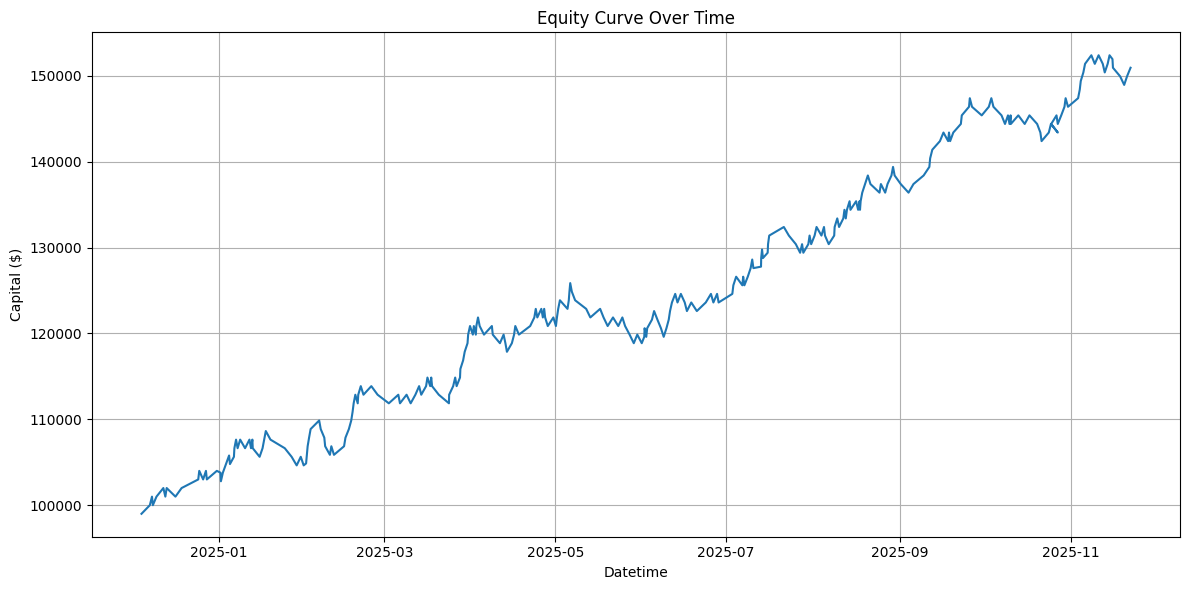

In [ ]:
# Atr Steps
# Start Values
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Records
equity_data = []
trades = []

# Position Following
current_position = None  # (entry_idx, direction, entry_price)

# Requirement Percentiles
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Signals
    signal_long = (row['pivot_mr_down']== True)


    signal_short = (row['pivot_mr_up']== True)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    # Long Signal geldiyse önceki pozisyon short olabilir diye düşünüyoruz ama DC ve BB'de genelde ard arda sinyaller geliyor.
    # Buraya önceki directiona göre if döngüsü eklenecek. signal_longta direction long ise pnl = -1 * pnl
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_price', 'Exit_price', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("atr_equity_curve_BTC.csv", index=False)
trades_df.to_csv("atr_trades_results_BTC.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → {(total_pnl / start_capital * 100):.2f} RR")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: % {round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Datetime")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Pivot Flag Up-Down

Başlangıç Sermaye: 100000
Bitiş Sermaye: 150948.64902204002
Toplam Kazanç: 50948.65 $ → 50.95 RR
Toplam Kazanç: 50.95 X
Toplam Kazanç 100 İşlemde: % 17.69 X
İşlem Sayısı: 288, Komisyon Miktarı: 12-14 X

İşlem Sonuçları Özeti:
                    count                sum
Exit_Reason Result                          
SL          Loss      114 -114000.0000000000
Signal      Loss        4   -2663.9449793236
            Win         6    3612.5940013636
TP          Win       164  164000.0000000000

Signal Ortalama X Kazancı: 0.09486490220400304

Long/Short Sayısı:
Direction
short    148
long     140
Name: count, dtype: int64

Long İşlemler:
TP: 84 SL: 53 Win Rate: %61.31
Short İşlemler:
TP: 80 SL: 61 Win Rate: %56.74

--- Percent ATR Analizi ---
Long - Win ortalama pct_atr: 0.6900
Long - Loss ortalama pct_atr: 0.6446
Short - Win ortalama pct_atr: 0.6958
Short - Loss ortalama pct_atr: 0.6817


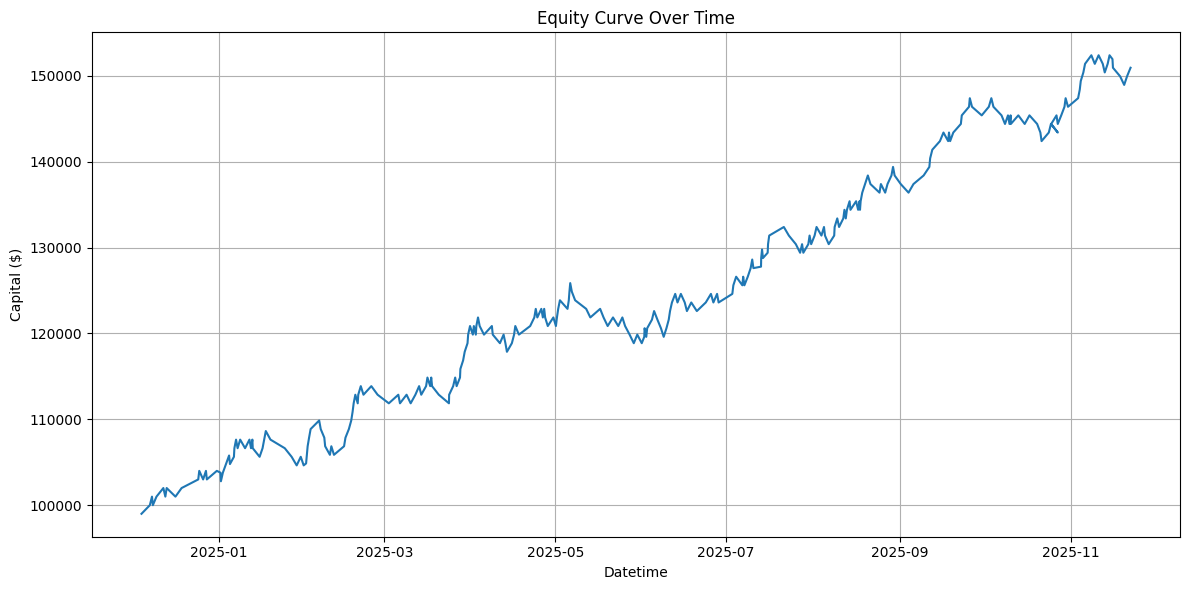

In [ ]:
# Atr Steps
# Start Values
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Records
equity_data = []
trades = []

# Position Following
current_position = None  # (entry_idx, direction, entry_price)

# Requirement Percentiles
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Signals
    signal_long = (row['pivot_flag_down']== True)


    signal_short = (row['pivot_flag_up']== True)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    # Long Signal geldiyse önceki pozisyon short olabilir diye düşünüyoruz ama DC ve BB'de genelde ard arda sinyaller geliyor.
    # Buraya önceki directiona göre if döngüsü eklenecek. signal_longta direction long ise pnl = -1 * pnl
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_price', 'Exit_price', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("atr_equity_curve_BTC.csv", index=False)
trades_df.to_csv("atr_trades_results_BTC.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → {(total_pnl / start_capital * 100):.2f} RR")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: % {round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Datetime")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Pivot Expanded Up-Down

Başlangıç Sermaye: 100000
Bitiş Sermaye: 150948.64902204002
Toplam Kazanç: 50948.65 $ → 50.95 RR
Toplam Kazanç: 50.95 X
Toplam Kazanç 100 İşlemde: % 17.69 X
İşlem Sayısı: 288, Komisyon Miktarı: 12-14 X

İşlem Sonuçları Özeti:
                    count                sum
Exit_Reason Result                          
SL          Loss      114 -114000.0000000000
Signal      Loss        4   -2663.9449793236
            Win         6    3612.5940013636
TP          Win       164  164000.0000000000

Signal Ortalama X Kazancı: 0.09486490220400304

Long/Short Sayısı:
Direction
short    148
long     140
Name: count, dtype: int64

Long İşlemler:
TP: 84 SL: 53 Win Rate: %61.31
Short İşlemler:
TP: 80 SL: 61 Win Rate: %56.74

--- Percent ATR Analizi ---
Long - Win ortalama pct_atr: 0.6900
Long - Loss ortalama pct_atr: 0.6446
Short - Win ortalama pct_atr: 0.6958
Short - Loss ortalama pct_atr: 0.6817


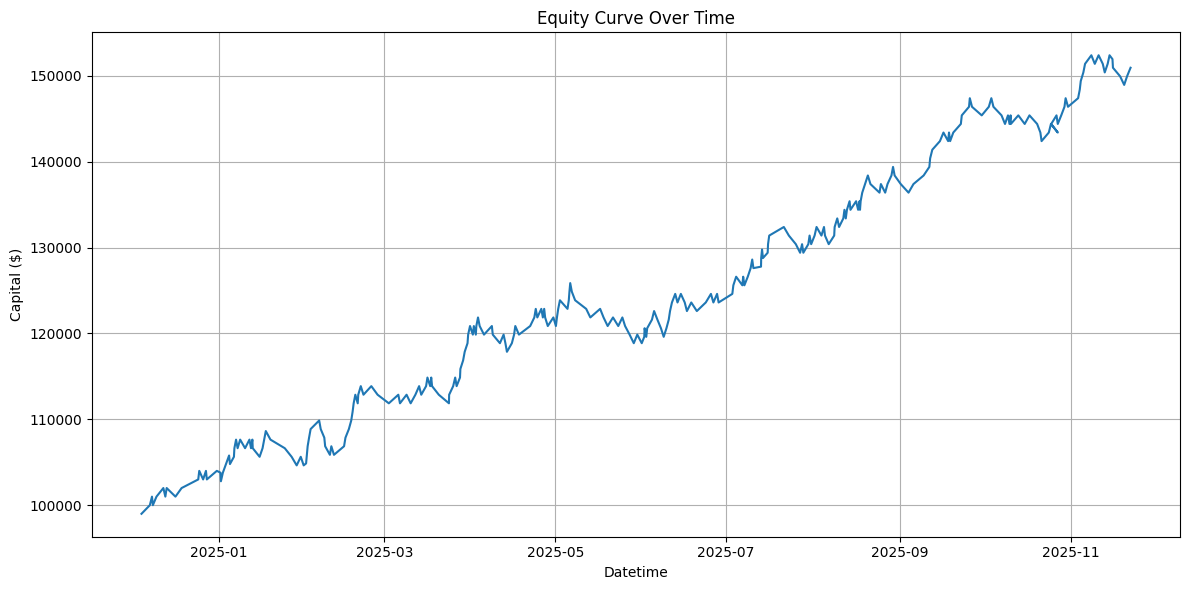

In [ ]:
# Atr Steps
# Start Values
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Records
equity_data = []
trades = []

# Position Following
current_position = None  # (entry_idx, direction, entry_price)

# Requirement Percentiles
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Signals
    signal_long = (row['pivot_expanded_up']== True)


    signal_short = (row['pivot_expanded_down']== True)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    # Long Signal geldiyse önceki pozisyon short olabilir diye düşünüyoruz ama DC ve BB'de genelde ard arda sinyaller geliyor.
    # Buraya önceki directiona göre if döngüsü eklenecek. signal_longta direction long ise pnl = -1 * pnl
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_price', 'Exit_price', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("atr_equity_curve_BTC.csv", index=False)
trades_df.to_csv("atr_trades_results_BTC.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → {(total_pnl / start_capital * 100):.2f} RR")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: % {round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Datetime")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Pivot Go Break Out-Down

In [ ]:
# Atr Steps
# Start Values
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Records
equity_data = []
trades = []

# Position Following
current_position = None  # (entry_idx, direction, entry_price)

# Requirement Percentiles
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Signals
    signal_long = (row['pivot_go_breakout']== True)


    signal_short = (row['pivot_go_breakdown']== True)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price = row['open']
            pnl_x = 1.0 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    # Long Signal geldiyse önceki pozisyon short olabilir diye düşünüyoruz ama DC ve BB'de genelde ard arda sinyaller geliyor.
    # Buraya önceki directiona göre if döngüsü eklenecek. signal_longta direction long ise pnl = -1 * pnl
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl

            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100)/3
            pnl_x = min(max(-1,pnl_x),1)
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_price', 'Exit_price', 'Entry_Idx', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("atr_equity_curve_BTC.csv", index=False)
trades_df.to_csv("atr_trades_results_BTC.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → {(total_pnl / start_capital * 100):.2f} RR")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: % {round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Datetime")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Pivot Breakout & Breakdown

In [ ]:
# Pivot Breakout & Breakdown
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['pivot_breakout']== True) and (low_atr < row['pct_atr'] < high_atr) and (row['nw_position']=='above_middle') #and  row['cat_rsi'] in [ 'above_avg']
    #row['nw_position'] in ['above_middle']

    signal_short = (row['pivot_breakdown']== True) and (low_atr < row['pct_atr'] < high_atr) and (row['nw_position']=='below_middle') #and  row['cat_rsi'] in ['below_avg']
    #row['nw_position'] in ['below_middle']

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['3x_bar']
            sl_bars = entry_row['-3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price= 0
            pnl_x = 1 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-3x_bar']
            sl_bars = entry_row['3x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price= 0
            pnl_x = 1 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 3
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 3
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx','Entry_price','Exit_price', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("atr_equity_curve_DOGE.csv", index=False)
trades_df.to_csv("atr_trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → {(total_pnl / start_capital * 100):.2f} RR")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: % {round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## BB.ELF 15 DK

In [ ]:
# BB3 ELF 15 İÇİN
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.1)
high_atr = dff['pct_atr'].quantile(0.9)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['bb_3_touch_long_clean'] and row['dc_position_20'] in ['75-100', '60-75'] and  row['cat_rsi'] in ['overbought', 'above_avg'] and row['nw_position'] == 'above_middle' and
                  row['bb_position'] in ['above_100','75-100', '50-75'] and row['dc_position_20'] in ['75-100', '60-75'] and row['adx_category'] in ['medium_trend','strong_trend'] and
                   low_atr < row['pct_atr'] < high_atr) #and (row['bb3_long_pivot_atr'] < 5)


    signal_short = (row['bb_3_touch_short_clean'] and row['dc_position_20'] in ['0-25', '25-40'] and row['cat_rsi'] in ['oversold', 'below_avg'] and
                   row['nw_position'] == 'below_middle' and row['bb_position'] in ['25-50','0-25','below_0'] and row['adx_category'] in ['medium_trend','strong_trend'] and
                     low_atr < row['pct_atr'] < high_atr) #and (row['bb3_short_pivot_atr'] < 5)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price= 0
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price= 0
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])

# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx','Entry_price','Exit_price', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("equity_curve_SOL.csv", index=False)
#trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / (len(equity_df)) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


## DC50 15 DK

In [ ]:
# DONCHAIN CHANNELS 50 15DK İÇİN
# Başlangıç değerleri
start_capital = 100000
capital = start_capital
x_unit = 1000  # 1x başına 1000 dolar

# Kayıtlar
equity_data = []
trades = []

# Pozisyon takibi
current_position = None  # (entry_idx, direction, entry_price)

# Gerekli percentiller
low_atr = dff['pct_atr'].quantile(0.2)
high_atr = dff['pct_atr'].quantile(0.8)

for idx, row in dff.iterrows():
    # Sinyaller
    signal_long = (row['dc_breakout_clean_50'] and row['dc_position_20'] in ['75-100', '60-75'] and  row['cat_rsi'] in ['overbought', 'above_avg'] and row['nw_position']=='above_middle' and
                  row['bb_position'] in ['above_100','75-100', '50-75'] and row['dc_position_20'] in ['75-100', '60-75'] and row['adx_category'] in [ 'medium_trend','strong_trend'] and
                   low_atr < row['pct_atr'] < high_atr) and (row['dc50_long_pivot_atr'] < 5)

    signal_short = (row['dc_breakdown_clean_50'] and row['dc_position_20'] in ['0-25', '25-40'] and row['cat_rsi'] in ['oversold', 'below_avg'] and
                   row['nw_position']=='below_middle' and row['bb_position'] in ['25-50','0-25','below_0'] and row['adx_category'] in [ 'medium_trend','strong_trend'] and
                     low_atr < row['pct_atr'] < high_atr) and (row['dc50_short_pivot_atr'] < 5)

    # Mevcut pozisyon varsa TP/SL kontrolü
    if current_position:
        entry_idx, direction, entry_price = current_position
        entry_row = dff.loc[entry_idx]

        if direction == 'long':
            tp_bars = entry_row['4x_bar']
            sl_bars = entry_row['-4x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price= 0
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        else:  # short
            tp_bars = entry_row['-4x_bar']
            sl_bars = entry_row['2x_bar']
            tp_hit = pd.notna(tp_bars) and (idx - entry_idx == tp_bars)
            sl_hit = pd.notna(sl_bars) and (idx - entry_idx == sl_bars)
            exit_price= 0
            pnl_x = 2 if tp_hit else -1 if sl_hit else 0

        if tp_hit or sl_hit:
            exit_reason = 'TP' if tp_hit else 'SL'
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            trades.append((
                pnl_dollar, pnl_x, direction, entry_price, exit_price, entry_idx, idx, exit_reason,
                dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
            ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

    # Yeni sinyal gelirse önce varsa pozisyonu kapat
    if signal_long:
        if current_position:
            exit_price = row['close']
            pnl = entry_price  -  exit_price  # long pozisyon
            if direction == 'long':
                pnl = -1 * pnl
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction, entry_price, exit_price,  entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))
            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni long aç
        direction = 'long'
        current_position = (idx, direction, row['close'])

    elif signal_short:
        if current_position:
            exit_price = row['close']
            pnl =  exit_price  - entry_price # short pozisyon
            if direction == 'short':
                pnl = -1 * pnl
            pnl_pct = pnl / entry_price * 100
            pnl_x = pnl_pct / (row['x'] / row['close'] * 100) / 2
            pnl_dollar = pnl_x * x_unit

            capital += pnl_dollar
            exit_reason = 'Signal'
            trades.append((
                        pnl_dollar, pnl_x, direction,entry_price, exit_price, entry_idx, idx, exit_reason,
                        dff.loc[entry_idx, 'time'], row['time'], dff.loc[entry_idx, 'pct_atr']
                    ))

            equity_data.append({'Capital': capital, 'Time': row['time']})
            current_position = None

        # Yeni short aç
        direction = 'short'
        current_position = (idx, direction, row['close'])


# DataFrame oluşturma
trades_df = pd.DataFrame(trades, columns=[
    'Pnl_Dollar', 'Pnl_X', 'Direction', 'Entry_Idx','Entry_price','Exit_price', 'Exit_Idx', 'Exit_Reason', 'Entry_Time', 'Exit_Time', 'Entry_pct_atr'
])
trades_df['Result'] = trades_df['Pnl_Dollar'].apply(lambda x: 'Win' if x > 0 else 'Loss')

equity_df = pd.DataFrame(equity_data)
equity_df.to_csv("dc_equity_curve_SOL.csv", index=False)
trades_df.to_csv("trades_results.csv", index=False)

# Sonuçlar
print("Başlangıç Sermaye:", start_capital)
print("Bitiş Sermaye:", capital)
total_pnl = capital - start_capital
print(f"Toplam Kazanç: {total_pnl:.2f} $ → %{(total_pnl / start_capital * 100):.2f}")
print(f"Toplam Kazanç: {trades_df['Pnl_X'].sum():.2f} X")
print(f"Toplam Kazanç 100 İşlemde: %{round((trades_df['Pnl_X'].sum()) / len(equity_df) * 100, 2)} X")
print(f"İşlem Sayısı: {len(equity_df)}, Komisyon Miktarı: {round(len(equity_df) * 0.04)}-{round(len(equity_df) * 0.05)} X")

# Özet tablo
print("\nİşlem Sonuçları Özeti:")
summary = trades_df.groupby(['Exit_Reason', 'Result'])['Pnl_Dollar'].agg(['count', 'sum'])
print(summary)

print("\nSignal Ortalama X Kazancı:", trades_df[trades_df['Exit_Reason'] == 'Signal']['Pnl_X'].mean())

# Long-short dağılımı
print("\nLong/Short Sayısı:")
print(trades_df['Direction'].value_counts())

# Long işlemler için TP ve SL
long_df = trades_df[trades_df['Direction'] == 'long']
long_tp = len(long_df[long_df['Exit_Reason'] == 'TP'])
long_sl = len(long_df[long_df['Exit_Reason'] == 'SL'])
long_total = long_tp + long_sl
long_win_rate = long_tp / long_total * 100 if long_total else 0

# Short işlemler için TP ve SL
short_df = trades_df[trades_df['Direction'] == 'short']
short_tp = len(short_df[short_df['Exit_Reason'] == 'TP'])
short_sl = len(short_df[short_df['Exit_Reason'] == 'SL'])
short_total = short_tp + short_sl
short_win_rate = short_tp / short_total * 100 if short_total else 0

print("\nLong İşlemler:\nTP:", long_tp, "SL:", long_sl, f"Win Rate: %{long_win_rate:.2f}")
print("Short İşlemler:\nTP:", short_tp, "SL:", short_sl, f"Win Rate: %{short_win_rate:.2f}")

print("\n--- Percent ATR Analizi ---")

# Long işlemler
long_wins = long_df[long_df['Result'] == 'Win']
long_losses = long_df[long_df['Result'] == 'Loss']

print(f"Long - Win ortalama pct_atr: {long_wins['Entry_pct_atr'].mean():.4f}")
print(f"Long - Loss ortalama pct_atr: {long_losses['Entry_pct_atr'].mean():.4f}")

# Short işlemler
short_wins = short_df[short_df['Result'] == 'Win']
short_losses = short_df[short_df['Result'] == 'Loss']

print(f"Short - Win ortalama pct_atr: {short_wins['Entry_pct_atr'].mean():.4f}")
print(f"Short - Loss ortalama pct_atr: {short_losses['Entry_pct_atr'].mean():.4f}")


# Equity grafiği
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_df['Time']), equity_df['Capital'])
plt.title("Equity Curve Over Time")
plt.xlabel("Tarih")
plt.ylabel("Sermaye ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
dff['pct_atr'].describe([0.2,0.8])

In [ ]:
bb_result = pd.read_csv('/content/trades_results.csv')

In [ ]:
bb_result[bb_result['Exit_Reason']=='Signal'].head(15)